# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, GlobalAveragePooling1D, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2022-11-14 10:41:17.027877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nucleo_dic = {
    'A': 0,
    'R': 1,
    'N': 2,
    'D': 3,
    'C': 4,
    'Q': 5,
    'E': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'L': 10,
    'K': 11,
    'M': 12,
    'F': 13,
    'P': 14,
    'S': 15,
    'T': 16,
    'W': 17,
    'Y': 18,
    'V': 19,
    'X': 20
}

In [3]:
model = tf.keras.models.load_model('knots_simple_CNN/cnn_10epochs.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 493, 32)           5408      
                                                                 
 batch_normalization (BatchN  (None, 493, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 246, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 239, 16)           4112      
                                                                 
 batch_normalization_1 (Batc  (None, 239, 16)          64        
 hNormalization)                                                 
                                                        

2022-11-14 10:41:20.363913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 10:41:20.789691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43652 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:a3:00.0, compute capability: 8.6


# Looking for the knot core:

In [4]:
seq = 'MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFEIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSL'

In [5]:
SEQ_DIM = 500  # maximum length of input sequence (limited by the CNN)

def fix_seq_size(seq):
    if len(seq) < SEQ_DIM:
        seq += 'X' * (SEQ_DIM-len(seq))
    elif len(seq) > SEQ_DIM:
        seq = seq[SEQ_DIM:]
    return seq

def get_seq_prediction(seq):
    seq_onehot = tf.one_hot([nucleo_dic[c] for c in seq], depth=21)
    prediction = model.predict(np.expand_dims(seq_onehot, axis=0), verbose=0)
    return seq_onehot, prediction

In [6]:
seq = fix_seq_size(seq)
seq_onehot, prediction = get_seq_prediction(seq)
prediction

2022-11-14 10:41:22.091923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-11-14 10:41:23.025432: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-14 10:41:23.025857: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-14 10:41:23.025877: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-14 10:41:23.026401: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-14 10:41:23.026464: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


array([[0.99978]], dtype=float32)

In [7]:
PATCH_SIZE = 50
PATCH_CHAR = 'X'

def iterate_patch_over_seq(seq, overlap_step, patch_size=PATCH_SIZE, patch_char=PATCH_CHAR):
    scores = []
    
    # get prediction for the original sequence:
    seq_onehot, prediction = get_seq_prediction(seq)
    prediction = prediction[0][0]
    scores.append({'position': -1,
                   'patched_seq': seq, 
                   'prediction': prediction,
                   'patched_subseq': ''}) 
    
    # get prediction for all patched versions of the original sequence:
    patch = PATCH_CHAR * PATCH_SIZE
    last_patch_start_i = SEQ_DIM-PATCH_SIZE
    for i in range(0, last_patch_start_i, overlap_step):
        patched_subseq = seq[i:i+PATCH_SIZE]
        patched_seq = seq[:i] + patch + seq[i+PATCH_SIZE:]
        seq_onehot, prediction = get_seq_prediction(patched_seq)
        prediction = prediction[0][0]
        scores.append({'position': i,
                       'patched_seq': patched_seq, 
                       'prediction': prediction,
                       'patched_subseq': patched_subseq}) 
    return scores

In [8]:
def visualize_one_seq_results(seq, overlap_step=1):
    print('==== Sequence patch results: ====')
    print(seq)
    scores = iterate_patch_over_seq(seq, overlap_step)
    df_scores = pd.DataFrame(scores)
    
    plt.plot(df_scores['position'], df_scores['prediction'])
    plt.show()
    
    # get index of the sequence which resulted in the lowest prediction score:
    min_i = df_scores['prediction'].idxmin()
    print(f'Min prediction for seq version (i={min_i}): {df_scores.iloc[min_i]["patched_seq"]}')
    print(f'Patched subseq: {df_scores.iloc[min_i]["patched_subseq"]}')
    return scores

==== Sequence patch results: ====
MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFEIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


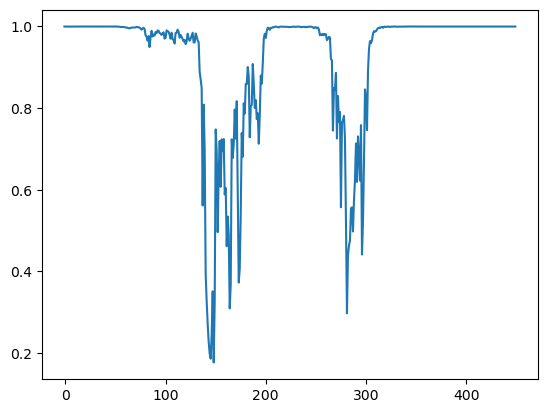

Min prediction for seq version (i=149): MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: SEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFE


In [9]:
result = visualize_one_seq_results(seq)

In [10]:
import csv

with open('/home/jovyan/data/proteins/SPOUT_knotted_small.csv', newline='') as f:
    reader = csv.reader(f, delimiter=';')
    data = list(reader)

data[0]

['\ufeffseq', 'knotted?']

==== Sequence patch results: ====
MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFEIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSL


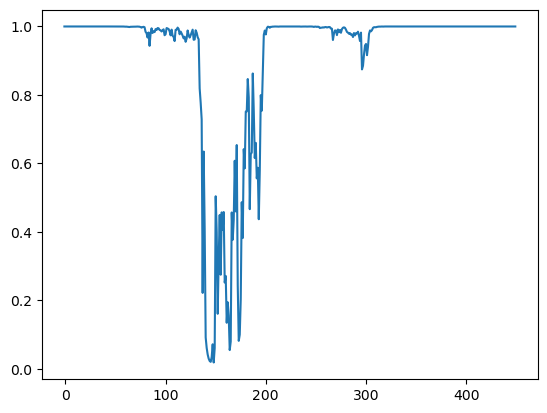

Min prediction for seq version (i=149): MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSL
Patched subseq: SEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFE
==== Sequence patch results: ====
MAKYIIKTQKGFENIVVNNLKEIIGDFKYTVSPDGYQGIVIVEHDEDIEDKILEIPEVERVLRVYFETETEFDKIVNLAEKIKDYIKEDETFAVETKKRGKHDFSSTDVNIVLGAKIKDLTNASVDLNNPDKVVHVEVFKNKTYVSITPGEKFKKYTKEKRNARELFRKVVIVQMPYLGEKIVCKRFGEAIGRAAQGFEVKELIIAPKEKVDAYELMEFIKGVKIGQHSRYEIQKRAYPFEIKLVPVTVQDLYQVVRDKRRDNRLLIITDPKGDELSKIKDKLAYDLRKKREIIVFCGSREGIPRGLFRFADYILDLAPHMTFATEHAIPAALIALWGVYSGEDLENSSEEEKTESNSNDE


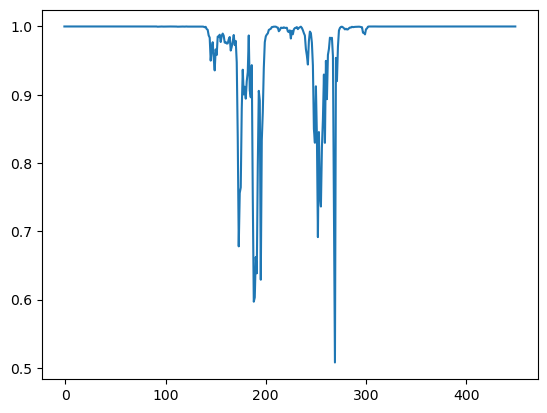

Min prediction for seq version (i=270): MAKYIIKTQKGFENIVVNNLKEIIGDFKYTVSPDGYQGIVIVEHDEDIEDKILEIPEVERVLRVYFETETEFDKIVNLAEKIKDYIKEDETFAVETKKRGKHDFSSTDVNIVLGAKIKDLTNASVDLNNPDKVVHVEVFKNKTYVSITPGEKFKKYTKEKRNARELFRKVVIVQMPYLGEKIVCKRFGEAIGRAAQGFEVKELIIAPKEKVDAYELMEFIKGVKIGQHSRYEIQKRAYPFEIKLVPVTVQDLYQVVRDKRRDNRLLIITXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXHMTFATEHAIPAALIALWGVYSGEDLENSSEEEKTESNSNDE
Patched subseq: DPKGDELSKIKDKLAYDLRKKREIIVFCGSREGIPRGLFRFADYILDLAP
==== Sequence patch results: ====
MKFLVKTQRDMEAVAGNYITEAVPDAEVWIAPMGYTGLVLVEADENAYEKLLEIPEVERVIPVLVETEADLEKIAESAEKIAHLIGENETYAVKTKRRGKHDFSSIDVNRVLGARIKELSGADVNLSWPDKVVQVEIIGDRAYISVLPGEEYRKYTPNKIDARKLFRKLTVVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIKGVKIGQESRYKIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEELARDMHHAREVVVFIGSREGIPRGVFRFADYVVDLAPYMTFATEHGIPATLVSLWEVYEEFLRENGKEEKEGE


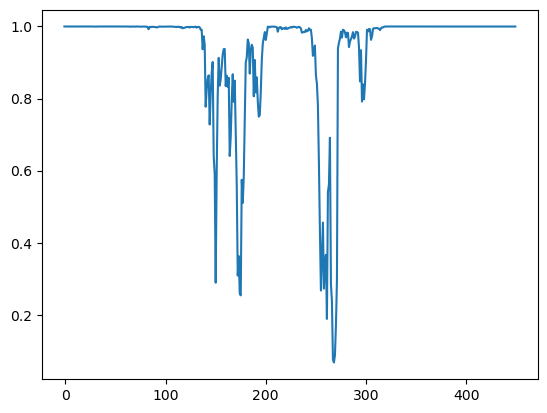

Min prediction for seq version (i=269): MKFLVKTQRDMEAVAGNYITEAVPDAEVWIAPMGYTGLVLVEADENAYEKLLEIPEVERVIPVLVETEADLEKIAESAEKIAHLIGENETYAVKTKRRGKHDFSSIDVNRVLGARIKELSGADVNLSWPDKVVQVEIIGDRAYISVLPGEEYRKYTPNKIDARKLFRKLTVVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIKGVKIGQESRYKIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXYMTFATEHGIPATLVSLWEVYEEFLRENGKEEKEGE
Patched subseq: DPKGPTLAEVKEELARDMHHAREVVVFIGSREGIPRGVFRFADYVVDLAP
==== Sequence patch results: ====
MIFVKTQRGMEYIAAQNIKELLGDVKIEIRPAGYLGILVVHSDELEQVRQVPEVERAIPVLFEIESNLDEILEKAEEVVKAMGEFDTFAIRATRRGLKHRFSSMDISIQLGRRIQEISGRDVDLNTPDKAIYVEVVNERTFIGILDGAEERRKYTPEKADSLRFFEKVSFVQMPYLENLKGAREIGERIGRNAQSFEIKELIIAPYGYVDAEELFEFLRGVRRGKLSRLSIQRKSYAREVRETKILVHDLFQTLRDKKRRKYVVIATDPTGRQISDVRDELKRAFERANEIVIFAGSRTGLPKGVLRLADFVVDLSPYITFPTELAIPVSLTAFLDIYEEMKADRTKRER


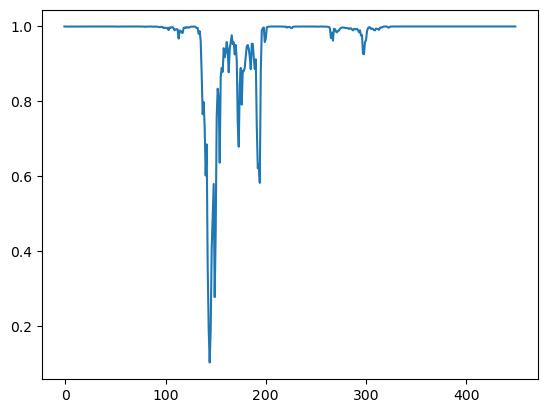

Min prediction for seq version (i=145): MIFVKTQRGMEYIAAQNIKELLGDVKIEIRPAGYLGILVVHSDELEQVRQVPEVERAIPVLFEIESNLDEILEKAEEVVKAMGEFDTFAIRATRRGLKHRFSSMDISIQLGRRIQEISGRDVDLNTPDKAIYVEVVNERTFIGIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXSFEIKELIIAPYGYVDAEELFEFLRGVRRGKLSRLSIQRKSYAREVRETKILVHDLFQTLRDKKRRKYVVIATDPTGRQISDVRDELKRAFERANEIVIFAGSRTGLPKGVLRLADFVVDLSPYITFPTELAIPVSLTAFLDIYEEMKADRTKRER
Patched subseq: LDGAEERRKYTPEKADSLRFFEKVSFVQMPYLENLKGAREIGERIGRNAQ
==== Sequence patch results: ====
MIFVKTQRGMEYIAMQNIKELMGDVKIEVRPAGYLGVLIVHSDDIEKVKEVPEVEKAIPILFELRSDLDEILGKAEEIVEAMGDFETFAVRTTRRGLRHDFNSMDVNIRLGRRIQEISGKEVDLNQPDKAVYVEIVNERTFIGILDGEEERRKYMPEKVDSLKFFGKVSFVQMPYLENPKGAREIGERIGRSAQSFEIKELIIAPYGYVDADELYEFLRGLRRGKESRLKIQRRSYARDVREVRVLVHDLYQTFRDKRRKRSVLISTDPTGKQLSEIREELKRAFERADEIVIFAGSRTGLPKGILRLSDFVIDLTPYITFPTEIAIPASLIALLDVYEEMVQEREQK


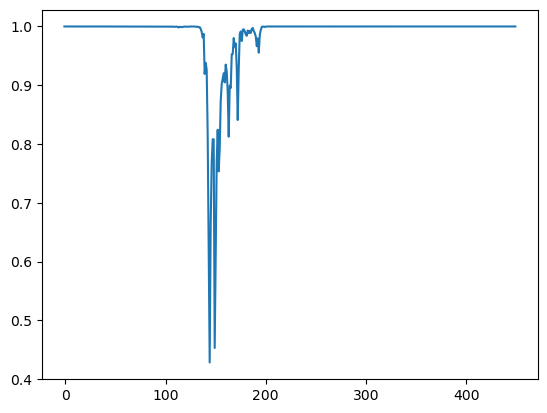

Min prediction for seq version (i=145): MIFVKTQRGMEYIAMQNIKELMGDVKIEVRPAGYLGVLIVHSDDIEKVKEVPEVEKAIPILFELRSDLDEILGKAEEIVEAMGDFETFAVRTTRRGLRHDFNSMDVNIRLGRRIQEISGKEVDLNQPDKAVYVEIVNERTFIGIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXSFEIKELIIAPYGYVDADELYEFLRGLRRGKESRLKIQRRSYARDVREVRVLVHDLYQTFRDKRRKRSVLISTDPTGKQLSEIREELKRAFERADEIVIFAGSRTGLPKGILRLSDFVIDLTPYITFPTEIAIPASLIALLDVYEEMVQEREQK
Patched subseq: LDGEEERRKYMPEKVDSLKFFGKVSFVQMPYLENPKGAREIGERIGRSAQ
==== Sequence patch results: ====
MASRECQLLLVKTILGMERVAASYIAEMDPDARIEPAPRGFRGLVLVEASKDKYELAREIEAKVPEVEKVVVAEACTEADPAKIAETAAALAPRFISSNETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMKPGKYPLYKLFRRFSIVQMPYLGPLDACRTMGVRVGREVQNFEVGELVVAPIGLVDARQLYEFLGGVFEGIESRYQIQRRSYGRDVRRVPVYVQDLYQLVRSRHGEPIIVFEPEGDPISKRAKDVLEIVKRGRRVTLLFGSREGIPEGVYRFADLVLDIAPGITLSTEYAAAAALIAIGSVVHDELAAEQVNGEDSAADKQPKDAA


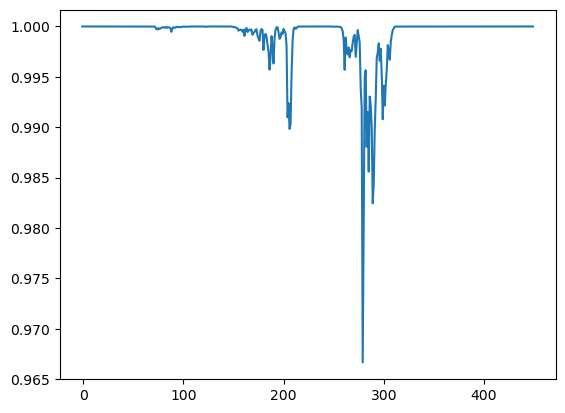

Min prediction for seq version (i=280): MASRECQLLLVKTILGMERVAASYIAEMDPDARIEPAPRGFRGLVLVEASKDKYELAREIEAKVPEVEKVVVAEACTEADPAKIAETAAALAPRFISSNETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMKPGKYPLYKLFRRFSIVQMPYLGPLDACRTMGVRVGREVQNFEVGELVVAPIGLVDARQLYEFLGGVFEGIESRYQIQRRSYGRDVRRVPVYVQDLYQLVRSRHGEPIIVFEXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXITLSTEYAAAAALIAIGSVVHDELAAEQVNGEDSAADKQPKDAA
Patched subseq: PEGDPISKRAKDVLEIVKRGRRVTLLFGSREGIPEGVYRFADLVLDIAPG
==== Sequence patch results: ====
MKFLIKTQKDMEAVAANYIKDLLDETEIWVTPQGYSGLVLVDTKDPKAEEKFFEIPEIERIIPVLFEVPASLDAIVSVAEEIADYISEEETFAVKTKRRGKHEFSSIDVNITLGEKIRELTNAAVDLSFPDKTVLVEIIGERAYISIAGKEEWKKFTPEKINARKLFKKVTIVQMPYWGDYKACKNFGEKIGRAVQAFEVKELIIAPKEKMNAYELMEFIKGIRTGQESRYQIQKEAYPWKVEKVPISVWDLYQVIRDKRRNKRLLIITDPKGNTIPEVKENLTKDLYYAKEVVVFIGSREGIPRGLFRYADYVLDLAPYMTFATEHGIPAVLIALWTIYEEELRKKGIKEE


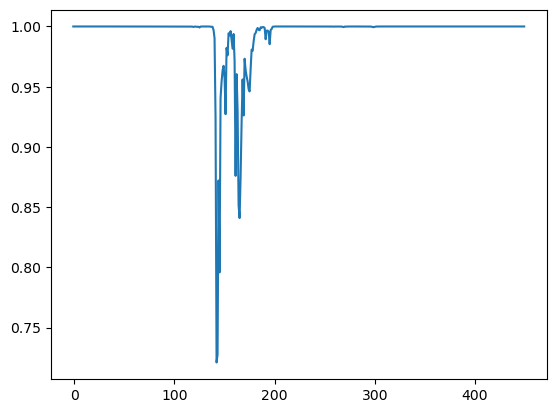

Min prediction for seq version (i=143): MKFLIKTQKDMEAVAANYIKDLLDETEIWVTPQGYSGLVLVDTKDPKAEEKFFEIPEIERIIPVLFEVPASLDAIVSVAEEIADYISEEETFAVKTKRRGKHEFSSIDVNITLGEKIRELTNAAVDLSFPDKTVLVEIIGERXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXRAVQAFEVKELIIAPKEKMNAYELMEFIKGIRTGQESRYQIQKEAYPWKVEKVPISVWDLYQVIRDKRRNKRLLIITDPKGNTIPEVKENLTKDLYYAKEVVVFIGSREGIPRGLFRYADYVLDLAPYMTFATEHGIPAVLIALWTIYEEELRKKGIKEE
Patched subseq: AYISIAGKEEWKKFTPEKINARKLFKKVTIVQMPYWGDYKACKNFGEKIG
==== Sequence patch results: ====
MKFIVKTQRGMESVAANYIREAISDASVWASPMGYSGLIIVETSDENAGEKILEIPEVERLIPVIAEVPAELEAIVTTAEKIAPLISENETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDRVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGNHKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKDRLAKDMFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREKKT


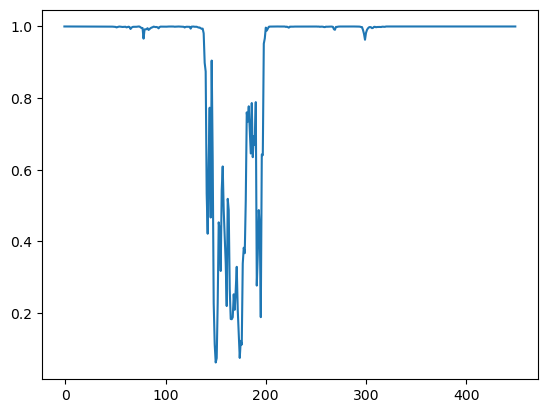

Min prediction for seq version (i=151): MKFIVKTQRGMESVAANYIREAISDASVWASPMGYSGLIIVETSDENAGEKILEIPEVERLIPVIAEVPAELEAIVTTAEKIAPLISENETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDRVVQVEIIGDKAYISVVPGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKDRLAKDMFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREKKT
Patched subseq: EEFRKFTPDKIDARKLFRKVTLVQMPYWGNHKACRSFGEKIGRAAQAFEV
==== Sequence patch results: ====
MSECSVILVKTELGMERYVANSLDVDCEIVAAPMGFKGLVLMKNCKNLEEVIERLNGMPEVIRFMIAEECVRADLKELKEAAKRLARKLEGKRFAVRTIRRGSHPFTSIEVNAELGALILREANGSKVDLTNPEAVLMVEIIGEEAYLAVVDPSYAGLKKKLGKEDTARFLSRLSVIQEPYLGPPKSIEELGKRIGRILQSYGVGEYYIGLIEETDALQLAQFIESVRDGMEARRKQEEKVEGKALSTKLKVFDVYHLALSKSKKELMVVFEPEGKSFEEVEEELAKALRKAKRVKAFLGSRKGVPMGIYKLADFVIDVAPGRTLSTETALAAALEALLIAYLRGKFYSDNQQ


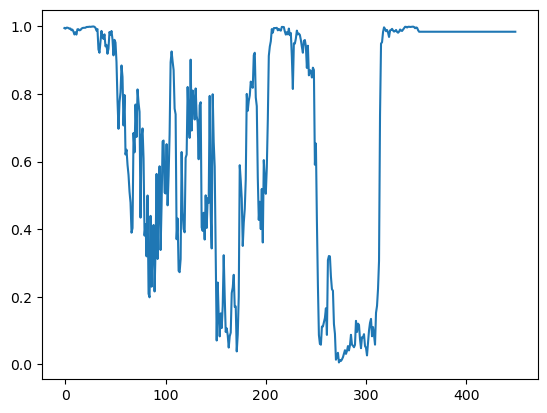

Min prediction for seq version (i=274): MSECSVILVKTELGMERYVANSLDVDCEIVAAPMGFKGLVLMKNCKNLEEVIERLNGMPEVIRFMIAEECVRADLKELKEAAKRLARKLEGKRFAVRTIRRGSHPFTSIEVNAELGALILREANGSKVDLTNPEAVLMVEIIGEEAYLAVVDPSYAGLKKKLGKEDTARFLSRLSVIQEPYLGPPKSIEELGKRIGRILQSYGVGEYYIGLIEETDALQLAQFIESVRDGMEARRKQEEKVEGKALSTKLKVFDVYHLALSKSKKELMVVFEPXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXTLSTETALAAALEALLIAYLRGKFYSDNQQ
Patched subseq: EGKSFEEVEEELAKALRKAKRVKAFLGSRKGVPMGIYKLADFVIDVAPGR
==== Sequence patch results: ====
MKFLIKTQRGMEAVAANYIKDALEDAKVWIAPQGYSGLVLVESEDKDAEQKLFDIPEIERVIPVLFEVPATIEDILSVSEQIAAYIKEGESFAVKTKRRGKHGFSSVDVNIALGGKIKELTNAEVDLTFPDKTVLVEIIGDRAYISITGREEWKKFTPEKIDARKLFKKVTIVQMPYWGDYKACRNFGEKIGRAAQAFEVKELIIAPKDKMDAYELMEFIQGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGNSVSEIKDSLAKDLYYAKEVVVFIGSREGIPRGLFRYADYVIDLAPYMTFATEHGIPAALIALWTIYEEELRKEEGKR


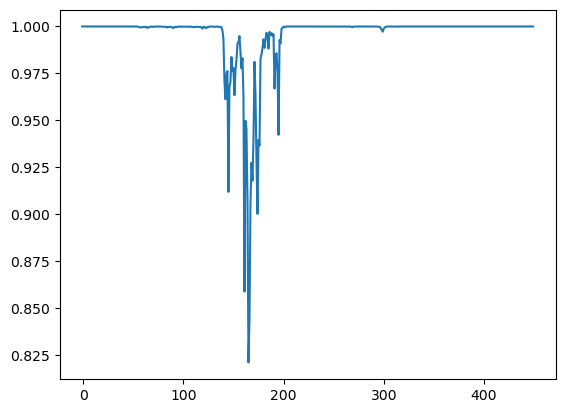

Min prediction for seq version (i=166): MKFLIKTQRGMEAVAANYIKDALEDAKVWIAPQGYSGLVLVESEDKDAEQKLFDIPEIERVIPVLFEVPATIEDILSVSEQIAAYIKEGESFAVKTKRRGKHGFSSVDVNIALGGKIKELTNAEVDLTFPDKTVLVEIIGDRAYISITGREEWKKFTPEKIDARKXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXLMEFIQGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGNSVSEIKDSLAKDLYYAKEVVVFIGSREGIPRGLFRYADYVIDLAPYMTFATEHGIPAALIALWTIYEEELRKEEGKR
Patched subseq: LFKKVTIVQMPYWGDYKACRNFGEKIGRAAQAFEVKELIIAPKDKMDAYE
==== Sequence patch results: ====
MQGSKCNLVLMKTVLGMEKVAASYVKEIDPGARVEPSPRGFRGLVLVEPSRDKYEVAKEIEERVPEAEKVVVAEACTEADPRKIAEIAAELAPRFISSSETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMRPGKYPLYKLFRRLSVVQMPYLGPLDACRTMGVRVGREVQNFEVGELVVSPIGLVDALQLKTFLDGVFEGIESRYQVQRKSYGRDVHRVPVYVQDLYQLVRSRYDEPVIVFEPEGDPISKRARDILELVRKGRRVNLLFGSREGIPEGVYRFADLVLDVAPGITLSTEYAAAAALIAIGSVIHDLLAVDREPAGEQGSRS


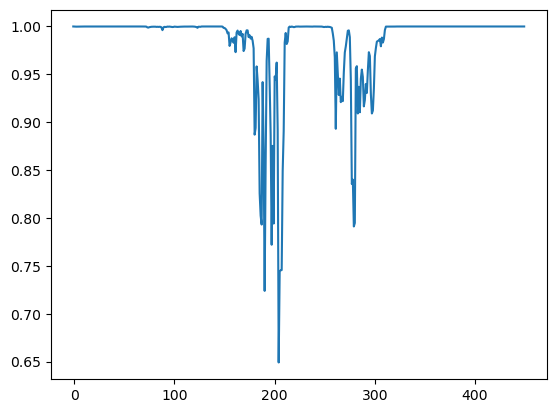

Min prediction for seq version (i=205): MQGSKCNLVLMKTVLGMEKVAASYVKEIDPGARVEPSPRGFRGLVLVEPSRDKYEVAKEIEERVPEAEKVVVAEACTEADPRKIAEIAAELAPRFISSSETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMRPGKYPLYKLFRRLSVVQMPYLGPLDACRTMGVRVGRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXRVPVYVQDLYQLVRSRYDEPVIVFEPEGDPISKRARDILELVRKGRRVNLLFGSREGIPEGVYRFADLVLDVAPGITLSTEYAAAAALIAIGSVIHDLLAVDREPAGEQGSRS
Patched subseq: EVQNFEVGELVVSPIGLVDALQLKTFLDGVFEGIESRYQVQRKSYGRDVH
==== Sequence patch results: ====
MGEGKKFIVKTQRGMESVAANYISEVLPDANVWASPMGYSGLIIVESSAEDALDKILQIPEVERVIPVIVETEANLEKIAESAEKLAGFIGENETYAVKTKRRGKHDFSSIDVNRVLGAKIKELTNADVNLSWPDKVVQVEIIGDRAYISVIPGDEFRKYTPDKIDARKLFSKLTLVQMPYWGDYKACRLFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQRDAYPWKVEKVPVTVWDLYQVVRDKRRKKRLLIITDPKGPTLAEVKDKLARDLHYAKEVVVFIGSREGIPKGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEFLRKEE


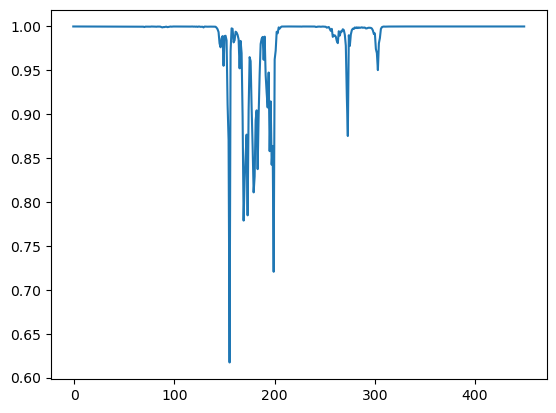

Min prediction for seq version (i=156): MGEGKKFIVKTQRGMESVAANYISEVLPDANVWASPMGYSGLIIVESSAEDALDKILQIPEVERVIPVIVETEANLEKIAESAEKLAGFIGENETYAVKTKRRGKHDFSSIDVNRVLGAKIKELTNADVNLSWPDKVVQVEIIGDRAYISVIPGDXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQRDAYPWKVEKVPVTVWDLYQVVRDKRRKKRLLIITDPKGPTLAEVKDKLARDLHYAKEVVVFIGSREGIPKGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEFLRKEE
Patched subseq: EFRKYTPDKIDARKLFSKLTLVQMPYWGDYKACRLFGEKIGRAAQAFEVK
==== Sequence patch results: ====
MKFLVKTQKGMEGVAANYIGEALPDAEVWISPMGYYGLVIVETGDENAGEVMLGIPEIERIIPVLAEVPAELERIVEIAEKVAPLIGENETFAVKTKRRGKHGFSSIDVNRELGAKVRELTGADVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKRDARELFRKVTVVQMPYWGGYKVCRSFGEKIGRAAQAFEVKELIIAPKGKMDALELAEFIKGVRVGQESRHRIQRESYPWKVEKVPVSVWDLYQVVRDKRRDKRLLIITDPKGPTVAQVGERLARDMFHAKEVVVFIGSREGIPRGLFRFADYVIDLAPYMTFATEHGIPAALVSLWEVYEEYTGKREAKGEAVSD


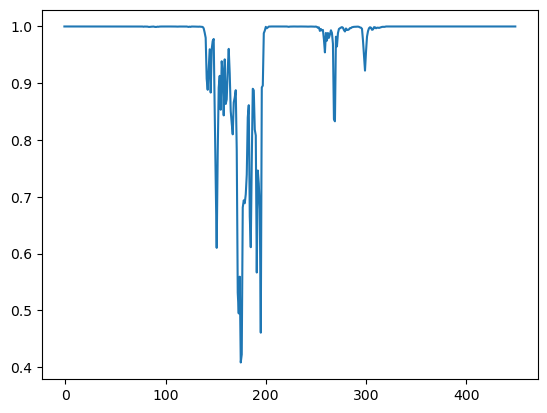

Min prediction for seq version (i=176): MKFLVKTQKGMEGVAANYIGEALPDAEVWISPMGYYGLVIVETGDENAGEVMLGIPEIERIIPVLAEVPAELERIVEIAEKVAPLIGENETFAVKTKRRGKHGFSSIDVNRELGAKVRELTGADVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKRDARELFRKVTVVQMXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGQESRHRIQRESYPWKVEKVPVSVWDLYQVVRDKRRDKRLLIITDPKGPTVAQVGERLARDMFHAKEVVVFIGSREGIPRGLFRFADYVIDLAPYMTFATEHGIPAALVSLWEVYEEYTGKREAKGEAVSD
Patched subseq: PYWGGYKVCRSFGEKIGRAAQAFEVKELIIAPKGKMDALELAEFIKGVRV
==== Sequence patch results: ====
MEFIIKTQKNLEGTAATRIKEKLKNAETWITPEGYSGLIILKTTDKEATKKLQEIPEIERTLPIHYKTGSNLEKILEKAEKIAKHIKENETFAVKTKRRGKHNFTSPEINKKLGEKILQLTNATVNLNSPDKTIQIEIIGENTYISIRKKEKWKKYTPEKEDARKLFNKTTIIQMPYWGKPQIARKFGEKIGRAAQAYEIKELIIAPKEKMNAQEIAEFIKGVKKGQQSRYKIQKEAYPWPTKKVPISLWDIYQATRDKKRKKRTIIITDPKGKTINAIKENLQKDLRKSKEIIILIGSREGIPRGLFKFADYIIDLTPYITFATEHVIPATLTTLYQLYSKEGQT


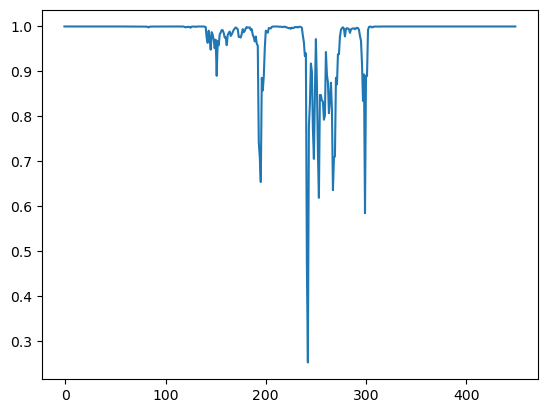

Min prediction for seq version (i=243): MEFIIKTQKNLEGTAATRIKEKLKNAETWITPEGYSGLIILKTTDKEATKKLQEIPEIERTLPIHYKTGSNLEKILEKAEKIAKHIKENETFAVKTKRRGKHNFTSPEINKKLGEKILQLTNATVNLNSPDKTIQIEIIGENTYISIRKKEKWKKYTPEKEDARKLFNKTTIIQMPYWGKPQIARKFGEKIGRAAQAYEIKELIIAPKEKMNAQEIAEFIKGVKKGQQSRYKIQKEAYPWPTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXIIILIGSREGIPRGLFKFADYIIDLTPYITFATEHVIPATLTTLYQLYSKEGQT
Patched subseq: KKVPISLWDIYQATRDKKRKKRTIIITDPKGKTINAIKENLQKDLRKSKE
==== Sequence patch results: ====
MSIFKYLQQLLVVSSMSGVDLIIKTRKEFERVAASHIKELLGPGAEAVSAPWGYLGIVFVKGLGADRWKAAELIAEKIPEVDRVLVVEEAVKADLPEIEKAAVEVARRYIQSGDTFAIRTTRRGRHGFTSIDVNVRVGAAVKEATGAEVDLEEPTKPLYIEIFQDTAAICVPATREYKKLRRDKPLPLQFFRKVAIGQLVYEGDEEAVRKMGERIGRAVQTFEVGELAVLLHKPMPSKSLGTFLEAVEAGIESRYQIQARSYGRPVWKVPVYVYELYQYIRSREGEPIVVTDPKGDYITHVKEELAQLFRRDRVNVLIGSREGIPTGVFRLASLVVDLVPEVTIATDFVVPSLAVALVSALEEAGALPRYVGKRRKH


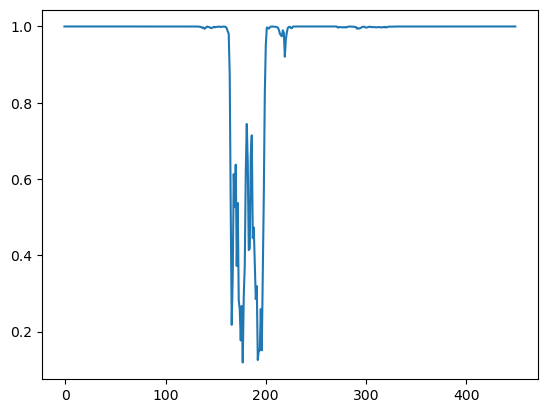

Min prediction for seq version (i=178): MSIFKYLQQLLVVSSMSGVDLIIKTRKEFERVAASHIKELLGPGAEAVSAPWGYLGIVFVKGLGADRWKAAELIAEKIPEVDRVLVVEEAVKADLPEIEKAAVEVARRYIQSGDTFAIRTTRRGRHGFTSIDVNVRVGAAVKEATGAEVDLEEPTKPLYIEIFQDTAAICVPATREYXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAVLLHKPMPSKSLGTFLEAVEAGIESRYQIQARSYGRPVWKVPVYVYELYQYIRSREGEPIVVTDPKGDYITHVKEELAQLFRRDRVNVLIGSREGIPTGVFRLASLVVDLVPEVTIATDFVVPSLAVALVSALEEAGALPRYVGKRRKH
Patched subseq: KKLRRDKPLPLQFFRKVAIGQLVYEGDEEAVRKMGERIGRAVQTFEVGEL
==== Sequence patch results: ====
MKFIVKTQMDMEAVAGNYIKEILPNAKVTTAPEGYPGIVIVEAEDENALQKILEVPEVEKVYPVLVEVPATLEDIKNSAEEIVRHINDGESFAVRTKKRGKKDFSSVDVNVVLGARIKDLKNVEVNLSYPDKVVQVEIIGDKAYISVIPGEEYMKWKKYPKEKPNCRKLFKKLTIVQMPYWGDYKTARAFGEKIGRAAQAFEVKELIIAPKEKMNAYELMAFIRGVKEGQESRYQIQREAYPWQVEKVPVTVWDLYQVIRDKRRNRRLIIITDPKGPTLNEVKDKLAKDMYYAKEVVVFIGSREGIPVGLFRFADYVVDLAPYMTFATEHGIPATLVALWTIYEEELRRRGEVAGED


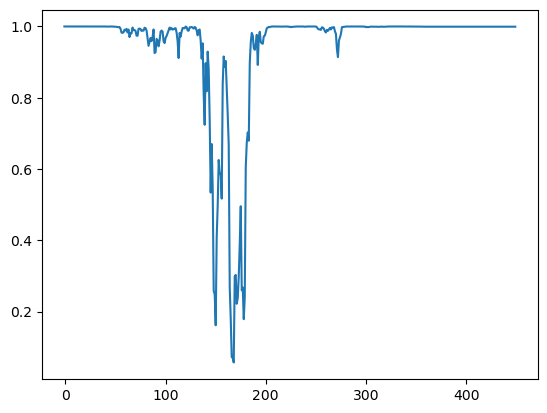

Min prediction for seq version (i=169): MKFIVKTQMDMEAVAGNYIKEILPNAKVTTAPEGYPGIVIVEAEDENALQKILEVPEVEKVYPVLVEVPATLEDIKNSAEEIVRHINDGESFAVRTKKRGKKDFSSVDVNVVLGARIKDLKNVEVNLSYPDKVVQVEIIGDKAYISVIPGEEYMKWKKYPKEKPNCRKXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXLMAFIRGVKEGQESRYQIQREAYPWQVEKVPVTVWDLYQVIRDKRRNRRLIIITDPKGPTLNEVKDKLAKDMYYAKEVVVFIGSREGIPVGLFRFADYVVDLAPYMTFATEHGIPATLVALWTIYEEELRRRGEVAGED
Patched subseq: LFKKLTIVQMPYWGDYKTARAFGEKIGRAAQAFEVKELIIAPKEKMNAYE
==== Sequence patch results: ====
MEKIVCSRIQENFEKTGNVVPKPSGFMGIVISEICGKKKEEIKEIPEVENVVPIVEEVSQPNLEKISKLCRKVAEELPDGSRFAVDADRRGTHEFTSQEIEAKAGSEIMKLVGSLEVELDRPDFVVKVEVIEQWAGVGILEGGEILRKKVGKADSRELTAKIHLVQLVYRGKDRRGIERIGVSLGRSAQAFETKKVTIVFDSPTDADKLQAFLNGIDEGIDSRFRIQKRVYERSMSRVPVDVYELYQFLRKIDGEEDLVIMTDPRGEVLQNSRNNLKEDLKSAETVYLFNGSNKGIPTGCFERADHVLDLAPHITYATDQAITASVIALLNL


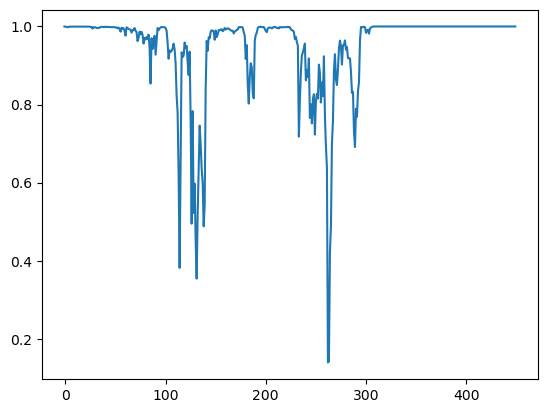

Min prediction for seq version (i=263): MEKIVCSRIQENFEKTGNVVPKPSGFMGIVISEICGKKKEEIKEIPEVENVVPIVEEVSQPNLEKISKLCRKVAEELPDGSRFAVDADRRGTHEFTSQEIEAKAGSEIMKLVGSLEVELDRPDFVVKVEVIEQWAGVGILEGGEILRKKVGKADSRELTAKIHLVQLVYRGKDRRGIERIGVSLGRSAQAFETKKVTIVFDSPTDADKLQAFLNGIDEGIDSRFRIQKRVYERSMSRVPVDVYELYQFLRKIDGEEDLVIMTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXHITYATDQAITASVIALLNL
Patched subseq: DPRGEVLQNSRNNLKEDLKSAETVYLFNGSNKGIPTGCFERADHVLDLAP
==== Sequence patch results: ====
MKFLVKTQKGMESVAGNYIREALPNAEVWASPMGYSGLVIVETNDENAEEKILEIPEVERVIPVLVETNAELGEIVKAANEIASLISKDETFAVKTKRRGKHDFSSIDVNRVLGAKIKELTDADVNLSWPDKVVQVEIIGDRAFISVLPGEEYRKYTPDKFDARKLLSKVTLVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFLRGIKTGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEKLARDMHYAKEVVIFIGSREGIPRGLFRFADYVIDLAPYMTFATEHGIPATLVSLWEVYEEFLRKSEEKAEAPS


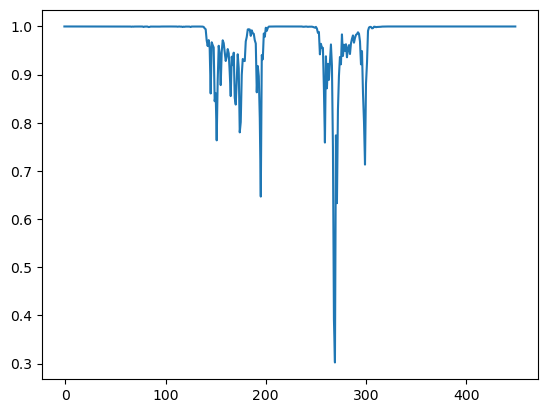

Min prediction for seq version (i=270): MKFLVKTQKGMESVAGNYIREALPNAEVWASPMGYSGLVIVETNDENAEEKILEIPEVERVIPVLVETNAELGEIVKAANEIASLISKDETFAVKTKRRGKHDFSSIDVNRVLGAKIKELTDADVNLSWPDKVVQVEIIGDRAFISVLPGEEYRKYTPDKFDARKLLSKVTLVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFLRGIKTGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXYMTFATEHGIPATLVSLWEVYEEFLRKSEEKAEAPS
Patched subseq: DPKGPTLAEVKEKLARDMHYAKEVVIFIGSREGIPRGLFRFADYVIDLAP
==== Sequence patch results: ====
MPCERVLAIVKTVLGMEEVAASVIEETVGVRCVAKPNGYPGIVLVCGDGERSEVVDRIRSEVPEAERVIPVEEWVPSDIDSIVEAAKRVVDGRIGADESFAVRTVRRGRRGYTSVDVNIRAGAVVKEVTGASVNLRYPDKIVQVEILGDHAAVSLLDGRMEWRKLRPGKPAVLDFIRKVAVAHIPYLGPPNASREMGVRVGREAQTFEVKELVVTPVGLTDADSLRHFLNGVFEGIRSRFEIQKRAYGRDVHKVQVHLQDIYGFVRERRREPIIVFEPEGEPVPKVADEIYKLLQARRRVNVMVGSRVGIPLGIYRFADLVVDLCPGVTIATDYALTAGVIAFANIIEAKLIGEEG


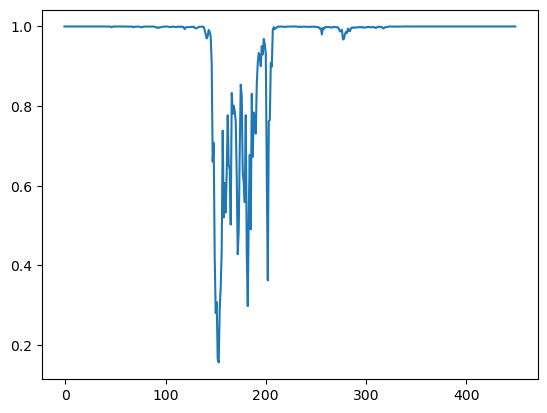

Min prediction for seq version (i=154): MPCERVLAIVKTVLGMEEVAASVIEETVGVRCVAKPNGYPGIVLVCGDGERSEVVDRIRSEVPEAERVIPVEEWVPSDIDSIVEAAKRVVDGRIGADESFAVRTVRRGRRGYTSVDVNIRAGAVVKEVTGASVNLRYPDKIVQVEILGDHAAVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAQTFEVKELVVTPVGLTDADSLRHFLNGVFEGIRSRFEIQKRAYGRDVHKVQVHLQDIYGFVRERRREPIIVFEPEGEPVPKVADEIYKLLQARRRVNVMVGSRVGIPLGIYRFADLVVDLCPGVTIATDYALTAGVIAFANIIEAKLIGEEG
Patched subseq: SLLDGRMEWRKLRPGKPAVLDFIRKVAVAHIPYLGPPNASREMGVRVGRE
==== Sequence patch results: ====
MKALPSRRFDLIVKTPIGLERIAASRIEDLGLEGEVHSRPSGYPGIVTVTLRREDDKTHIAERIEREVPEAERVLVSRMSTAATIEEITDAAVKVASGAIRDGDSFAVRTVRRGRHPYTSVDVNRTVGSAVLESTGASVNLDHPDKILWVEIIDDQAAIGIIDGSEVWRKMKPGKWEVRTFLSKASVIQMPYLGDEKSARSMGSRIGRAVQMFEVGEFVIATMGVCDARRLAWFMDGVFEGIDSRYRIQCRTYAHRPRRVEVLVQDVYQLVRDRRAEPKIIFEPEGEVFPKVSSKIADLFLKADRRINLLFGSREGIPKGLFRFADLIVDLCPGITLSTEYAASSALIGISFALHNLMEQLNE


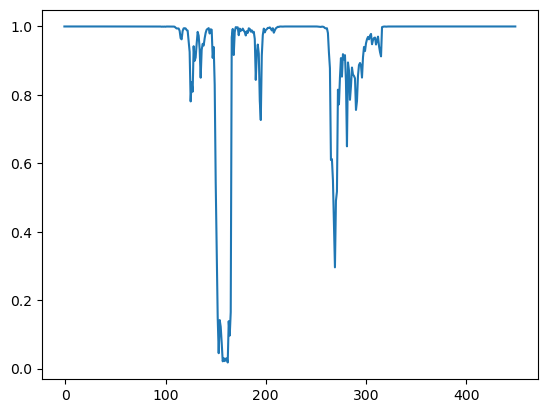

Min prediction for seq version (i=163): MKALPSRRFDLIVKTPIGLERIAASRIEDLGLEGEVHSRPSGYPGIVTVTLRREDDKTHIAERIEREVPEAERVLVSRMSTAATIEEITDAAVKVASGAIRDGDSFAVRTVRRGRHPYTSVDVNRTVGSAVLESTGASVNLDHPDKILWVEIIDDQAAIGIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXFEVGEFVIATMGVCDARRLAWFMDGVFEGIDSRYRIQCRTYAHRPRRVEVLVQDVYQLVRDRRAEPKIIFEPEGEVFPKVSSKIADLFLKADRRINLLFGSREGIPKGLFRFADLIVDLCPGITLSTEYAASSALIGISFALHNLMEQLNE
Patched subseq: DGSEVWRKMKPGKWEVRTFLSKASVIQMPYLGDEKSARSMGSRIGRAVQM
==== Sequence patch results: ====
MKFLVKTQRGMESVTANYIREALPDAEVWASPMGYSGLVIVETDDRSAEEKILEIPEVERAIKVLFEVPAELEAILSVAEDVAKLIRENETFAVKTKRRGKHDFSSLDVNAQLGAKIKELTNADVNLSWPDKVVQVEIIGDKAYISLLPGEEYRKFTPDKINARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVRELIIAPKEKMDAFELMEFIKGVRVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPSLAEVKDKLARDMYYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSMWEIYEEYSRTREGEE


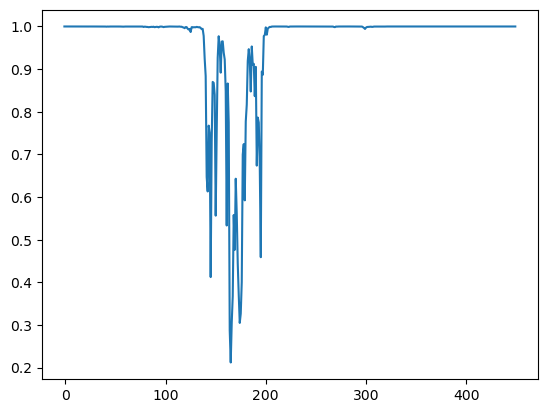

Min prediction for seq version (i=166): MKFLVKTQRGMESVTANYIREALPDAEVWASPMGYSGLVIVETDDRSAEEKILEIPEVERAIKVLFEVPAELEAILSVAEDVAKLIRENETFAVKTKRRGKHDFSSLDVNAQLGAKIKELTNADVNLSWPDKVVQVEIIGDKAYISLLPGEEYRKFTPDKINARKXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXLMEFIKGVRVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPSLAEVKDKLARDMYYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSMWEIYEEYSRTREGEE
Patched subseq: LFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVRELIIAPKEKMDAFE
==== Sequence patch results: ====
MKFIVKTQRGMESVAANYIKESLPDARVWASPMGYYGLVIVETDEEKAAGKILEIPEVERLIPVIVEVPAELEKIVESAEKLAPMIRESETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDKVVQVEIIGDRAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVRIGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKENLAKDMFYSKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREEKA


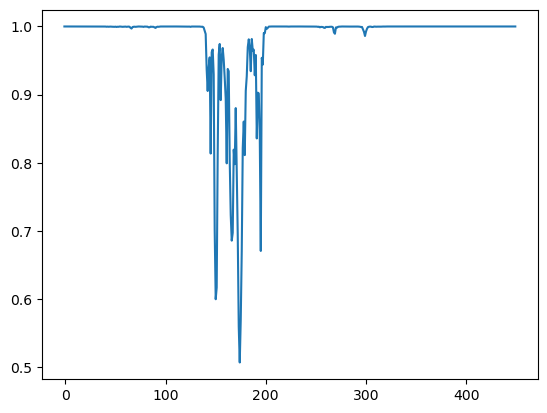

Min prediction for seq version (i=175): MKFIVKTQRGMESVAANYIKESLPDARVWASPMGYYGLVIVETDEEKAAGKILEIPEVERLIPVIVEVPAELEKIVESAEKLAPMIRESETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDKVVQVEIIGDRAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXIGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKENLAKDMFYSKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREEKA
Patched subseq: MPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVR
==== Sequence patch results: ====
MKFIVKTQRGMEGVAANYVKEALPDAKIWISPMGYSGLVIVEAGDEGAGERILEIPEVERIIPVLVEVPAELEAIVSSAEKIASLIGEDETFAVKTKRRGKHGFTSVDVNRELGARIRELTNSDVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGVRIGQESRHRIQREAYPWKVEKVPVSVWDLYQVVRDKRRPKRLLIITDPKGPTLAEVKADLARDAFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEIYEEYARNLEEGD


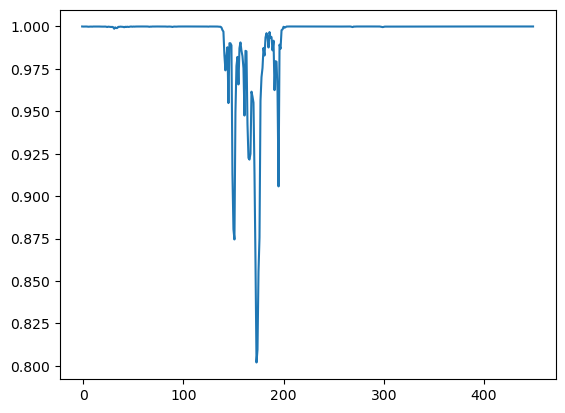

Min prediction for seq version (i=174): MKFIVKTQRGMEGVAANYVKEALPDAKIWISPMGYSGLVIVEAGDEGAGERILEIPEVERIIPVLVEVPAELEAIVSSAEKIASLIGEDETFAVKTKRRGKHGFTSVDVNRELGARIRELTNSDVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKIDARKLFRKVTLVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXRIGQESRHRIQREAYPWKVEKVPVSVWDLYQVVRDKRRPKRLLIITDPKGPTLAEVKADLARDAFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEIYEEYARNLEEGD
Patched subseq: QMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGV
==== Sequence patch results: ====
MKFIVKTQRGMEGVAANYIREALPNSKVQASPLGYYGLVIVESDDENAVEKILEIPEVERVIPVLVEVPAEIEEIVNAAENVAPFIGENETFAVKTKRRGKHGFSSLDVNRSLGAKVQELTGADVNLSWPDKVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARELFRKLTVVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRAKRLLIITDPKGPTLAEVKDNLARDMFHAKEIIVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRSREKE


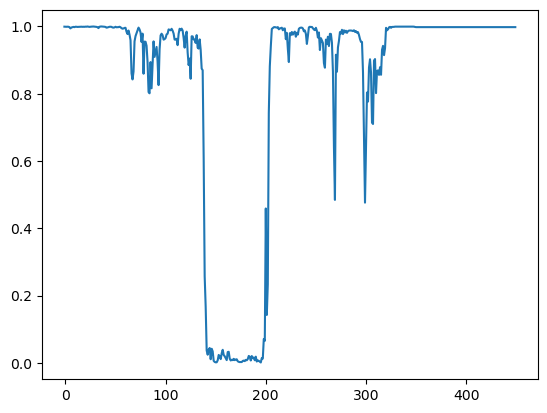

Min prediction for seq version (i=196): MKFIVKTQRGMEGVAANYIREALPNSKVQASPLGYYGLVIVESDDENAVEKILEIPEVERVIPVLVEVPAEIEEIVNAAENVAPFIGENETFAVKTKRRGKHGFSSLDVNRSLGAKVQELTGADVNLSWPDKVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARELFRKLTVVQMPYWGDYKACRSFGEKIGRAAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPVSVWDLYQVVRDKRRAKRLLIITDPKGPTLAEVKDNLARDMFHAKEIIVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRSREKE
Patched subseq: QAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKV
==== Sequence patch results: ====
MKFIVKTQRGLEGVAAGYIRETLPDAEVWASPMGYSGLVIVESEDGNAAERILEIPEVERAIPVLVEVPAELEAIVDTAGKIAPLIKEEETFAVRTKRRGKHDFSSVDVNRELGARIRELTNSDVNLSWPDRVVQVEIIGDRAYVSLLPGEEFRKFTPGKIDARKLFQKVVLVQMPYWGDYRACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGVKIGQESRHRIQSEAYPWKVEKVPVSLWDLYQVVRDKRRKKRLLIITDPKGPTLAGVKDELARDLFHSKEVVIFIGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRKKP


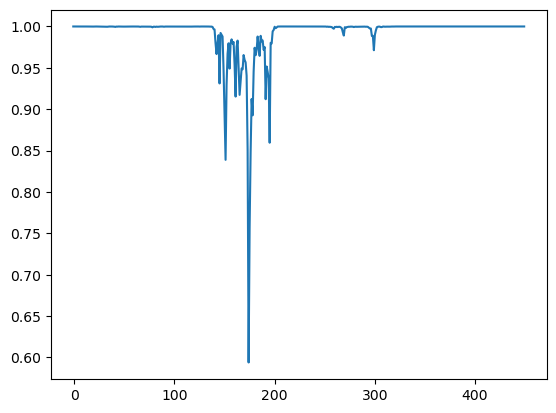

Min prediction for seq version (i=175): MKFIVKTQRGLEGVAAGYIRETLPDAEVWASPMGYSGLVIVESEDGNAAERILEIPEVERAIPVLVEVPAELEAIVDTAGKIAPLIKEEETFAVRTKRRGKHDFSSVDVNRELGARIRELTNSDVNLSWPDRVVQVEIIGDRAYVSLLPGEEFRKFTPGKIDARKLFQKVVLVQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXIGQESRHRIQSEAYPWKVEKVPVSLWDLYQVVRDKRRKKRLLIITDPKGPTLAGVKDELARDLFHSKEVVIFIGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRKKP
Patched subseq: MPYWGDYRACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGVK
==== Sequence patch results: ====
MVWIEIFHDEAFISITSGSEERKKSYPGKPNLRQVPKRIVIGQVPYVGDIEAVRRMGIRIGRAAQTFEIKSLYVTPFRPLEGFILKTFLDGVYEGIKSRYEIQKKAYSVKPHRVPVYVYDLYQFVRLKCDKPIIVTSTRGKPLVTVKDSIIDLFSKHKEIIILIGAHEGLPTGLFRAAELVIDLAPGITISTDNALTSAVIGLVTVLEESKIG


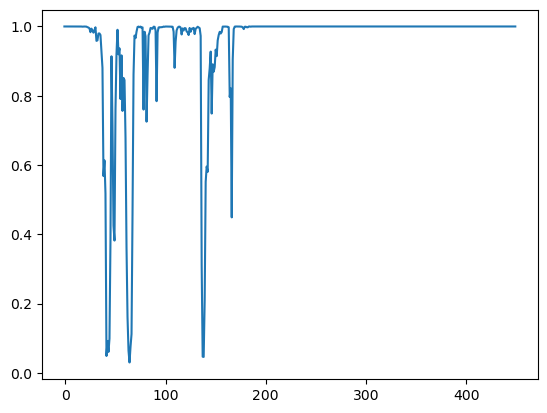

Min prediction for seq version (i=65): MVWIEIFHDEAFISITSGSEERKKSYPGKPNLRQVPKRIVIGQVPYVGDIEAVRRMGIRIGRAAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPVYVYDLYQFVRLKCDKPIIVTSTRGKPLVTVKDSIIDLFSKHKEIIILIGAHEGLPTGLFRAAELVIDLAPGITISTDNALTSAVIGLVTVLEESKIG
Patched subseq: QTFEIKSLYVTPFRPLEGFILKTFLDGVYEGIKSRYEIQKKAYSVKPHRV
==== Sequence patch results: ====
MMEKTTIIVKTHKNLERIAASYIRDLIPDSEVLVKPNGYAGIILLKVKSVDAQTLKTTLITIPEIEKILFVRKCVEANLDRICEAVRHLARVSLKENEKFAVHTVRRGNHPFTSIDVNIKVGTCIQQETQCKVDLTLPDKIFWIEIIDNKAYISIVSRDIFYRKKTPDKLDNMKYLKKTIIVQMPYLDEIASSKIGVRIGRIVQSYEIPSIIVAPIYRVNAKELMYFLQGIHEGIMSRYKLQLKTYNDRKVSKTRVYLHDLYQLVRNINRDKEGIIITTTKGQPIKEETITKVKSLYMDKKKVYVFIGSREGIPTGLFKFADILLDVAPQITLATDVAVSSIISAILNMLLL


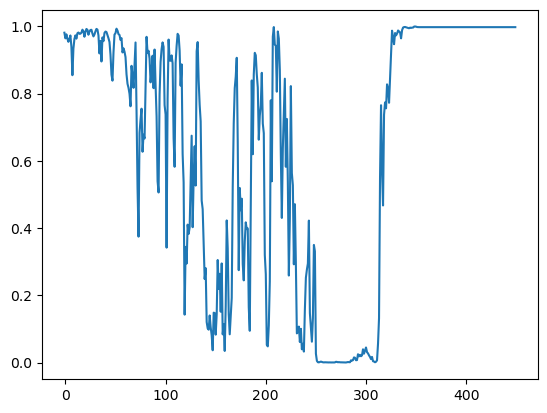

Min prediction for seq version (i=281): MMEKTTIIVKTHKNLERIAASYIRDLIPDSEVLVKPNGYAGIILLKVKSVDAQTLKTTLITIPEIEKILFVRKCVEANLDRICEAVRHLARVSLKENEKFAVHTVRRGNHPFTSIDVNIKVGTCIQQETQCKVDLTLPDKIFWIEIIDNKAYISIVSRDIFYRKKTPDKLDNMKYLKKTIIVQMPYLDEIASSKIGVRIGRIVQSYEIPSIIVAPIYRVNAKELMYFLQGIHEGIMSRYKLQLKTYNDRKVSKTRVYLHDLYQLVRNINRDKEGIIITTTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXITLATDVAVSSIISAILNMLLL
Patched subseq: KGQPIKEETITKVKSLYMDKKKVYVFIGSREGIPTGLFKFADILLDVAPQ
==== Sequence patch results: ====
MLLVKTQRGLEYIAASYIKDELGDVKLEVRPGGFLGLILVYSDELEKIKGIPEIETIIPILIECKADLDDIISHAGSIAEEIKGARTFAIRTKRRGRHDFSSIDVNFKLGDKIREITGCEVNLNFPEKAIYVEIIGDRTFIGVIEGKEERKKYTPEKLDSRELFHKISVVQVPYLDDLRAALEIGERIGRAAQAFEIKELIIAPFDSVNAFELEQFIKGVRRGQLTRYKIQERAYSREVKKVPILLQDLYQVARDKKRRRNLLIVTDPTGKQISDIKDEIGKGLIYSDEIVVFIGSRVGIPKGIFRFADFIIDLTPYITFATEQAIPSVLTALLTIYEEFRNKN


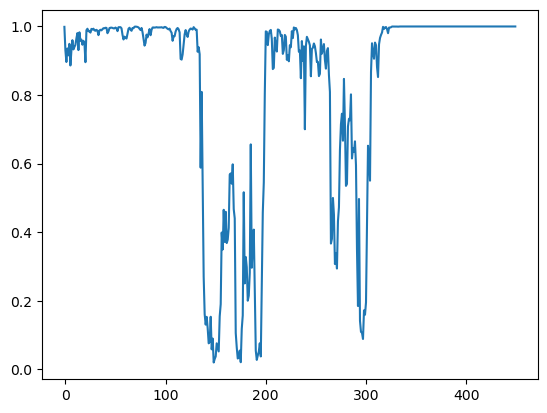

Min prediction for seq version (i=149): MLLVKTQRGLEYIAASYIKDELGDVKLEVRPGGFLGLILVYSDELEKIKGIPEIETIIPILIECKADLDDIISHAGSIAEEIKGARTFAIRTKRRGRHDFSSIDVNFKLGDKIREITGCEVNLNFPEKAIYVEIIGDRTFIGVIEGKEXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXELIIAPFDSVNAFELEQFIKGVRRGQLTRYKIQERAYSREVKKVPILLQDLYQVARDKKRRRNLLIVTDPTGKQISDIKDEIGKGLIYSDEIVVFIGSRVGIPKGIFRFADFIIDLTPYITFATEQAIPSVLTALLTIYEEFRNKN
Patched subseq: ERKKYTPEKLDSRELFHKISVVQVPYLDDLRAALEIGERIGRAAQAFEIK
==== Sequence patch results: ====
MKTVLGFENIVKNRIKEIDPSADVLVAPKGFKGLVLAGSNAFDKDKFVKVLNKELIEAEKIIPIDLIVRADPNEICKGISGFVNEKISSDETFAVRTTRRGRHKFTSIDVNIIVGDCVRKYTGASVNLRYPDKIVLVEIIGEEAYISILPGSFEYHKYAPEKKELYRFFNKLSIIQMPYLGPIESVIEIGKRIGREVQNFEVKELVIAPIGLVDAYSLARFIDSVMEGIESRYRVQVKSYHRKPRKTPVYIMDLYQLIRDRGDEVIIVFEPEGRYIVDVKDELEELVLKSRKRINLLFGAREGIPTGIFRYADLVIDIAPGMVLSTDYAVAAGLIALSTILYDKYRSMDHESINTSGR


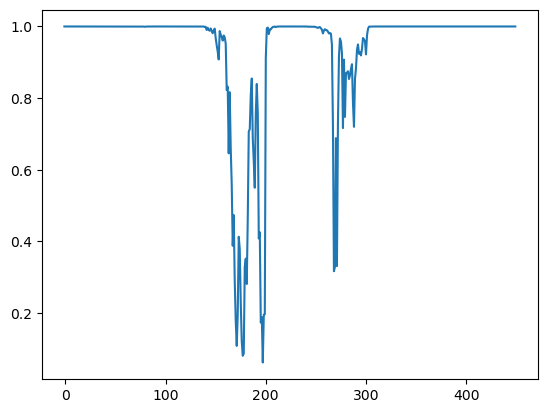

Min prediction for seq version (i=198): MKTVLGFENIVKNRIKEIDPSADVLVAPKGFKGLVLAGSNAFDKDKFVKVLNKELIEAEKIIPIDLIVRADPNEICKGISGFVNEKISSDETFAVRTTRRGRHKFTSIDVNIIVGDCVRKYTGASVNLRYPDKIVLVEIIGEEAYISILPGSFEYHKYAPEKKELYRFFNKLSIIQMPYLGPIESVIEIGKRIGREVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPVYIMDLYQLIRDRGDEVIIVFEPEGRYIVDVKDELEELVLKSRKRINLLFGAREGIPTGIFRYADLVIDIAPGMVLSTDYAVAAGLIALSTILYDKYRSMDHESINTSGR
Patched subseq: QNFEVKELVIAPIGLVDAYSLARFIDSVMEGIESRYRVQVKSYHRKPRKT
==== Sequence patch results: ====
MERVCASYIKDLNPKLEVVSAPKGFSGLVLVGGADDKYELARLIKERVPEADKVLIIEGVAKAEIPSIAEEVTKIIKDKISPDETFAVRTVRRGSHEFTSIDVNVAVGAKVKEVTGASVNLEFPDKVVAVEIIGGDAYISIIDGKELWRKKGPTKRPMYRLFRRFSIIHEPYLGPLDACRTMGIRIGREAQTFEVDELIIAPKGPVKALELKTFIEGVLEGIETRYQVQVKAYGRDVHKVRVYVQDMYQVVRDRSNEVLIVLEPEGKPVSQCIDELEELILRRRKRINLFIGAREGVPLGIYRFANLVLDIAPGITIATDYALSSALIAIATLIHDKFSEEW


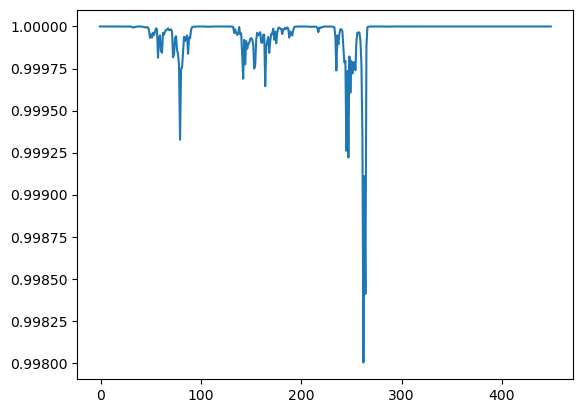

Min prediction for seq version (i=263): MERVCASYIKDLNPKLEVVSAPKGFSGLVLVGGADDKYELARLIKERVPEADKVLIIEGVAKAEIPSIAEEVTKIIKDKISPDETFAVRTVRRGSHEFTSIDVNVAVGAKVKEVTGASVNLEFPDKVVAVEIIGGDAYISIIDGKELWRKKGPTKRPMYRLFRRFSIIHEPYLGPLDACRTMGIRIGREAQTFEVDELIIAPKGPVKALELKTFIEGVLEGIETRYQVQVKAYGRDVHKVRVYVQDMYQVVRDRSNEVLIVLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPGITIATDYALSSALIAIATLIHDKFSEEW
Patched subseq: EPEGKPVSQCIDELEELILRRRKRINLFIGAREGVPLGIYRFANLVLDIA
==== Sequence patch results: ====
MKTPLGLERIVASRAAELIGGHVVARPRGFMGLVVIDGLEDPDEAARRIEEALPEAEYVLRVLATARADLDEIASSAAHVARDLIRPDETFAVRTTRRGKHDFTSIDANVKVGSAVQEATGADVNLTEPDKIVWVEFIGPEVGIAITPGQVVWKKHRPGKPEVLRLLKRISFAQMPYLGEGGRPMGVRIGRAAQAFELSELVITPHEPVDVGQLNAFLSGLLEGRESRFKIQKKTYARKVDKVPFRLQDLYQFVRDRAGEPMIVTDPTGKTVSEAAEDIEEAFRQGGRVNILAGAREGVPKGVFRFATLIIDLCPGLTFATEHTIPATVGALITCLEERGLIRQ


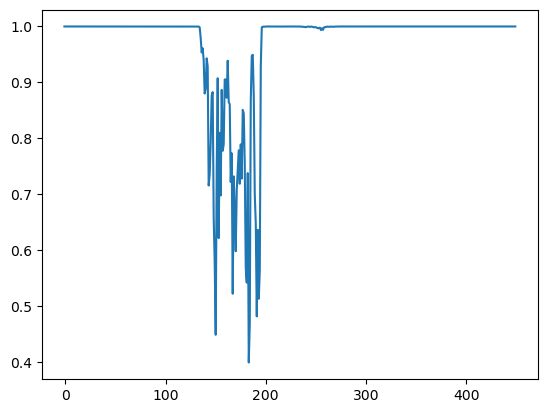

Min prediction for seq version (i=184): MKTPLGLERIVASRAAELIGGHVVARPRGFMGLVVIDGLEDPDEAARRIEEALPEAEYVLRVLATARADLDEIASSAAHVARDLIRPDETFAVRTTRRGKHDFTSIDANVKVGSAVQEATGADVNLTEPDKIVWVEFIGPEVGIAITPGQVVWKKHRPGKPEVLRLLKRISFAQMPYLGEGGRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXKTYARKVDKVPFRLQDLYQFVRDRAGEPMIVTDPTGKTVSEAAEDIEEAFRQGGRVNILAGAREGVPKGVFRFATLIIDLCPGLTFATEHTIPATVGALITCLEERGLIRQ
Patched subseq: PMGVRIGRAAQAFELSELVITPHEPVDVGQLNAFLSGLLEGRESRFKIQK
==== Sequence patch results: ====
MVDLIVKTVKGLERVAAARIKEALGNEVLVKARPLGFLGIVTVEGVRDKEEAKRIVESKVPEVERALVILGECKADLNEIAEVAKRLIRDRLSEAETFAVRTVRRGSHTFTSIDVNVRVGATVKEVTGADVNLSEPDKTIQVEIIGDKAYISLIEGTLELKKVRPGKPKIAPFLRRITVVQVPYLGDREASYKMGVRIGRGLQTFEIGGLYIAPFEPVPVEELEAFLQGVIEGRESRYRIQRRAYAREPFKVPIYLYDLYQYVRNKGSKEVIIATSTSGDPVWEALSKLEKALKGADKISILVGSRKGLPRGVFRFSDAVIDVAPSITLPTDYAAVAIIMAIVTVLEGRDFFDKY


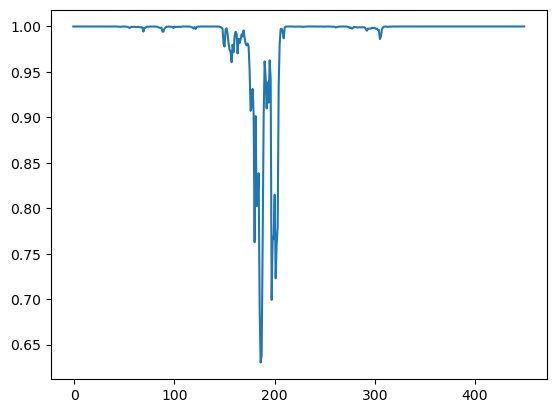

Min prediction for seq version (i=187): MVDLIVKTVKGLERVAAARIKEALGNEVLVKARPLGFLGIVTVEGVRDKEEAKRIVESKVPEVERALVILGECKADLNEIAEVAKRLIRDRLSEAETFAVRTVRRGSHTFTSIDVNVRVGATVKEVTGADVNLSEPDKTIQVEIIGDKAYISLIEGTLELKKVRPGKPKIAPFLRRITVVQVPYLGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXRYRIQRRAYAREPFKVPIYLYDLYQYVRNKGSKEVIIATSTSGDPVWEALSKLEKALKGADKISILVGSRKGLPRGVFRFSDAVIDVAPSITLPTDYAAVAIIMAIVTVLEGRDFFDKY
Patched subseq: DREASYKMGVRIGRGLQTFEIGGLYIAPFEPVPVEELEAFLQGVIEGRES
==== Sequence patch results: ====
MEVLPGAKVVPRPQGFKGLVAVYSDNPRRDAEEIKAKVLEAEHVIPADAVVEARLGKIVEAARSVVQGRIGRDETFAVRTVRRGRHDYTSIDVNVKVGAAVKEATGAGVNLDYPDKIVCVEIIGDTAIISVLPGSEEYKKMRPGKKPILKYLHRIALVQMPYLGPLDAAYNMGVRVGREAQNFEVKELVIAPIGLTPADQLQKFIEGVYQGIESRYAVQKKIYARPVKRVPVYVEDLYQLVRDRFDEPIIIFEPEGEPVIKMAREIFEVFEGGHGRINILVGSREGTPVGLYRFARMVLDIAPEVTISTDLAAASAITALITVLEGERP


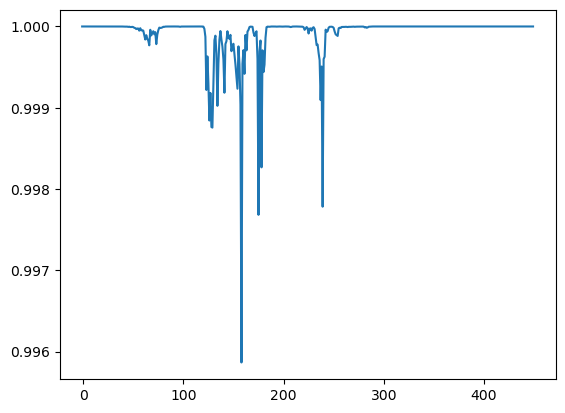

Min prediction for seq version (i=159): MEVLPGAKVVPRPQGFKGLVAVYSDNPRRDAEEIKAKVLEAEHVIPADAVVEARLGKIVEAARSVVQGRIGRDETFAVRTVRRGRHDYTSIDVNVKVGAAVKEATGAGVNLDYPDKIVCVEIIGDTAIISVLPGSEEYKKMRPGKKPILKYLHRIALVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXYQGIESRYAVQKKIYARPVKRVPVYVEDLYQLVRDRFDEPIIIFEPEGEPVIKMAREIFEVFEGGHGRINILVGSREGTPVGLYRFARMVLDIAPEVTISTDLAAASAITALITVLEGERP
Patched subseq: QMPYLGPLDAAYNMGVRVGREAQNFEVKELVIAPIGLTPADQLQKFIEGV
==== Sequence patch results: ====
MGLVLEILVKTPLGLEEVCASRIAELDPGAEVVVRPGGYVGLVGVVRCSDPDSLYQRILSEVLESESAYRVVASAKAASLEDIAEAAVRAARGRLDSGKSFAVRTVRRGRHSFTSLDVNVAVGAAIQREYSSLVDLDHPDMVVRVEIIDDAAYLSVYEGGREWVKMGPGKREAWGFFSKISVVQMPYIGPPKSCREMGARIGRAVQAFEVGEVVVAPAEPVEARSLAEFILGILEGQESRLEVQSRAYARRPRRVEVLVQDLYQLVRARRGEPIIVFEPEGVELSRASERLSELYRSARRVNFLFGAREGIPKGVYRVADLVVDLAPAMTLPTELAAPTALLAVYTALRVAGGGGVDEV


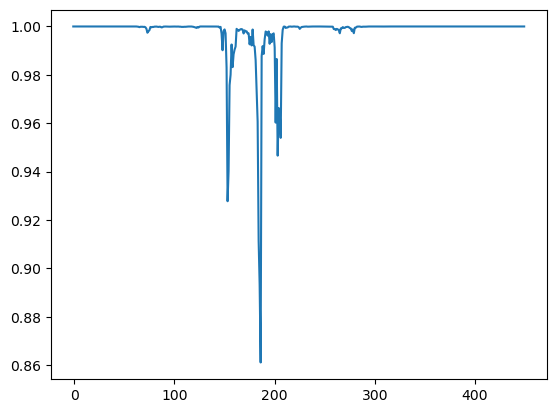

Min prediction for seq version (i=187): MGLVLEILVKTPLGLEEVCASRIAELDPGAEVVVRPGGYVGLVGVVRCSDPDSLYQRILSEVLESESAYRVVASAKAASLEDIAEAAVRAARGRLDSGKSFAVRTVRRGRHSFTSLDVNVAVGAAIQREYSSLVDLDHPDMVVRVEIIDDAAYLSVYEGGREWVKMGPGKREAWGFFSKISVVQMPXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXQESRLEVQSRAYARRPRRVEVLVQDLYQLVRARRGEPIIVFEPEGVELSRASERLSELYRSARRVNFLFGAREGIPKGVYRVADLVVDLAPAMTLPTELAAPTALLAVYTALRVAGGGGVDEV
Patched subseq: YIGPPKSCREMGARIGRAVQAFEVGEVVVAPAEPVEARSLAEFILGILEG
==== Sequence patch results: ====
MGGVETERYGALDLIVKTPLGLERIAASRIEELGVECHVHPKPHGFLGLVIVSGVPEDRKWELAERIKNEVPEVERVLVSEESVKADLDAIVESAVRVSSRFLDKDTSFAVRTVRRGKHPYTSIDVNCRVGSAIVEALESPVDLESPDKIVWIEIVGESAAVGVIDGKDVWRKMGPEKVDLRRFFSKVSVVQTPYFGPKNAIKTVSSRVGRAVQMFEVGEFVIATVGAVDAKQLELFIQGVLEGIESRYSVQKRIYAYKPRRVKVLVQDLYQLVRDRRGEPKVVFEPEGEPFPKAAGKLADILTSSEARVNLLFGSREGIPKGVFRFADLIVDLCPGITLSTEYAASSALIGLAFAVEEKATHT


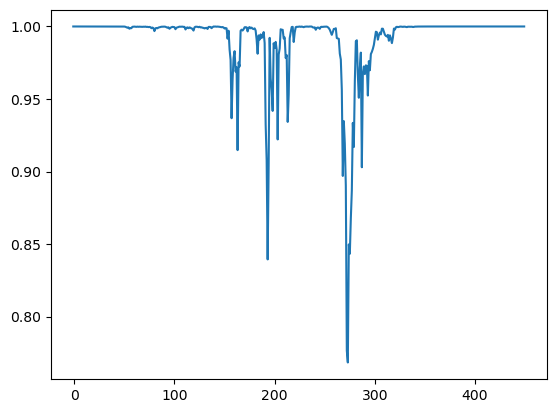

Min prediction for seq version (i=274): MGGVETERYGALDLIVKTPLGLERIAASRIEELGVECHVHPKPHGFLGLVIVSGVPEDRKWELAERIKNEVPEVERVLVSEESVKADLDAIVESAVRVSSRFLDKDTSFAVRTVRRGKHPYTSIDVNCRVGSAIVEALESPVDLESPDKIVWIEIVGESAAVGVIDGKDVWRKMGPEKVDLRRFFSKVSVVQTPYFGPKNAIKTVSSRVGRAVQMFEVGEFVIATVGAVDAKQLELFIQGVLEGIESRYSVQKRIYAYKPRRVKVLVQDLYQLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXVFRFADLIVDLCPGITLSTEYAASSALIGLAFAVEEKATHT
Patched subseq: VRDRRGEPKVVFEPEGEPFPKAAGKLADILTSSEARVNLLFGSREGIPKG
==== Sequence patch results: ====
MGATGFTPTSTGQTASFSQQSQGQFKSPHAIRGCVVVELKPCLVVTTHLGLERVAASRIKEEFGVEAEPMPGGFQGLIIVYCQGFDVDLLTKELSSRVVEAERVLPIYRAVKADLEEICEAVRSLAPQVLGESESFAVRTERRGHHSFTSIDVNVKAGACVQSVRGNPVDLENPDKIFWVEVLGDTAYVSVTPGSVVFRKSYDRKPNVLVHLRKIVIGQVPYLADAEASYKVGVRIGRAVQSFEVKELVITPYTPVDARPLAGFIRGVLEGIDSRYSIQTRSYSRKVHRVPVNLFDLYQLVRDYRERNIPIIATSTKGRYVGEVKRDVRRIFENSDKVLVLIGSREGLPTGVLRFSDLVIDVLPGVTLATDVAAPSILTAIAGVLAEESND


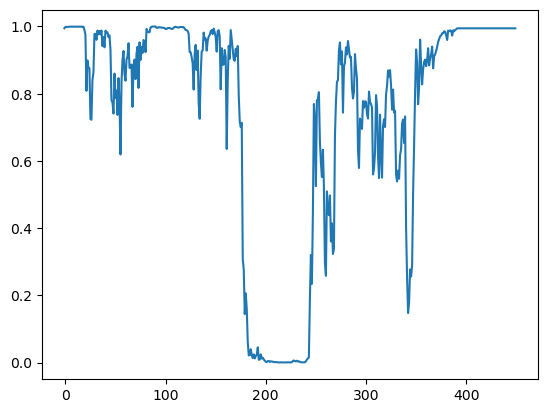

Min prediction for seq version (i=225): MGATGFTPTSTGQTASFSQQSQGQFKSPHAIRGCVVVELKPCLVVTTHLGLERVAASRIKEEFGVEAEPMPGGFQGLIIVYCQGFDVDLLTKELSSRVVEAERVLPIYRAVKADLEEICEAVRSLAPQVLGESESFAVRTERRGHHSFTSIDVNVKAGACVQSVRGNPVDLENPDKIFWVEVLGDTAYVSVTPGSVVFRKSYDRKPNVLVHLRKIVIGQVPYLAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXRYSIQTRSYSRKVHRVPVNLFDLYQLVRDYRERNIPIIATSTKGRYVGEVKRDVRRIFENSDKVLVLIGSREGLPTGVLRFSDLVIDVLPGVTLATDVAAPSILTAIAGVLAEESND
Patched subseq: DAEASYKVGVRIGRAVQSFEVKELVITPYTPVDARPLAGFIRGVLEGIDS
==== Sequence patch results: ====
MRLLVTTRTGNEYLAARILEDRFHAIEDTDARPTGLKGLVILEAREGIEADEVGEVSEVEKVIEIDRELEDPQVREIAKAAGEVAAELPDGTRFAVRCTRRGSHDFTSQDVERLAGAAVLDRDEEHEVDLDDPDHVLRVEIINDWTGIGLVAGEDIHKKYVGKPDARRLTKKTTIVQRMYESQHPRGTNRIGAALGRSAQAFEVDRLVVGMAEPAEADDLDRFVDALQEGIGSRHEVQKKAYEQQRDRVPVEVADLHQMARRAKGSGALVVATDPRGETVADVRDELGTDLREADEIYVFNGSNEALPTGMFSHADHVLDLAPSITYGTDQAIAASLVALLTAWKPPEG


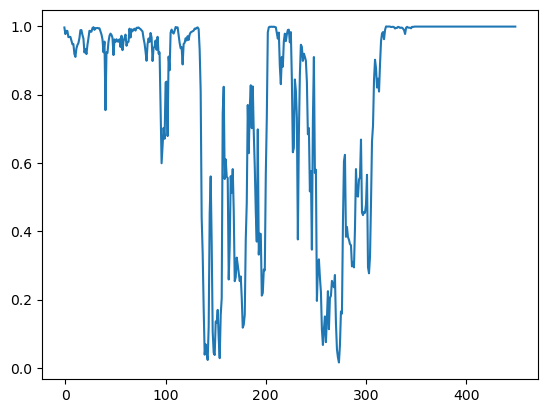

Min prediction for seq version (i=274): MRLLVTTRTGNEYLAARILEDRFHAIEDTDARPTGLKGLVILEAREGIEADEVGEVSEVEKVIEIDRELEDPQVREIAKAAGEVAAELPDGTRFAVRCTRRGSHDFTSQDVERLAGAAVLDRDEEHEVDLDDPDHVLRVEIINDWTGIGLVAGEDIHKKYVGKPDARRLTKKTTIVQRMYESQHPRGTNRIGAALGRSAQAFEVDRLVVGMAEPAEADDLDRFVDALQEGIGSRHEVQKKAYEQQRDRVPVEVADLHQMARRAKGSGALVVATXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXSITYGTDQAIAASLVALLTAWKPPEG
Patched subseq: DPRGETVADVRDELGTDLREADEIYVFNGSNEALPTGMFSHADHVLDLAP
==== Sequence patch results: ====
MELILKTPIGLEKIAADRLIEMDREISLSVKPHGLEGLIVVERCSDKQALVNYILKNVPEVESLVNVEVETEANLKSIVDAARKVSRGKISEKESFAVRTVRRGRHDFKSIDVNVAAGAAVQEETGAYVNLDHPDKIVQIEIIHDRAGISVTNGFRWKKMSPDKKPALNFFNKISIVQMPYLGSLEGAKEVGARIGRAVQAYEVRELVIAPNKPVDAYELNKFIDGVIEGIESRFRIQCKSYDRKVEKVRVSVQDLYQLVRDRSGEPMIVFEPEGIQLIEAATKLRKIFEEADRVNYLFGSREGIPKGVYRVASMVIDLAPGITLPTELAAPTALASTYTVISMIEQNIEDN


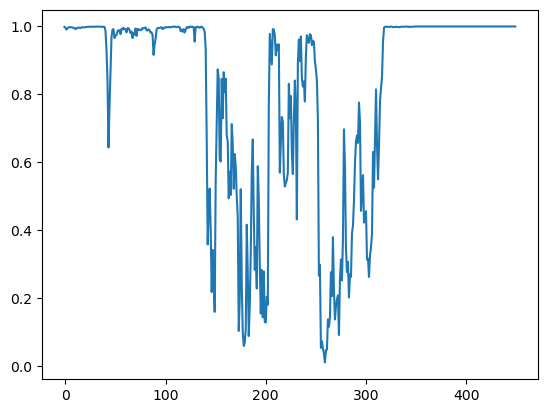

Min prediction for seq version (i=260): MELILKTPIGLEKIAADRLIEMDREISLSVKPHGLEGLIVVERCSDKQALVNYILKNVPEVESLVNVEVETEANLKSIVDAARKVSRGKISEKESFAVRTVRRGRHDFKSIDVNVAAGAAVQEETGAYVNLDHPDKIVQIEIIHDRAGISVTNGFRWKKMSPDKKPALNFFNKISIVQMPYLGSLEGAKEVGARIGRAVQAYEVRELVIAPNKPVDAYELNKFIDGVIEGIESRFRIQCKSYDRKVEKVRVSVQDLYQLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXYRVASMVIDLAPGITLPTELAAPTALASTYTVISMIEQNIEDN
Patched subseq: VRDRSGEPMIVFEPEGIQLIEAATKLRKIFEEADRVNYLFGSREGIPKGV
==== Sequence patch results: ====
MAAQWQYLATAPRDKAHIVASRLRECFPQAQLVPEPSGYWGLVWLGSDRELPTATMRAIPELEQAIAIEAEVAPPDCAAIAATCARAAERLPEGATFAVRATRRGQHAFTSRDVKIAAGAAVLDASRTLSVDLSAPDFVIRVELVGDWAGIGLLEGSCVRPKKRGKADSRQLTQKLTLVQLAYESEDLRGTRRMGESLGRSVQAFELAQLIVVVDSPVSARSLRTLLDGIEEGRESRFSLQKRTYGHRVRQVPLVVYELYQLLRDAAEAPTLTVATDPRGQTLPAVAQELAGELESAPAVYALNGSNEGIPPGCFELADYTLDLAPQMTYGTDQAIAATTIALLDVWHGHPARASRS


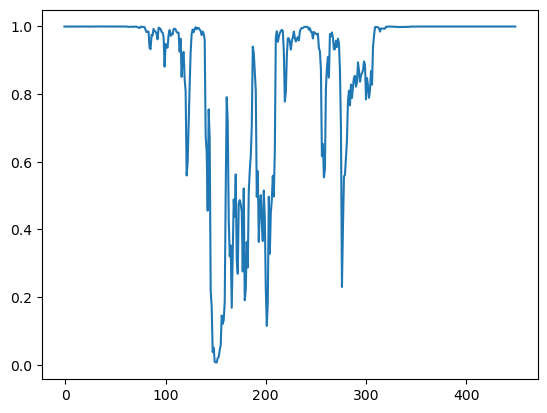

Min prediction for seq version (i=152): MAAQWQYLATAPRDKAHIVASRLRECFPQAQLVPEPSGYWGLVWLGSDRELPTATMRAIPELEQAIAIEAEVAPPDCAAIAATCARAAERLPEGATFAVRATRRGQHAFTSRDVKIAAGAAVLDASRTLSVDLSAPDFVIRVELVGDWAGIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXVQAFELAQLIVVVDSPVSARSLRTLLDGIEEGRESRFSLQKRTYGHRVRQVPLVVYELYQLLRDAAEAPTLTVATDPRGQTLPAVAQELAGELESAPAVYALNGSNEGIPPGCFELADYTLDLAPQMTYGTDQAIAATTIALLDVWHGHPARASRS
Patched subseq: GLLEGSCVRPKKRGKADSRQLTQKLTLVQLAYESEDLRGTRRMGESLGRS
==== Sequence patch results: ====
MKFIIKTQRGMESVAANYIREALPDASVWASPMGYSGLVIVETTDENAGEKVLEIPEVERIIPVIVEVPAELEKIVESAERLAPLIGEEETFAVKTKRRGKHGFTSMDVNRELGARIRELTGADVNLSWPDKVVQVEIIGDKAYISVLPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIRGIKVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRSKRLLIITDPKGPTLAEVKEHIARDMFYAKEIVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARRREEKA


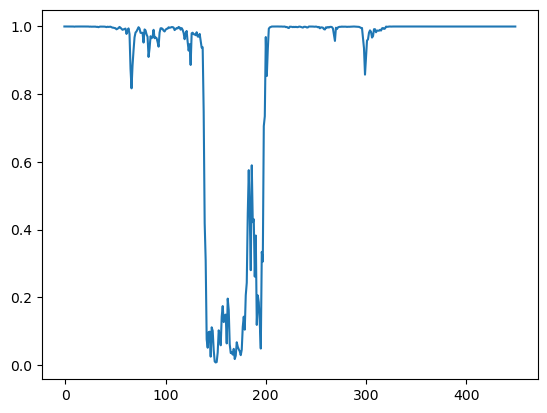

Min prediction for seq version (i=151): MKFIIKTQRGMESVAANYIREALPDASVWASPMGYSGLVIVETTDENAGEKVLEIPEVERIIPVIVEVPAELEKIVESAERLAPLIGEEETFAVKTKRRGKHGFTSMDVNRELGARIRELTGADVNLSWPDKVVQVEIIGDKAYISVLPGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXKELIIAPKEKMDAFELAEFIRGIKVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRSKRLLIITDPKGPTLAEVKEHIARDMFYAKEIVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARRREEKA
Patched subseq: EEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEV
==== Sequence patch results: ====
MGSRKFLVKTQRGMEGVAANYIRESLSDAEVLASPFGYYGLVIVESGDEDAEKKILDIPEVERVLPVLAEVPADLEAIVTTAEKIAPLIGEDETFAVKTKRRGKHGFSSLDVNRALGARIQELTNADVNLSWPDKVVQVEIIGDKAYISVIPGEEFRKFTPDKVDARKLFHRLTIVQMPYWGDYKACRTFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVRVGQESRYRIQKDAYPWKVEKVPVSVWDLYQVIRDKRRGKRLLIITDPKGPTLAQVKEELARDMYKAKEVVVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLKNKD


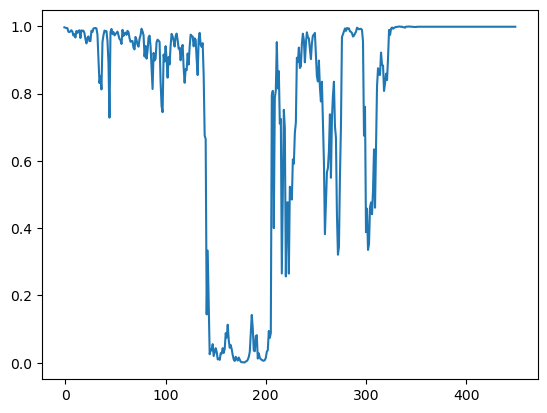

Min prediction for seq version (i=179): MGSRKFLVKTQRGMEGVAANYIRESLSDAEVLASPFGYYGLVIVESGDEDAEKKILDIPEVERVLPVLAEVPADLEAIVTTAEKIAPLIGEDETFAVKTKRRGKHGFSSLDVNRALGARIQELTNADVNLSWPDKVVQVEIIGDKAYISVIPGEEFRKFTPDKVDARKLFHRLTIVQMXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGQESRYRIQKDAYPWKVEKVPVSVWDLYQVIRDKRRGKRLLIITDPKGPTLAQVKEELARDMYKAKEVVVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLKNKD
Patched subseq: PYWGDYKACRTFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVRV
==== Sequence patch results: ====
MGKKFIVKTQRGMESVAANYIKEALSNAEVWTSPMGYSGLVLVESEDETALEKIQEIPEVERVIPVLAEVPAVLDEIVKTAELVAPMIGENETFAVKTKRRGKHDFSSIDVNRALGARIQELTKADVNLSWPDKVVQVEIIGDRAYVSVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYRACRSFGEKIGRAAQAFEVRELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQMEAYPWKVEKVPISVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVGKKLARDMHYAKEVVIFIGSREGIPRGLFRFADYVVDLAPYLTFATEHGIPAALVSLWEVYEEFLREGEEDSE


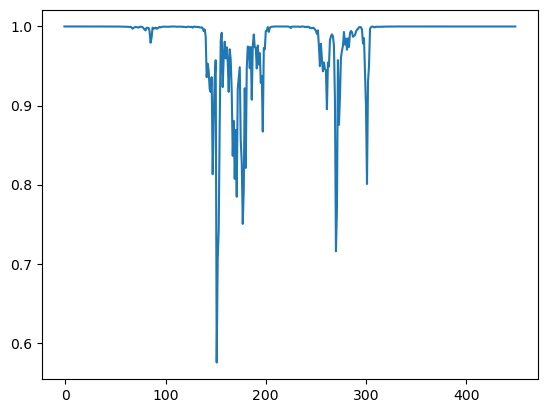

Min prediction for seq version (i=152): MGKKFIVKTQRGMESVAANYIKEALSNAEVWTSPMGYSGLVLVESEDETALEKIQEIPEVERVIPVLAEVPAVLDEIVKTAELVAPMIGENETFAVKTKRRGKHDFSSIDVNRALGARIQELTKADVNLSWPDKVVQVEIIGDRAYVSVVPXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXVRELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQMEAYPWKVEKVPISVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVGKKLARDMHYAKEVVIFIGSREGIPRGLFRFADYVVDLAPYLTFATEHGIPAALVSLWEVYEEFLREGEEDSE
Patched subseq: GEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYRACRSFGEKIGRAAQAFE
==== Sequence patch results: ====
MKFIVKTQRGMESVAANYIREALPDAEVWASPMGYYGLVIVETEDENAGKEILEIPEVERVIPVLVEVPAELERIVETAERIAPLIGENETFAVKTKRRGKHDFSSLDVNRNLGAKIQELTNADVNLSWPDKVVQVEIIGDRAYVSVVPGEEFRKFTPDKIDARKLFHKLTIVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIRGVKVGQESRYQIQREAYPWKVEKVPVSVWDLYQVIRDKRRGKRLLIITDPKGPTLAEVKDKLARDMFYAKEVVVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPGALVSLWEVYEEYLREREKQTEEESGQ


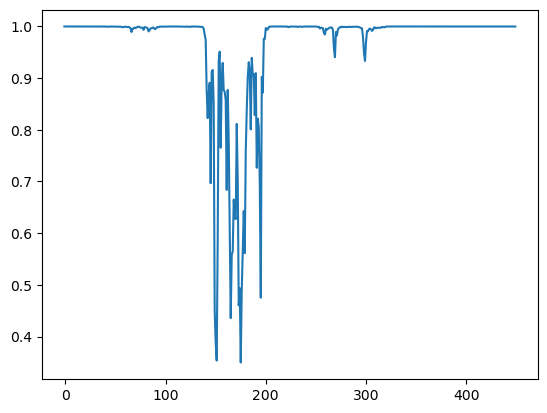

Min prediction for seq version (i=176): MKFIVKTQRGMESVAANYIREALPDAEVWASPMGYYGLVIVETEDENAGKEILEIPEVERVIPVLVEVPAELERIVETAERIAPLIGENETFAVKTKRRGKHDFSSLDVNRNLGAKIQELTNADVNLSWPDKVVQVEIIGDRAYVSVVPGEEFRKFTPDKIDARKLFHKLTIVQMXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGQESRYQIQREAYPWKVEKVPVSVWDLYQVIRDKRRGKRLLIITDPKGPTLAEVKDKLARDMFYAKEVVVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPGALVSLWEVYEEYLREREKQTEEESGQ
Patched subseq: PYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIRGVKV
==== Sequence patch results: ====
MEFIIKTQKGLEGTAASYIQEKLKNANTWITPEGYSGLIILKTSDKKATEKLQTIPEIERTIPVNYKTKSKIEKILEKAEKIAEHIKEGETFAVKTKRRGKHKFTSPQVNKKLGEKILKLTNATVDLNFPEKIIQVEIIGENTYISIKKGEKWKKYTPEKENARNLFHKTTIIQMPYWGKPQIVRKFGEKIGRAAQAYEIKELIIAPKEKMDAQQLAEFIQGIKKGQKSRYMIQKEAYPWPTKKVPISLWDLYQAIRDKKRKNRTIIITDPKGKTINTIKENLKKDLRKSKEIIILIGSREGIPRGLFKFADYIIDLTPYITFATEHAIPATLTTLYQIYTKKIGYYSRQ


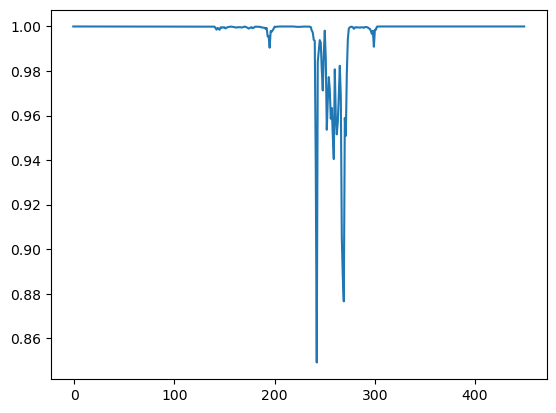

Min prediction for seq version (i=243): MEFIIKTQKGLEGTAASYIQEKLKNANTWITPEGYSGLIILKTSDKKATEKLQTIPEIERTIPVNYKTKSKIEKILEKAEKIAEHIKEGETFAVKTKRRGKHKFTSPQVNKKLGEKILKLTNATVDLNFPEKIIQVEIIGENTYISIKKGEKWKKYTPEKENARNLFHKTTIIQMPYWGKPQIVRKFGEKIGRAAQAYEIKELIIAPKEKMDAQQLAEFIQGIKKGQKSRYMIQKEAYPWPTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXIIILIGSREGIPRGLFKFADYIIDLTPYITFATEHAIPATLTTLYQIYTKKIGYYSRQ
Patched subseq: KKVPISLWDLYQAIRDKKRKNRTIIITDPKGKTINTIKENLKKDLRKSKE
==== Sequence patch results: ====
MQEPVRVDIIVTCKLGFERVVASLIKELCPECRAVPSPMGYMGLVLVKAHTQNIEVLANNIREKVPEAEKVFKVDAECNARLQELGECVKPLASGISSDESFAVRTVRRGKHDYTSLDVNAYIGSVIKEATGARVDLENPDKVVLIQILQDKAYVSIVPGSEFYRKMAPTKFPMYKLYRRMVVAHEPYLGPPDASYVMGTRIGREIQCFEVGKLVVAPVGAVEAEALQRFLRGVIDGQKSRLGIQKKSYGREVHRTEILVQDMYQFVRSWHGKPLIIFEPEGEPVSRVGGELADFIIEKVFREKKELGVMVGAREGIPSGLFRYADFVLDVAPGVVISTDLALTSGLIAIGTAVHDKLLGLDLSDGVEKLAE


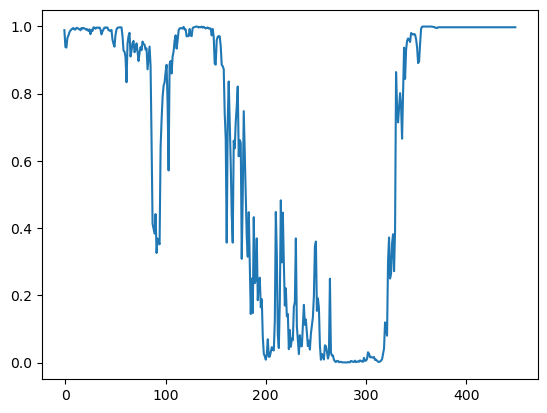

Min prediction for seq version (i=281): MQEPVRVDIIVTCKLGFERVVASLIKELCPECRAVPSPMGYMGLVLVKAHTQNIEVLANNIREKVPEAEKVFKVDAECNARLQELGECVKPLASGISSDESFAVRTVRRGKHDYTSLDVNAYIGSVIKEATGARVDLENPDKVVLIQILQDKAYVSIVPGSEFYRKMAPTKFPMYKLYRRMVVAHEPYLGPPDASYVMGTRIGREIQCFEVGKLVVAPVGAVEAEALQRFLRGVIDGQKSRLGIQKKSYGREVHRTEILVQDMYQFVRSWHGKPLIIFEPXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXVAPGVVISTDLALTSGLIAIGTAVHDKLLGLDLSDGVEKLAE
Patched subseq: EGEPVSRVGGELADFIIEKVFREKKELGVMVGAREGIPSGLFRYADFVLD
==== Sequence patch results: ====
MIVKTPLGLERIVASRIEELGVRCRVTAKPGGYPGIVAVDSVLDEEKVELAERIKREIPEAERVLVSQEVVEAEEDEIVEAALRISRRSLNRDTSFAVRTVRRGSHRYRSVDINHRVGAAVVREVDAPVDLEYPDKILWVEIIDDLAALGVLDGREVWRKRSPEKRDVRRFFSRASVVQMPYLGPRDAARSMGSRIGRAVQMFEVGELVIAVAGAVDARQLGWFIQGVLEGVESRFRVQQRTYAHKPRRVEVRVQDLYQLVRDRRGEPKVVFEPEGEAFPSVAGRLADLFLSGEERINLFFGSREGIPKGIFRLADLIIDLCPGITLSTEYAASSALIGIAFALEEKIKDQE


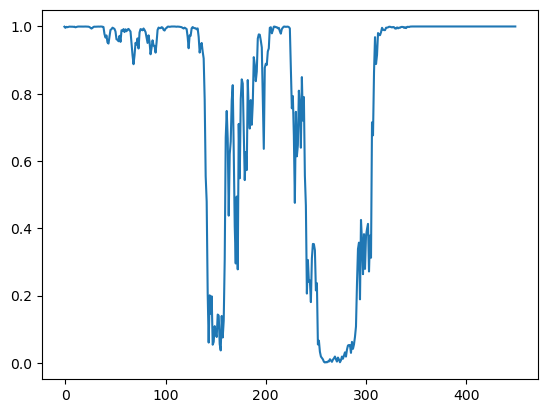

Min prediction for seq version (i=260): MIVKTPLGLERIVASRIEELGVRCRVTAKPGGYPGIVAVDSVLDEEKVELAERIKREIPEAERVLVSQEVVEAEEDEIVEAALRISRRSLNRDTSFAVRTVRRGSHRYRSVDINHRVGAAVVREVDAPVDLEYPDKILWVEIIDDLAALGVLDGREVWRKRSPEKRDVRRFFSRASVVQMPYLGPRDAARSMGSRIGRAVQMFEVGELVIAVAGAVDARQLGWFIQGVLEGVESRFRVQQRTYAHKPRRVEVRVQDLYQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGIFRLADLIIDLCPGITLSTEYAASSALIGIAFALEEKIKDQE
Patched subseq: LVRDRRGEPKVVFEPEGEAFPSVAGRLADLFLSGEERINLFFGSREGIPK
==== Sequence patch results: ====
MEEPKTNRRIDVIVKTLIGLERIVASRIEEIGIDCRVDPKPFGHPGVVTIELASEERKHELAERIREELPEAERVLVAERCVKADLGAIAEAAVEVSNKFLNEDTSFAVKTVRRGIHSFTSIDVNCRVGSAIVEAYGAPVNLEYPDVILWIEIFNNIAALVIMKGKNVWRKAKPGKYEVREFFSKVAVVQMPYFGPKDSVKAMSSRIGRAVQMFEVSELVIATTGSSDARQLEWFIHGVFEGIESRYRIQKRAYAHKPHRVRVMVQDIYQLVRDRRNEPKIVFEPEGDAFPKVAGDIAKLFLSDARRINMFFGSREGIPKGIFRFADFIVDLCPGVTLSTEYAASSALIGLAFALEDHLARSIKGPKAYVPD


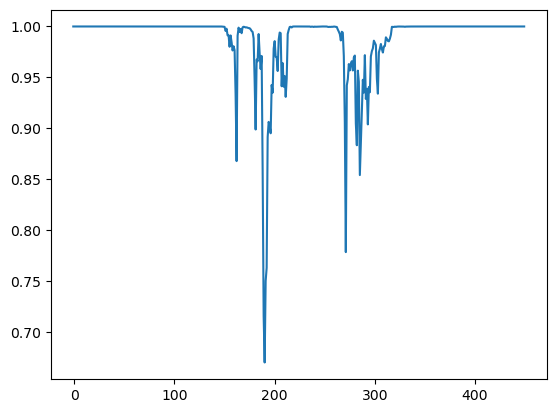

Min prediction for seq version (i=191): MEEPKTNRRIDVIVKTLIGLERIVASRIEEIGIDCRVDPKPFGHPGVVTIELASEERKHELAERIREELPEAERVLVAERCVKADLGAIAEAAVEVSNKFLNEDTSFAVKTVRRGIHSFTSIDVNCRVGSAIVEAYGAPVNLEYPDVILWIEIFNNIAALVIMKGKNVWRKAKPGKYEVREFFSKVAVVQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXEGIESRYRIQKRAYAHKPHRVRVMVQDIYQLVRDRRNEPKIVFEPEGDAFPKVAGDIAKLFLSDARRINMFFGSREGIPKGIFRFADFIVDLCPGVTLSTEYAASSALIGLAFALEDHLARSIKGPKAYVPD
Patched subseq: MPYFGPKDSVKAMSSRIGRAVQMFEVSELVIATTGSSDARQLEWFIHGVF
==== Sequence patch results: ====
MNKASNQRIDLIIKTPIGLENVAASRIEELGFKGDVNPKPSGYPGIVIVTLQDENEKLQIAERIEREIPEAERVLASRISTEASMKSIVKAAVKVASEILDPEVTFAVRTVRRGHHPYRSVDVNCKVGSAILERIDASVNLDRPEKIVWIEIVDDKAAVGILDGAEVWKKMKPGKQEVRTFFSKASVIQMPYLGDAKSAKSMGSRIGRAVQMFEVGELVIGTTGACDARQLGWFMNGIFEGIDSRYRIQRRTYAHRPRRVEVLVQDLYQLIRDRRSEPKIIFEPEGEKFSKIANEIADLFLKKSGRINLLFGSREGIPKGLFRFADFIVDLCPGITLSTEYAASSALIGISFALQNVMENP


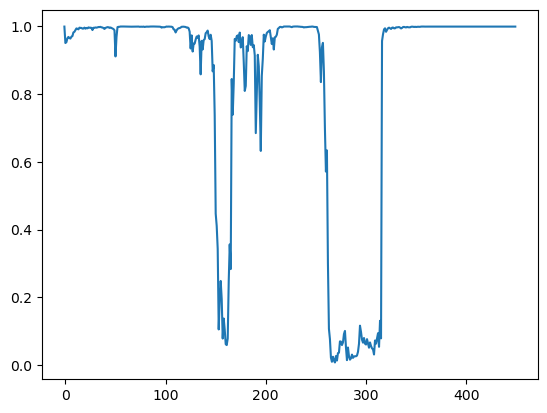

Min prediction for seq version (i=270): MNKASNQRIDLIIKTPIGLENVAASRIEELGFKGDVNPKPSGYPGIVIVTLQDENEKLQIAERIEREIPEAERVLASRISTEASMKSIVKAAVKVASEILDPEVTFAVRTVRRGHHPYRSVDVNCKVGSAILERIDASVNLDRPEKIVWIEIVDDKAAVGILDGAEVWKKMKPGKQEVRTFFSKASVIQMPYLGDAKSAKSMGSRIGRAVQMFEVGELVIGTTGACDARQLGWFMNGIFEGIDSRYRIQRRTYAHRPRRVEVLVQDLYQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGLFRFADFIVDLCPGITLSTEYAASSALIGISFALQNVMENP
Patched subseq: LIRDRRSEPKIIFEPEGEKFSKIANEIADLFLKKSGRINLLFGSREGIPK
==== Sequence patch results: ====
MVRPDIIVKTLLGMERVTASRIEELGFNVNVEPKPKGFPGLVTLEVKRKSDGPKLAEAIKQEIPEAERVLLSEEVVNADMDEIVEAAVKVSTRHLSPDITFAVRTVRRGTHQYKSIDVNYKAGSAIIEATGASVNLDYPDKIIWVEIIGEVAAIGIADKAEIWRKMKPGKVEVRNFFRKVSVVQIPYLGPRGSIRPMGSRIGRAVQMFEVGEYVVAVVGSVKGWMLNLFLEGLLEGVESRYNIQRRTYAHRPHRVEVVVQDLYQLVRERKDEPKIVFEPEGEPFPEVAERLAEMTASNDVARVNMLFGSREGVPKGVFRFVDMVIDLCPGVTLSTEYAASSALIGLAYALEEHLKKANV


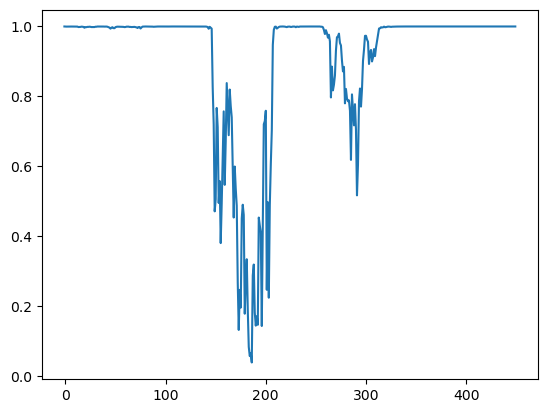

Min prediction for seq version (i=187): MVRPDIIVKTLLGMERVTASRIEELGFNVNVEPKPKGFPGLVTLEVKRKSDGPKLAEAIKQEIPEAERVLLSEEVVNADMDEIVEAAVKVSTRHLSPDITFAVRTVRRGTHQYKSIDVNYKAGSAIIEATGASVNLDYPDKIIWVEIIGEVAAIGIADKAEIWRKMKPGKVEVRNFFRKVSVVQIPXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXVESRYNIQRRTYAHRPHRVEVVVQDLYQLVRERKDEPKIVFEPEGEPFPEVAERLAEMTASNDVARVNMLFGSREGVPKGVFRFVDMVIDLCPGVTLSTEYAASSALIGLAYALEEHLKKANV
Patched subseq: YLGPRGSIRPMGSRIGRAVQMFEVGEYVVAVVGSVKGWMLNLFLEGLLEG


In [11]:
all_scores = []
for i in range(1, 50):
    seq = data[i][0]
    
    # skip sequences that are too long
    if len(seq) > SEQ_DIM:
        continue

    seq_scores = visualize_one_seq_results(seq)
    all_scores.append(seq_scores)

==== Sequence patch results: ====
MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFEIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSL


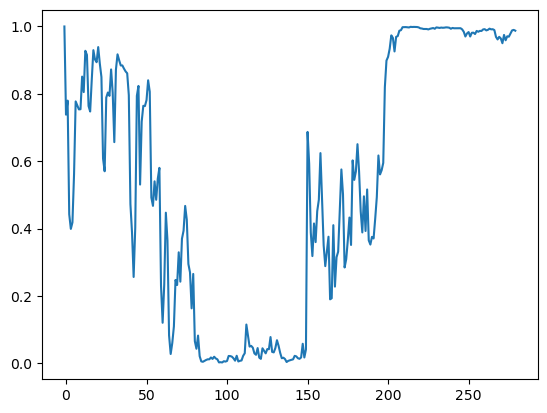

Min prediction for seq version (i=98): MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSL
Patched subseq: GTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFEIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLA
==== Sequence patch results: ====
MAKYIIKTQKGFENIVVNNLKEIIGDFKYTVSPDGYQGIVIVEHDEDIEDKILEIPEVERVLRVYFETETEFDKIVNLAEKIKDYIKEDETFAVETKKRGKHDFSSTDVNIVLGAKIKDLTNASVDLNNPDKVVHVEVFKNKTYVSITPGEKFKKYTKEKRNARELFRKVVIVQMPYLGEKIVCKRFGEAIGRAAQGFEVKELIIAPKEKVDAYELMEFIKGVKIGQHSRYEIQKRAYPFEIKLVPVTVQDLYQVVRDKRRDNRLLIITDPKGDELSKIKDKLAYDLRKKREIIVFCGSREGIPRGLFRFADYILDLAPHMTFATEHAIPAALIALW

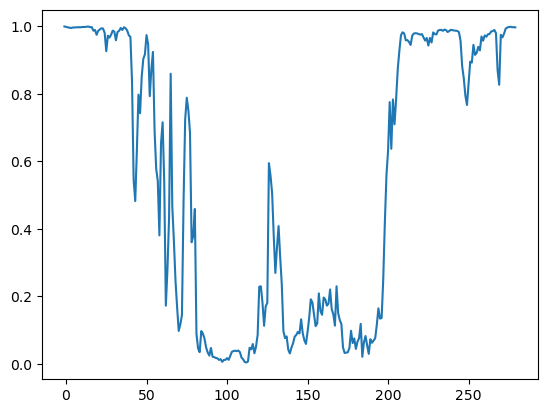

Min prediction for seq version (i=113): MAKYIIKTQKGFENIVVNNLKEIIGDFKYTVSPDGYQGIVIVEHDEDIEDKILEIPEVERVLRVYFETETEFDKIVNLAEKIKDYIKEDETFAVETKKRGKHDFSSTDVNIVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXLIALWGVYSGEDLENSSEEEKTESNSNDE
Patched subseq: LGAKIKDLTNASVDLNNPDKVVHVEVFKNKTYVSITPGEKFKKYTKEKRNARELFRKVVIVQMPYLGEKIVCKRFGEAIGRAAQGFEVKELIIAPKEKVDAYELMEFIKGVKIGQHSRYEIQKRAYPFEIKLVPVTVQDLYQVVRDKRRDNRLLIITDPKGDELSKIKDKLAYDLRKKREIIVFCGSREGIPRGLFRFADYILDLAPHMTFATEHAIPAA
==== Sequence patch results: ====
MKFLVKTQRDMEAVAGNYITEAVPDAEVWIAPMGYTGLVLVEADENAYEKLLEIPEVERVIPVLVETEADLEKIAESAEKIAHLIGENETYAVKTKRRGKHDFSSIDVNRVLGARIKELSGADVNLSWPDKVVQVEIIGDRAYISVLPGEEYRKYTPNKIDARKLFRKLTVVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIKGVKIGQESRYKIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEELARDMHHAREVVVFIGSREGIPRGVFRFADYVVDLAPYMTFATEHG

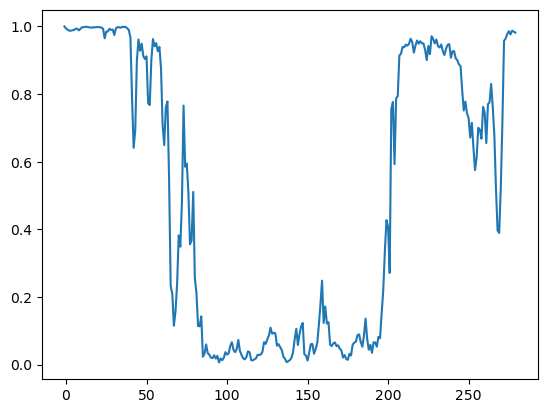

Min prediction for seq version (i=96): MKFLVKTQRDMEAVAGNYITEAVPDAEVWIAPMGYTGLVLVEADENAYEKLLEIPEVERVIPVLVETEADLEKIAESAEKIAHLIGENETYAVKTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXLAPYMTFATEHGIPATLVSLWEVYEEFLRENGKEEKEGE
Patched subseq: KRRGKHDFSSIDVNRVLGARIKELSGADVNLSWPDKVVQVEIIGDRAYISVLPGEEYRKYTPNKIDARKLFRKLTVVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIKGVKIGQESRYKIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEELARDMHHAREVVVFIGSREGIPRGVFRFADYVVD
==== Sequence patch results: ====
MIFVKTQRGMEYIAAQNIKELLGDVKIEIRPAGYLGILVVHSDELEQVRQVPEVERAIPVLFEIESNLDEILEKAEEVVKAMGEFDTFAIRATRRGLKHRFSSMDISIQLGRRIQEISGRDVDLNTPDKAIYVEVVNERTFIGILDGAEERRKYTPEKADSLRFFEKVSFVQMPYLENLKGAREIGERIGRNAQSFEIKELIIAPYGYVDAEELFEFLRGVRRGKLSRLSIQRKSYAREVRETKILVHDLFQTLRDKKRRKYVVIATDPTGRQISDVRDELKRAFERANEIVIFAGSRTGLPKGVLRLADFVVDLSPYITFPTELAIPVSLTAFL

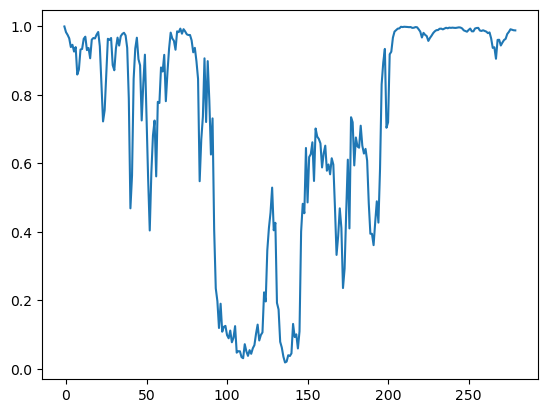

Min prediction for seq version (i=137): MIFVKTQRGMEYIAAQNIKELLGDVKIEIRPAGYLGILVVHSDELEQVRQVPEVERAIPVLFEIESNLDEILEKAEEVVKAMGEFDTFAIRATRRGLKHRFSSMDISIQLGRRIQEISGRDVDLNTPDKAIYVEVVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: NERTFIGILDGAEERRKYTPEKADSLRFFEKVSFVQMPYLENLKGAREIGERIGRNAQSFEIKELIIAPYGYVDAEELFEFLRGVRRGKLSRLSIQRKSYAREVRETKILVHDLFQTLRDKKRRKYVVIATDPTGRQISDVRDELKRAFERANEIVIFAGSRTGLPKGVLRLADFVVDLSPYITFPTELAIPVSLTAFLDIYEEMKADRTKRER
==== Sequence patch results: ====
MIFVKTQRGMEYIAMQNIKELMGDVKIEVRPAGYLGVLIVHSDDIEKVKEVPEVEKAIPILFELRSDLDEILGKAEEIVEAMGDFETFAVRTTRRGLRHDFNSMDVNIRLGRRIQEISGKEVDLNQPDKAVYVEIVNERTFIGILDGEEERRKYMPEKVDSLKFFGKVSFVQMPYLENPKGAREIGERIGRSAQSFEIKELIIAPYGYVDADELYEFLRGLRRGKESRLKIQRRSYARDVREVRVLVHDLYQTFRDKRRKRSVLISTDPTGKQLSEIREELKRAFERADEIVIFAGSRTGLPKGILRLSDFVIDLTPYITFPTEIAIPASLIALLDVY

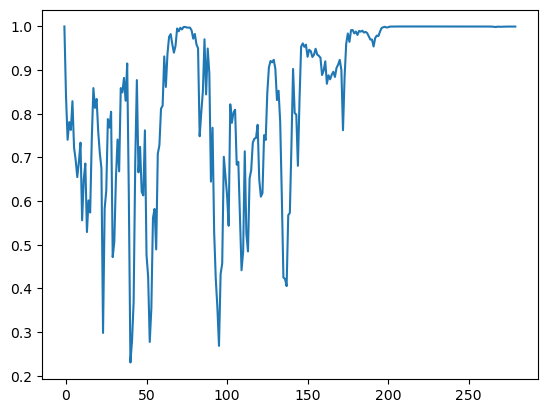

Min prediction for seq version (i=41): MIFVKTQRGMEYIAMQNIKELMGDVKIEVRPAGYLGVLIVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXRSVLISTDPTGKQLSEIREELKRAFERADEIVIFAGSRTGLPKGILRLSDFVIDLTPYITFPTEIAIPASLIALLDVYEEMVQEREQK
Patched subseq: HSDDIEKVKEVPEVEKAIPILFELRSDLDEILGKAEEIVEAMGDFETFAVRTTRRGLRHDFNSMDVNIRLGRRIQEISGKEVDLNQPDKAVYVEIVNERTFIGILDGEEERRKYMPEKVDSLKFFGKVSFVQMPYLENPKGAREIGERIGRSAQSFEIKELIIAPYGYVDADELYEFLRGLRRGKESRLKIQRRSYARDVREVRVLVHDLYQTFRDKRRK
==== Sequence patch results: ====
MASRECQLLLVKTILGMERVAASYIAEMDPDARIEPAPRGFRGLVLVEASKDKYELAREIEAKVPEVEKVVVAEACTEADPAKIAETAAALAPRFISSNETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMKPGKYPLYKLFRRFSIVQMPYLGPLDACRTMGVRVGREVQNFEVGELVVAPIGLVDARQLYEFLGGVFEGIESRYQIQRRSYGRDVRRVPVYVQDLYQLVRSRHGEPIIVFEPEGDPISKRAKDVLEIVKRGRRVTLLFGSREGIPEGVYRFADLVLDIAPGITLSTEYAAAAA

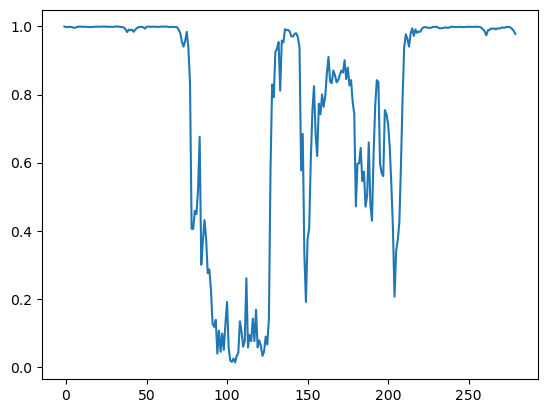

Min prediction for seq version (i=106): MASRECQLLLVKTILGMERVAASYIAEMDPDARIEPAPRGFRGLVLVEASKDKYELAREIEAKVPEVEKVVVAEACTEADPAKIAETAAALAPRFISSNETFAVRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXIAPGITLSTEYAAAAALIAIGSVVHDELAAEQVNGEDSAADKQPKDAA
Patched subseq: TVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMKPGKYPLYKLFRRFSIVQMPYLGPLDACRTMGVRVGREVQNFEVGELVVAPIGLVDARQLYEFLGGVFEGIESRYQIQRRSYGRDVRRVPVYVQDLYQLVRSRHGEPIIVFEPEGDPISKRAKDVLEIVKRGRRVTLLFGSREGIPEGVYRFADLVLD
==== Sequence patch results: ====
MKFLIKTQKDMEAVAANYIKDLLDETEIWVTPQGYSGLVLVDTKDPKAEEKFFEIPEIERIIPVLFEVPASLDAIVSVAEEIADYISEEETFAVKTKRRGKHEFSSIDVNITLGEKIRELTNAAVDLSFPDKTVLVEIIGERAYISIAGKEEWKKFTPEKINARKLFKKVTIVQMPYWGDYKACKNFGEKIGRAVQAFEVKELIIAPKEKMNAYELMEFIKGIRTGQESRYQIQKEAYPWKVEKVPISVWDLYQVIRDKRRNKRLLIITDPKGNTIPEVKENLTKDLYYAKEVVVFIGSREGIPRGLFRYADYVL

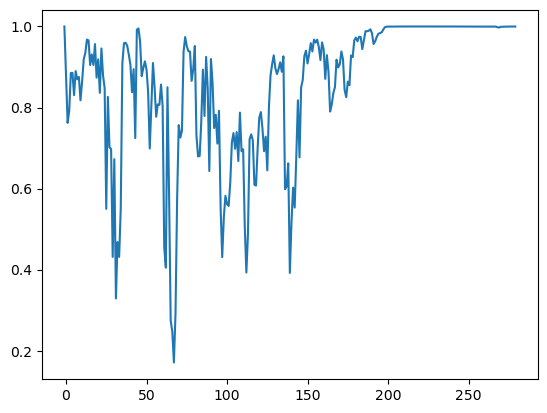

Min prediction for seq version (i=68): MKFLIKTQKDMEAVAANYIKDLLDETEIWVTPQGYSGLVLVDTKDPKAEEKFFEIPEIERIIPVLFEXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXYYAKEVVVFIGSREGIPRGLFRYADYVLDLAPYMTFATEHGIPAVLIALWTIYEEELRKKGIKEE
Patched subseq: VPASLDAIVSVAEEIADYISEEETFAVKTKRRGKHEFSSIDVNITLGEKIRELTNAAVDLSFPDKTVLVEIIGERAYISIAGKEEWKKFTPEKINARKLFKKVTIVQMPYWGDYKACKNFGEKIGRAVQAFEVKELIIAPKEKMNAYELMEFIKGIRTGQESRYQIQKEAYPWKVEKVPISVWDLYQVIRDKRRNKRLLIITDPKGNTIPEVKENLTKDL
==== Sequence patch results: ====
MKFIVKTQRGMESVAANYIREAISDASVWASPMGYSGLIIVETSDENAGEKILEIPEVERLIPVIAEVPAELEAIVTTAEKIAPLISENETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDRVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGNHKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKDRLAKDMFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLW

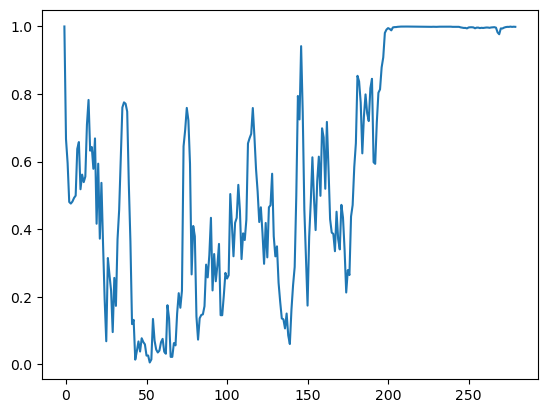

Min prediction for seq version (i=53): MKFIVKTQRGMESVAANYIREAISDASVWASPMGYSGLIIVETSDENAGEKIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGPTLAEVKDRLAKDMFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREKKT
Patched subseq: LEIPEVERLIPVIAEVPAELEAIVTTAEKIAPLISENETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDRVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGNHKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPK
==== Sequence patch results: ====
MSECSVILVKTELGMERYVANSLDVDCEIVAAPMGFKGLVLMKNCKNLEEVIERLNGMPEVIRFMIAEECVRADLKELKEAAKRLARKLEGKRFAVRTIRRGSHPFTSIEVNAELGALILREANGSKVDLTNPEAVLMVEIIGEEAYLAVVDPSYAGLKKKLGKEDTARFLSRLSVIQEPYLGPPKSIEELGKRIGRILQSYGVGEYYIGLIEETDALQLAQFIESVRDGMEARRKQEEKVEGKALSTKLKVFDVYHLALSKSKKELMVVFEPEGKSFEEVEEELAKALRKAKRVKAFLGSRKGVPMGIYKLADFVIDVAPGRTLSTETALAAALEAL

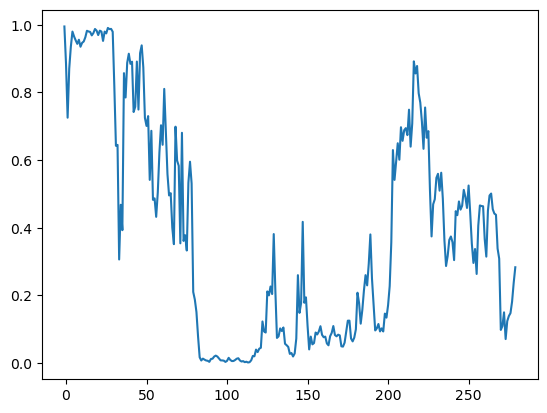

Min prediction for seq version (i=114): MSECSVILVKTELGMERYVANSLDVDCEIVAAPMGFKGLVLMKNCKNLEEVIERLNGMPEVIRFMIAEECVRADLKELKEAAKRLARKLEGKRFAVRTIRRGSHPFTSIEVNAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXALEALLIAYLRGKFYSDNQQ
Patched subseq: ELGALILREANGSKVDLTNPEAVLMVEIIGEEAYLAVVDPSYAGLKKKLGKEDTARFLSRLSVIQEPYLGPPKSIEELGKRIGRILQSYGVGEYYIGLIEETDALQLAQFIESVRDGMEARRKQEEKVEGKALSTKLKVFDVYHLALSKSKKELMVVFEPEGKSFEEVEEELAKALRKAKRVKAFLGSRKGVPMGIYKLADFVIDVAPGRTLSTETALAA
==== Sequence patch results: ====
MKFLIKTQRGMEAVAANYIKDALEDAKVWIAPQGYSGLVLVESEDKDAEQKLFDIPEIERVIPVLFEVPATIEDILSVSEQIAAYIKEGESFAVKTKRRGKHGFSSVDVNIALGGKIKELTNAEVDLTFPDKTVLVEIIGDRAYISITGREEWKKFTPEKIDARKLFKKVTIVQMPYWGDYKACRNFGEKIGRAAQAFEVKELIIAPKDKMDAYELMEFIQGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGNSVSEIKDSLAKDLYYAKEVVVFIGSREGIPRGLFRYADYVIDLAPYMTFATEHGIPAALIA

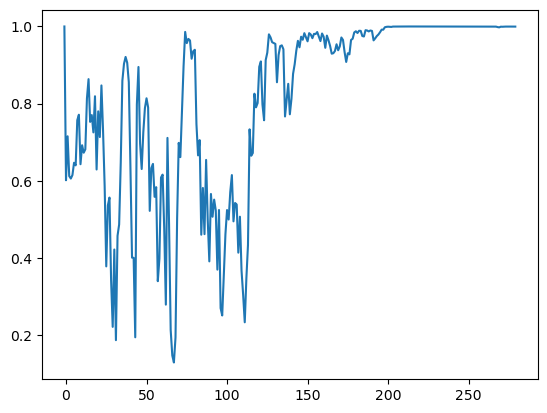

Min prediction for seq version (i=68): MKFLIKTQRGMEAVAANYIKDALEDAKVWIAPQGYSGLVLVESEDKDAEQKLFDIPEIERVIPVLFEXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXYYAKEVVVFIGSREGIPRGLFRYADYVIDLAPYMTFATEHGIPAALIALWTIYEEELRKEEGKR
Patched subseq: VPATIEDILSVSEQIAAYIKEGESFAVKTKRRGKHGFSSVDVNIALGGKIKELTNAEVDLTFPDKTVLVEIIGDRAYISITGREEWKKFTPEKIDARKLFKKVTIVQMPYWGDYKACRNFGEKIGRAAQAFEVKELIIAPKDKMDAYELMEFIQGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGNSVSEIKDSLAKDL
==== Sequence patch results: ====
MQGSKCNLVLMKTVLGMEKVAASYVKEIDPGARVEPSPRGFRGLVLVEPSRDKYEVAKEIEERVPEAEKVVVAEACTEADPRKIAEIAAELAPRFISSSETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMRPGKYPLYKLFRRLSVVQMPYLGPLDACRTMGVRVGREVQNFEVGELVVSPIGLVDALQLKTFLDGVFEGIESRYQVQRKSYGRDVHRVPVYVQDLYQLVRSRYDEPVIVFEPEGDPISKRARDILELVRKGRRVNLLFGSREGIPEGVYRFADLVLDVAPGITLSTEYAA

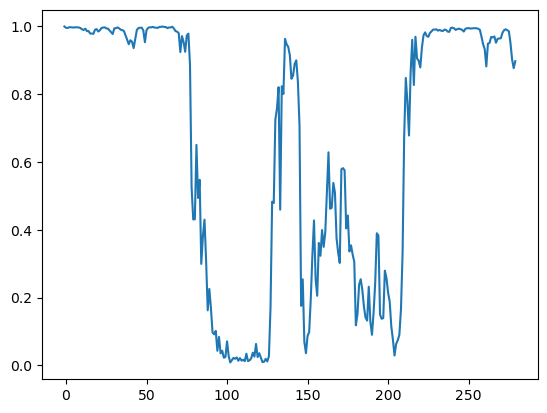

Min prediction for seq version (i=103): MQGSKCNLVLMKTVLGMEKVAASYVKEIDPGARVEPSPRGFRGLVLVEPSRDKYEVAKEIEERVPEAEKVVVAEACTEADPRKIAEIAAELAPRFISSSETFXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXVLDVAPGITLSTEYAAAAALIAIGSVIHDLLAVDREPAGEQGSRS
Patched subseq: AVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMRPGKYPLYKLFRRLSVVQMPYLGPLDACRTMGVRVGREVQNFEVGELVVSPIGLVDALQLKTFLDGVFEGIESRYQVQRKSYGRDVHRVPVYVQDLYQLVRSRYDEPVIVFEPEGDPISKRARDILELVRKGRRVNLLFGSREGIPEGVYRFADL
==== Sequence patch results: ====
MGEGKKFIVKTQRGMESVAANYISEVLPDANVWASPMGYSGLIIVESSAEDALDKILQIPEVERVIPVIVETEANLEKIAESAEKLAGFIGENETYAVKTKRRGKHDFSSIDVNRVLGAKIKELTNADVNLSWPDKVVQVEIIGDRAYISVIPGDEFRKYTPDKIDARKLFSKLTLVQMPYWGDYKACRLFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQRDAYPWKVEKVPVTVWDLYQVVRDKRRKKRLLIITDPKGPTLAEVKDKLARDLHYAKEVVVFIGSREGIPKGLFRFADYVVDL

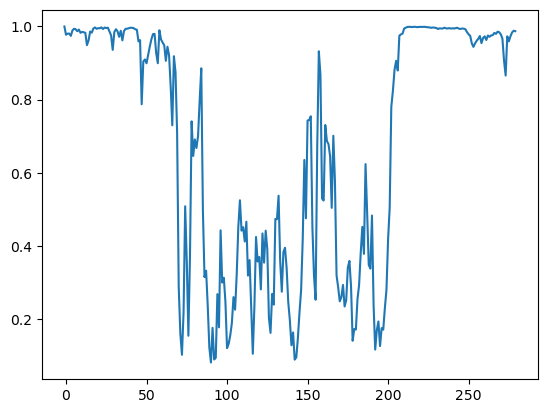

Min prediction for seq version (i=91): MGEGKKFIVKTQRGMESVAANYISEVLPDANVWASPMGYSGLIIVESSAEDALDKILQIPEVERVIPVIVETEANLEKIAESAEKLAGFIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEFLRKEE
Patched subseq: GENETYAVKTKRRGKHDFSSIDVNRVLGAKIKELTNADVNLSWPDKVVQVEIIGDRAYISVIPGDEFRKYTPDKIDARKLFSKLTLVQMPYWGDYKACRLFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQRDAYPWKVEKVPVTVWDLYQVVRDKRRKKRLLIITDPKGPTLAEVKDKLARDLHYAKEVVVFIGSREGIPKG
==== Sequence patch results: ====
MKFLVKTQKGMEGVAANYIGEALPDAEVWISPMGYYGLVIVETGDENAGEVMLGIPEIERIIPVLAEVPAELERIVEIAEKVAPLIGENETFAVKTKRRGKHGFSSIDVNRELGAKVRELTGADVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKRDARELFRKVTVVQMPYWGGYKVCRSFGEKIGRAAQAFEVKELIIAPKGKMDALELAEFIKGVRVGQESRHRIQRESYPWKVEKVPVSVWDLYQVVRDKRRDKRLLIITDPKGPTVAQVGERLARDMFHAKEVVVFIGSREGIPRGLFRFADYVIDLAPYMTFATEHGIPAALVSLW

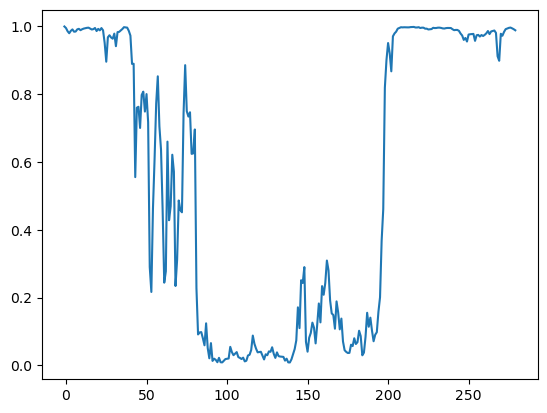

Min prediction for seq version (i=140): MKFLVKTQKGMEGVAANYIGEALPDAEVWISPMGYYGLVIVETGDENAGEVMLGIPEIERIIPVLAEVPAELERIVEIAEKVAPLIGENETFAVKTKRRGKHGFSSIDVNRELGAKVRELTGADVNLSWPDKVVQVEIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: GDRAYVSVLPGEEFRKFTPDKRDARELFRKVTVVQMPYWGGYKVCRSFGEKIGRAAQAFEVKELIIAPKGKMDALELAEFIKGVRVGQESRHRIQRESYPWKVEKVPVSVWDLYQVVRDKRRDKRLLIITDPKGPTVAQVGERLARDMFHAKEVVVFIGSREGIPRGLFRFADYVIDLAPYMTFATEHGIPAALVSLWEVYEEYTGKREAKGEAVSD
==== Sequence patch results: ====
MEFIIKTQKNLEGTAATRIKEKLKNAETWITPEGYSGLIILKTTDKEATKKLQEIPEIERTLPIHYKTGSNLEKILEKAEKIAKHIKENETFAVKTKRRGKHNFTSPEINKKLGEKILQLTNATVNLNSPDKTIQIEIIGENTYISIRKKEKWKKYTPEKEDARKLFNKTTIIQMPYWGKPQIARKFGEKIGRAAQAYEIKELIIAPKEKMNAQEIAEFIKGVKKGQQSRYKIQKEAYPWPTKKVPISLWDIYQATRDKKRKKRTIIITDPKGKTINAIKENLQKDLRKSKEIIILIGSREGIPRGLFKFADYIIDLTPYITFATEHVIPAT

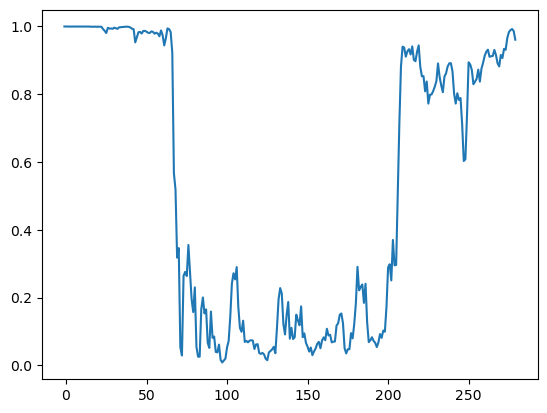

Min prediction for seq version (i=98): MEFIIKTQKNLEGTAATRIKEKLKNAETWITPEGYSGLIILKTTDKEATKKLQEIPEIERTLPIHYKTGSNLEKILEKAEKIAKHIKENETFAVKTKXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXTPYITFATEHVIPATLTTLYQLYSKEGQT
Patched subseq: RRGKHNFTSPEINKKLGEKILQLTNATVNLNSPDKTIQIEIIGENTYISIRKKEKWKKYTPEKEDARKLFNKTTIIQMPYWGKPQIARKFGEKIGRAAQAYEIKELIIAPKEKMNAQEIAEFIKGVKKGQQSRYKIQKEAYPWPTKKVPISLWDIYQATRDKKRKKRTIIITDPKGKTINAIKENLQKDLRKSKEIIILIGSREGIPRGLFKFADYIIDL
==== Sequence patch results: ====
MSIFKYLQQLLVVSSMSGVDLIIKTRKEFERVAASHIKELLGPGAEAVSAPWGYLGIVFVKGLGADRWKAAELIAEKIPEVDRVLVVEEAVKADLPEIEKAAVEVARRYIQSGDTFAIRTTRRGRHGFTSIDVNVRVGAAVKEATGAEVDLEEPTKPLYIEIFQDTAAICVPATREYKKLRRDKPLPLQFFRKVAIGQLVYEGDEEAVRKMGERIGRAVQTFEVGELAVLLHKPMPSKSLGTFLEAVEAGIESRYQIQARSYGRPVWKVPVYVYELYQYIRSREGEPIVVTDPKGDYITHVKEELAQLFRRDRVNVLIGSREGIPTGVFRLASLVVDLVPEVT

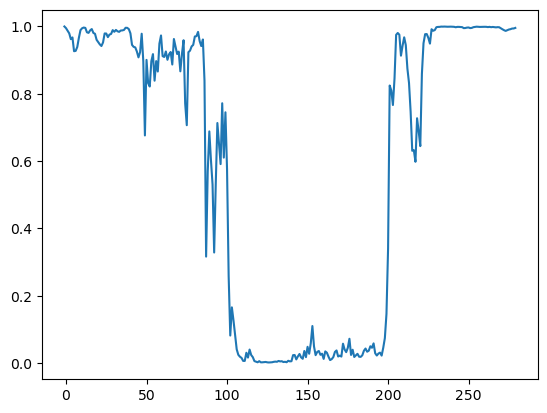

Min prediction for seq version (i=127): MSIFKYLQQLLVVSSMSGVDLIIKTRKEFERVAASHIKELLGPGAEAVSAPWGYLGIVFVKGLGADRWKAAELIAEKIPEVDRVLVVEEAVKADLPEIEKAAVEVARRYIQSGDTFAIRTTRRGRHXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXDFVVPSLAVALVSALEEAGALPRYVGKRRKH
Patched subseq: GFTSIDVNVRVGAAVKEATGAEVDLEEPTKPLYIEIFQDTAAICVPATREYKKLRRDKPLPLQFFRKVAIGQLVYEGDEEAVRKMGERIGRAVQTFEVGELAVLLHKPMPSKSLGTFLEAVEAGIESRYQIQARSYGRPVWKVPVYVYELYQYIRSREGEPIVVTDPKGDYITHVKEELAQLFRRDRVNVLIGSREGIPTGVFRLASLVVDLVPEVTIAT
==== Sequence patch results: ====
MKFIVKTQMDMEAVAGNYIKEILPNAKVTTAPEGYPGIVIVEAEDENALQKILEVPEVEKVYPVLVEVPATLEDIKNSAEEIVRHINDGESFAVRTKKRGKKDFSSVDVNVVLGARIKDLKNVEVNLSYPDKVVQVEIIGDKAYISVIPGEEYMKWKKYPKEKPNCRKLFKKLTIVQMPYWGDYKTARAFGEKIGRAAQAFEVKELIIAPKEKMNAYELMAFIRGVKEGQESRYQIQREAYPWQVEKVPVTVWDLYQVIRDKRRNRRLIIITDPKGPTLNEVKDKLAKDMYYAKEVVVFIGSREGIPVGLF

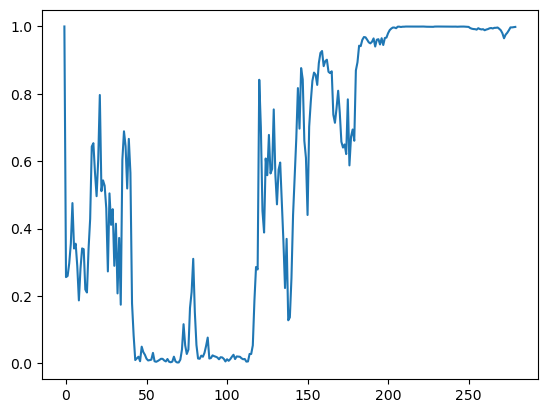

Min prediction for seq version (i=70): MKFIVKTQMDMEAVAGNYIKEILPNAKVTTAPEGYPGIVIVEAEDENALQKILEVPEVEKVYPVLVEVPXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXMYYAKEVVVFIGSREGIPVGLFRFADYVVDLAPYMTFATEHGIPATLVALWTIYEEELRRRGEVAGED
Patched subseq: ATLEDIKNSAEEIVRHINDGESFAVRTKKRGKKDFSSVDVNVVLGARIKDLKNVEVNLSYPDKVVQVEIIGDKAYISVIPGEEYMKWKKYPKEKPNCRKLFKKLTIVQMPYWGDYKTARAFGEKIGRAAQAFEVKELIIAPKEKMNAYELMAFIRGVKEGQESRYQIQREAYPWQVEKVPVTVWDLYQVIRDKRRNRRLIIITDPKGPTLNEVKDKLAKD
==== Sequence patch results: ====
MEKIVCSRIQENFEKTGNVVPKPSGFMGIVISEICGKKKEEIKEIPEVENVVPIVEEVSQPNLEKISKLCRKVAEELPDGSRFAVDADRRGTHEFTSQEIEAKAGSEIMKLVGSLEVELDRPDFVVKVEVIEQWAGVGILEGGEILRKKVGKADSRELTAKIHLVQLVYRGKDRRGIERIGVSLGRSAQAFETKKVTIVFDSPTDADKLQAFLNGIDEGIDSRFRIQKRVYERSMSRVPVDVYELYQFLRKIDGEEDLVIMTDPRGEVLQNSRNNLKEDLKSAETVYLFNGSNKGIPTGCFERADHVLDLAPHITYATDQAITASVIALLNL

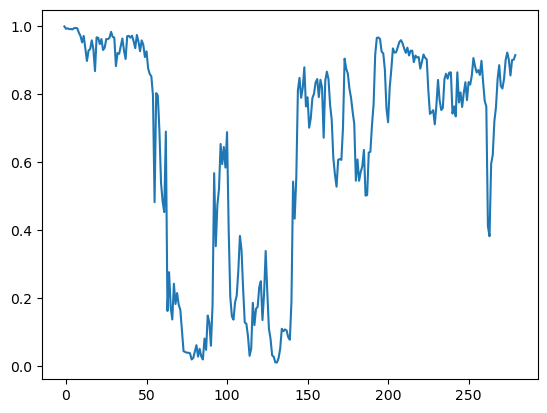

Min prediction for seq version (i=132): MEKIVCSRIQENFEKTGNVVPKPSGFMGIVISEICGKKKEEIKEIPEVENVVPIVEEVSQPNLEKISKLCRKVAEELPDGSRFAVDADRRGTHEFTSQEIEAKAGSEIMKLVGSLEVELDRPDFVVKVEVIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: EQWAGVGILEGGEILRKKVGKADSRELTAKIHLVQLVYRGKDRRGIERIGVSLGRSAQAFETKKVTIVFDSPTDADKLQAFLNGIDEGIDSRFRIQKRVYERSMSRVPVDVYELYQFLRKIDGEEDLVIMTDPRGEVLQNSRNNLKEDLKSAETVYLFNGSNKGIPTGCFERADHVLDLAPHITYATDQAITASVIALLNL
==== Sequence patch results: ====
MKFLVKTQKGMESVAGNYIREALPNAEVWASPMGYSGLVIVETNDENAEEKILEIPEVERVIPVLVETNAELGEIVKAANEIASLISKDETFAVKTKRRGKHDFSSIDVNRVLGAKIKELTDADVNLSWPDKVVQVEIIGDRAFISVLPGEEYRKYTPDKFDARKLLSKVTLVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFLRGIKTGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEKLARDMHYAKEVVIFIGSREGIPRGLFRFADYVIDLAPYMTFATEHGIPATLVSLWEVYEEFLRKSEEKAEAPS


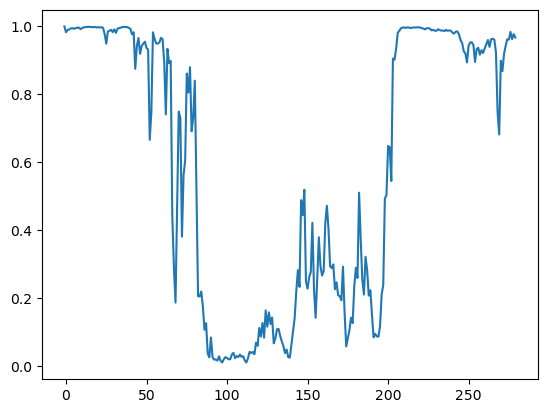

Min prediction for seq version (i=98): MKFLVKTQKGMESVAGNYIREALPNAEVWASPMGYSGLVIVETNDENAEEKILEIPEVERVIPVLVETNAELGEIVKAANEIASLISKDETFAVKTKXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAPYMTFATEHGIPATLVSLWEVYEEFLRKSEEKAEAPS
Patched subseq: RRGKHDFSSIDVNRVLGAKIKELTDADVNLSWPDKVVQVEIIGDRAFISVLPGEEYRKYTPDKFDARKLLSKVTLVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFLRGIKTGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEKLARDMHYAKEVVIFIGSREGIPRGLFRFADYVIDL
==== Sequence patch results: ====
MPCERVLAIVKTVLGMEEVAASVIEETVGVRCVAKPNGYPGIVLVCGDGERSEVVDRIRSEVPEAERVIPVEEWVPSDIDSIVEAAKRVVDGRIGADESFAVRTVRRGRRGYTSVDVNIRAGAVVKEVTGASVNLRYPDKIVQVEILGDHAAVSLLDGRMEWRKLRPGKPAVLDFIRKVAVAHIPYLGPPNASREMGVRVGREAQTFEVKELVVTPVGLTDADSLRHFLNGVFEGIRSRFEIQKRAYGRDVHKVQVHLQDIYGFVRERRREPIIVFEPEGEPVPKVADEIYKLLQARRRVNVMVGSRVGIPLGIYRFADLVVDLCPGVTIATDY

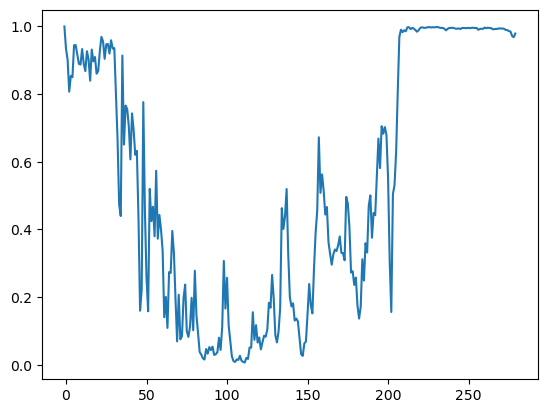

Min prediction for seq version (i=112): MPCERVLAIVKTVLGMEEVAASVIEETVGVRCVAKPNGYPGIVLVCGDGERSEVVDRIRSEVPEAERVIPVEEWVPSDIDSIVEAAKRVVDGRIGADESFAVRTVRRGRRGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXTDYALTAGVIAFANIIEAKLIGEEG
Patched subseq: YTSVDVNIRAGAVVKEVTGASVNLRYPDKIVQVEILGDHAAVSLLDGRMEWRKLRPGKPAVLDFIRKVAVAHIPYLGPPNASREMGVRVGREAQTFEVKELVVTPVGLTDADSLRHFLNGVFEGIRSRFEIQKRAYGRDVHKVQVHLQDIYGFVRERRREPIIVFEPEGEPVPKVADEIYKLLQARRRVNVMVGSRVGIPLGIYRFADLVVDLCPGVTIA
==== Sequence patch results: ====
MKALPSRRFDLIVKTPIGLERIAASRIEDLGLEGEVHSRPSGYPGIVTVTLRREDDKTHIAERIEREVPEAERVLVSRMSTAATIEEITDAAVKVASGAIRDGDSFAVRTVRRGRHPYTSVDVNRTVGSAVLESTGASVNLDHPDKILWVEIIDDQAAIGIIDGSEVWRKMKPGKWEVRTFLSKASVIQMPYLGDEKSARSMGSRIGRAVQMFEVGEFVIATMGVCDARRLAWFMDGVFEGIDSRYRIQCRTYAHRPRRVEVLVQDVYQLVRDRRAEPKIIFEPEGEVFPKVSSKIADLFLKADRRINLLFGSREGIPKGLFRFADLIVDLC

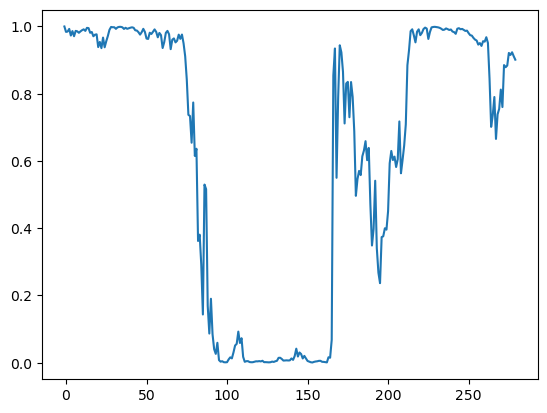

Min prediction for seq version (i=154): MKALPSRRFDLIVKTPIGLERIAASRIEDLGLEGEVHSRPSGYPGIVTVTLRREDDKTHIAERIEREVPEAERVLVSRMSTAATIEEITDAAVKVASGAIRDGDSFAVRTVRRGRHPYTSVDVNRTVGSAVLESTGASVNLDHPDKILWVEIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: DDQAAIGIIDGSEVWRKMKPGKWEVRTFLSKASVIQMPYLGDEKSARSMGSRIGRAVQMFEVGEFVIATMGVCDARRLAWFMDGVFEGIDSRYRIQCRTYAHRPRRVEVLVQDVYQLVRDRRAEPKIIFEPEGEVFPKVSSKIADLFLKADRRINLLFGSREGIPKGLFRFADLIVDLCPGITLSTEYAASSALIGISFALHNLMEQLNE
==== Sequence patch results: ====
MKFLVKTQRGMESVTANYIREALPDAEVWASPMGYSGLVIVETDDRSAEEKILEIPEVERAIKVLFEVPAELEAILSVAEDVAKLIRENETFAVKTKRRGKHDFSSLDVNAQLGAKIKELTNADVNLSWPDKVVQVEIIGDKAYISLLPGEEYRKFTPDKINARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVRELIIAPKEKMDAFELMEFIKGVRVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPSLAEVKDKLARDMYYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFAT

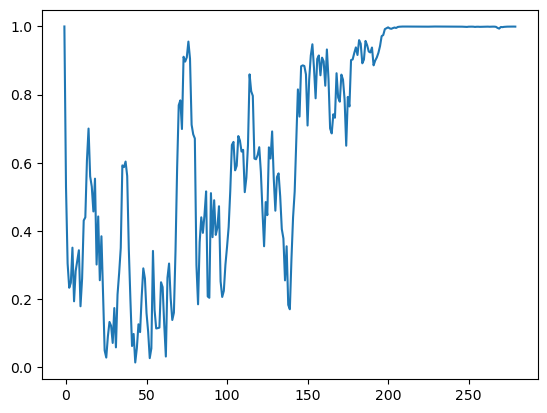

Min prediction for seq version (i=44): MKFLVKTQRGMESVTANYIREALPDAEVWASPMGYSGLVIVETXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXRLLIITDPKGPSLAEVKDKLARDMYYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSMWEIYEEYSRTREGEE
Patched subseq: DDRSAEEKILEIPEVERAIKVLFEVPAELEAILSVAEDVAKLIRENETFAVKTKRRGKHDFSSLDVNAQLGAKIKELTNADVNLSWPDKVVQVEIIGDKAYISLLPGEEYRKFTPDKINARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVRELIIAPKEKMDAFELMEFIKGVRVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNK
==== Sequence patch results: ====
MKFIVKTQRGMESVAANYIKESLPDARVWASPMGYYGLVIVETDEEKAAGKILEIPEVERLIPVIVEVPAELEKIVESAEKLAPMIRESETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDKVVQVEIIGDRAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVRIGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKENLAKDMFYSKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWE

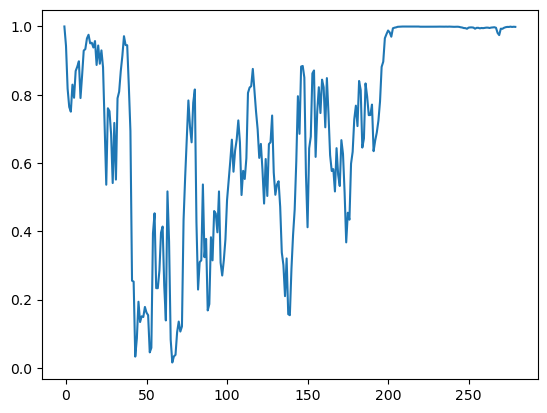

Min prediction for seq version (i=67): MKFIVKTQRGMESVAANYIKESLPDARVWASPMGYYGLVIVETDEEKAAGKILEIPEVERLIPVIVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXMFYSKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREEKA
Patched subseq: EVPAELEKIVESAEKLAPMIRESETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDKVVQVEIIGDRAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVRIGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKENLAKD
==== Sequence patch results: ====
MKFIVKTQRGMEGVAANYVKEALPDAKIWISPMGYSGLVIVEAGDEGAGERILEIPEVERIIPVLVEVPAELEAIVSSAEKIASLIGEDETFAVKTKRRGKHGFTSVDVNRELGARIRELTNSDVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGVRIGQESRHRIQREAYPWKVEKVPVSVWDLYQVVRDKRRPKRLLIITDPKGPTLAEVKADLARDAFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWE

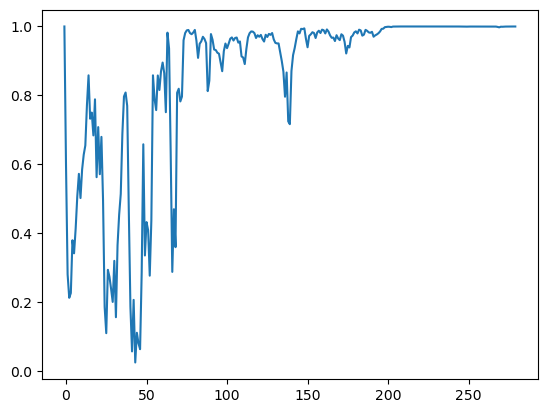

Min prediction for seq version (i=44): MKFIVKTQRGMEGVAANYVKEALPDAKIWISPMGYSGLVIVEAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXRLLIITDPKGPTLAEVKADLARDAFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEIYEEYARNLEEGD
Patched subseq: GDEGAGERILEIPEVERIIPVLVEVPAELEAIVSSAEKIASLIGEDETFAVKTKRRGKHGFTSVDVNRELGARIRELTNSDVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGVRIGQESRHRIQREAYPWKVEKVPVSVWDLYQVVRDKRRPK
==== Sequence patch results: ====
MKFIVKTQRGMEGVAANYIREALPNSKVQASPLGYYGLVIVESDDENAVEKILEIPEVERVIPVLVEVPAEIEEIVNAAENVAPFIGENETFAVKTKRRGKHGFSSLDVNRSLGAKVQELTGADVNLSWPDKVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARELFRKLTVVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRAKRLLIITDPKGPTLAEVKDNLARDMFHAKEIIVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWE

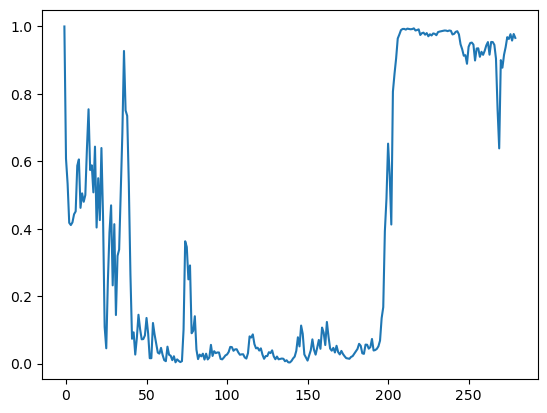

Min prediction for seq version (i=140): MKFIVKTQRGMEGVAANYIREALPNSKVQASPLGYYGLVIVESDDENAVEKILEIPEVERVIPVLVEVPAEIEEIVNAAENVAPFIGENETFAVKTKRRGKHGFSSLDVNRSLGAKVQELTGADVNLSWPDKVVQVEIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: GDKAYISVVPGEEFRKFTPDKIDARELFRKLTVVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRAKRLLIITDPKGPTLAEVKDNLARDMFHAKEIIVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRSREKE
==== Sequence patch results: ====
MKFIVKTQRGLEGVAAGYIRETLPDAEVWASPMGYSGLVIVESEDGNAAERILEIPEVERAIPVLVEVPAELEAIVDTAGKIAPLIKEEETFAVRTKRRGKHDFSSVDVNRELGARIRELTNSDVNLSWPDRVVQVEIIGDRAYVSLLPGEEFRKFTPGKIDARKLFQKVVLVQMPYWGDYRACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGVKIGQESRHRIQSEAYPWKVEKVPVSLWDLYQVVRDKRRKKRLLIITDPKGPTLAGVKDELARDLFHSKEVVIFIGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWE

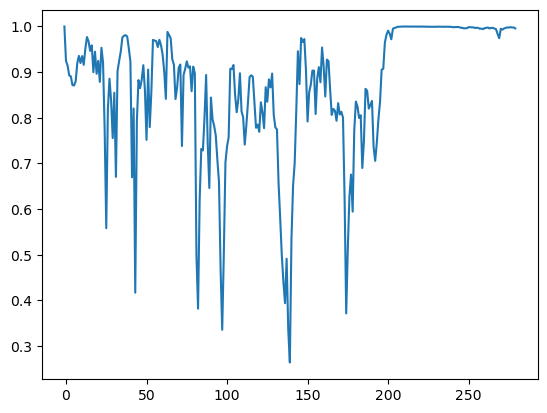

Min prediction for seq version (i=140): MKFIVKTQRGLEGVAAGYIRETLPDAEVWASPMGYSGLVIVESEDGNAAERILEIPEVERAIPVLVEVPAELEAIVDTAGKIAPLIKEEETFAVRTKRRGKHDFSSVDVNRELGARIRELTNSDVNLSWPDRVVQVEIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: GDRAYVSLLPGEEFRKFTPGKIDARKLFQKVVLVQMPYWGDYRACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGVKIGQESRHRIQSEAYPWKVEKVPVSLWDLYQVVRDKRRKKRLLIITDPKGPTLAGVKDELARDLFHSKEVVIFIGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRKKP
==== Sequence patch results: ====
MVWIEIFHDEAFISITSGSEERKKSYPGKPNLRQVPKRIVIGQVPYVGDIEAVRRMGIRIGRAAQTFEIKSLYVTPFRPLEGFILKTFLDGVYEGIKSRYEIQKKAYSVKPHRVPVYVYDLYQFVRLKCDKPIIVTSTRGKPLVTVKDSIIDLFSKHKEIIILIGAHEGLPTGLFRAAELVIDLAPGITISTDNALTSAVIGLVTVLEESKIG


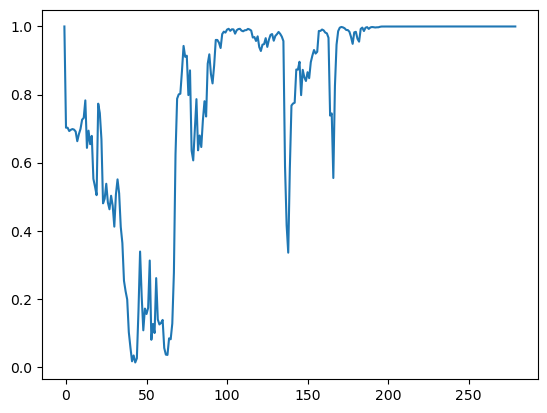

Min prediction for seq version (i=44): MVWIEIFHDEAFISITSGSEERKKSYPGKPNLRQVPKRIVIGQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: VPYVGDIEAVRRMGIRIGRAAQTFEIKSLYVTPFRPLEGFILKTFLDGVYEGIKSRYEIQKKAYSVKPHRVPVYVYDLYQFVRLKCDKPIIVTSTRGKPLVTVKDSIIDLFSKHKEIIILIGAHEGLPTGLFRAAELVIDLAPGITISTDNALTSAVIGLVTVLEESKIG
==== Sequence patch results: ====
MMEKTTIIVKTHKNLERIAASYIRDLIPDSEVLVKPNGYAGIILLKVKSVDAQTLKTTLITIPEIEKILFVRKCVEANLDRICEAVRHLARVSLKENEKFAVHTVRRGNHPFTSIDVNIKVGTCIQQETQCKVDLTLPDKIFWIEIIDNKAYISIVSRDIFYRKKTPDKLDNMKYLKKTIIVQMPYLDEIASSKIGVRIGRIVQSYEIPSIIVAPIYRVNAKELMYFLQGIHEGIMSRYKLQLKTYNDRKVSKTRVYLHDLYQLVRNINRDKEGIIITTTKGQPIKEETITKVKSLYMDKKKVYVFIGSREGIPTGLFKFADILLDVAPQITLATDVAVSSIISAILNMLLL


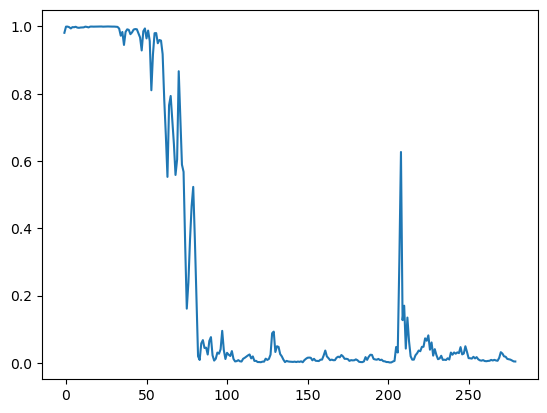

Min prediction for seq version (i=202): MMEKTTIIVKTHKNLERIAASYIRDLIPDSEVLVKPNGYAGIILLKVKSVDAQTLKTTLITIPEIEKILFVRKCVEANLDRICEAVRHLARVSLKENEKFAVHTVRRGNHPFTSIDVNIKVGTCIQQETQCKVDLTLPDKIFWIEIIDNKAYISIVSRDIFYRKKTPDKLDNMKYLKKTIIVQMPYLDEIASSKIGVRIGRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: IVQSYEIPSIIVAPIYRVNAKELMYFLQGIHEGIMSRYKLQLKTYNDRKVSKTRVYLHDLYQLVRNINRDKEGIIITTTKGQPIKEETITKVKSLYMDKKKVYVFIGSREGIPTGLFKFADILLDVAPQITLATDVAVSSIISAILNMLLL
==== Sequence patch results: ====
MLLVKTQRGLEYIAASYIKDELGDVKLEVRPGGFLGLILVYSDELEKIKGIPEIETIIPILIECKADLDDIISHAGSIAEEIKGARTFAIRTKRRGRHDFSSIDVNFKLGDKIREITGCEVNLNFPEKAIYVEIIGDRTFIGVIEGKEERKKYTPEKLDSRELFHKISVVQVPYLDDLRAALEIGERIGRAAQAFEIKELIIAPFDSVNAFELEQFIKGVRRGQLTRYKIQERAYSREVKKVPILLQDLYQVARDKKRRRNLLIVTDPTGKQISDIKDEIGKGLIYSDEIVVFIGSRVGIPKGIFRFADFIIDLTPYITFATEQAIPSVLTALLTI

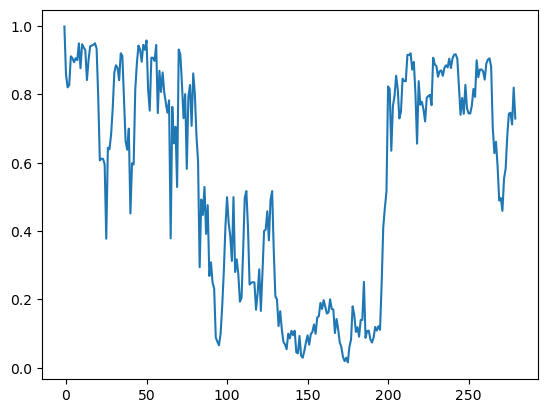

Min prediction for seq version (i=176): MLLVKTQRGLEYIAASYIKDELGDVKLEVRPGGFLGLILVYSDELEKIKGIPEIETIIPILIECKADLDDIISHAGSIAEEIKGARTFAIRTKRRGRHDFSSIDVNFKLGDKIREITGCEVNLNFPEKAIYVEIIGDRTFIGVIEGKEERKKYTPEKLDSRELFHKISVVQVPYLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: DDLRAALEIGERIGRAAQAFEIKELIIAPFDSVNAFELEQFIKGVRRGQLTRYKIQERAYSREVKKVPILLQDLYQVARDKKRRRNLLIVTDPTGKQISDIKDEIGKGLIYSDEIVVFIGSRVGIPKGIFRFADFIIDLTPYITFATEQAIPSVLTALLTIYEEFRNKN
==== Sequence patch results: ====
MKTVLGFENIVKNRIKEIDPSADVLVAPKGFKGLVLAGSNAFDKDKFVKVLNKELIEAEKIIPIDLIVRADPNEICKGISGFVNEKISSDETFAVRTTRRGRHKFTSIDVNIIVGDCVRKYTGASVNLRYPDKIVLVEIIGEEAYISILPGSFEYHKYAPEKKELYRFFNKLSIIQMPYLGPIESVIEIGKRIGREVQNFEVKELVIAPIGLVDAYSLARFIDSVMEGIESRYRVQVKSYHRKPRKTPVYIMDLYQLIRDRGDEVIIVFEPEGRYIVDVKDELEELVLKSRKRINLLFGAREGIPTGIFRYADLVIDIAPGMVLSTDYAVAAGLIALSTILYDK

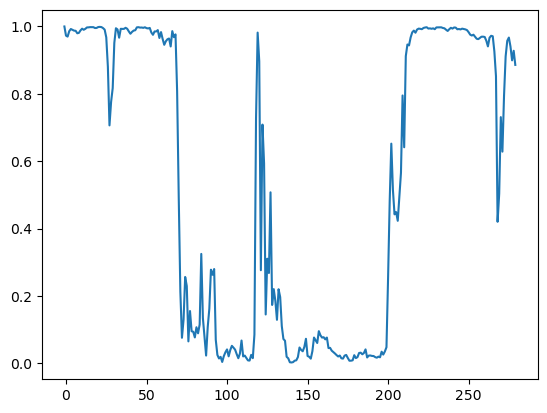

Min prediction for seq version (i=141): MKTVLGFENIVKNRIKEIDPSADVLVAPKGFKGLVLAGSNAFDKDKFVKVLNKELIEAEKIIPIDLIVRADPNEICKGISGFVNEKISSDETFAVRTTRRGRHKFTSIDVNIIVGDCVRKYTGASVNLRYPDKIVLVEIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: GEEAYISILPGSFEYHKYAPEKKELYRFFNKLSIIQMPYLGPIESVIEIGKRIGREVQNFEVKELVIAPIGLVDAYSLARFIDSVMEGIESRYRVQVKSYHRKPRKTPVYIMDLYQLIRDRGDEVIIVFEPEGRYIVDVKDELEELVLKSRKRINLLFGAREGIPTGIFRYADLVIDIAPGMVLSTDYAVAAGLIALSTILYDKYRSMDHESINTSGR
==== Sequence patch results: ====
MERVCASYIKDLNPKLEVVSAPKGFSGLVLVGGADDKYELARLIKERVPEADKVLIIEGVAKAEIPSIAEEVTKIIKDKISPDETFAVRTVRRGSHEFTSIDVNVAVGAKVKEVTGASVNLEFPDKVVAVEIIGGDAYISIIDGKELWRKKGPTKRPMYRLFRRFSIIHEPYLGPLDACRTMGIRIGREAQTFEVDELIIAPKGPVKALELKTFIEGVLEGIETRYQVQVKAYGRDVHKVRVYVQDMYQVVRDRSNEVLIVLEPEGKPVSQCIDELEELILRRRKRINLFIGAREGVPLGIYRFANLVLDIAPGITIATDYALSSALIAI

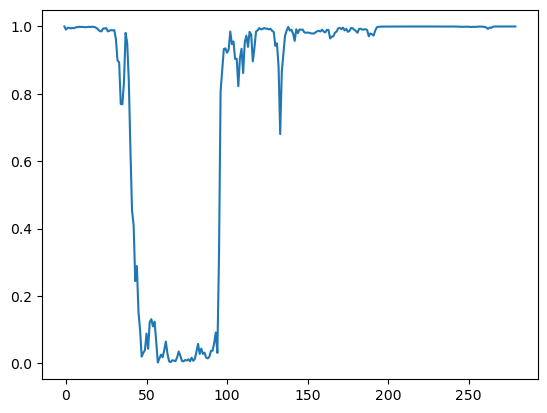

Min prediction for seq version (i=58): MERVCASYIKDLNPKLEVVSAPKGFSGLVLVGGADDKYELARLIKERVPEADKVLIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXELILRRRKRINLFIGAREGVPLGIYRFANLVLDIAPGITIATDYALSSALIAIATLIHDKFSEEW
Patched subseq: EGVAKAEIPSIAEEVTKIIKDKISPDETFAVRTVRRGSHEFTSIDVNVAVGAKVKEVTGASVNLEFPDKVVAVEIIGGDAYISIIDGKELWRKKGPTKRPMYRLFRRFSIIHEPYLGPLDACRTMGIRIGREAQTFEVDELIIAPKGPVKALELKTFIEGVLEGIETRYQVQVKAYGRDVHKVRVYVQDMYQVVRDRSNEVLIVLEPEGKPVSQCIDELE
==== Sequence patch results: ====
MKTPLGLERIVASRAAELIGGHVVARPRGFMGLVVIDGLEDPDEAARRIEEALPEAEYVLRVLATARADLDEIASSAAHVARDLIRPDETFAVRTTRRGKHDFTSIDANVKVGSAVQEATGADVNLTEPDKIVWVEFIGPEVGIAITPGQVVWKKHRPGKPEVLRLLKRISFAQMPYLGEGGRPMGVRIGRAAQAFELSELVITPHEPVDVGQLNAFLSGLLEGRESRFKIQKKTYARKVDKVPFRLQDLYQFVRDRAGEPMIVTDPTGKTVSEAAEDIEEAFRQGGRVNILAGAREGVPKGVFRFATLIIDLCPGLTFATEHTIPATVGALITCLEERGLIRQ


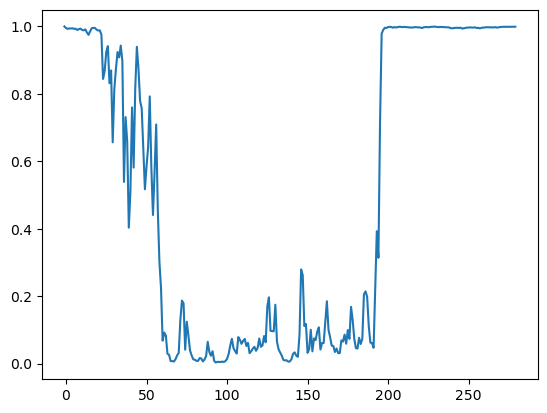

Min prediction for seq version (i=94): MKTPLGLERIVASRAAELIGGHVVARPRGFMGLVVIDGLEDPDEAARRIEEALPEAEYVLRVLATARADLDEIASSAAHVARDLIRPDETFAVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXCPGLTFATEHTIPATVGALITCLEERGLIRQ
Patched subseq: RTTRRGKHDFTSIDANVKVGSAVQEATGADVNLTEPDKIVWVEFIGPEVGIAITPGQVVWKKHRPGKPEVLRLLKRISFAQMPYLGEGGRPMGVRIGRAAQAFELSELVITPHEPVDVGQLNAFLSGLLEGRESRFKIQKKTYARKVDKVPFRLQDLYQFVRDRAGEPMIVTDPTGKTVSEAAEDIEEAFRQGGRVNILAGAREGVPKGVFRFATLIIDL
==== Sequence patch results: ====
MVDLIVKTVKGLERVAAARIKEALGNEVLVKARPLGFLGIVTVEGVRDKEEAKRIVESKVPEVERALVILGECKADLNEIAEVAKRLIRDRLSEAETFAVRTVRRGSHTFTSIDVNVRVGATVKEVTGADVNLSEPDKTIQVEIIGDKAYISLIEGTLELKKVRPGKPKIAPFLRRITVVQVPYLGDREASYKMGVRIGRGLQTFEIGGLYIAPFEPVPVEELEAFLQGVIEGRESRYRIQRRAYAREPFKVPIYLYDLYQYVRNKGSKEVIIATSTSGDPVWEALSKLEKALKGADKISILVGSRKGLPRGVFRFSDAVIDVAPSITLPTDYAAVAIIMAIVTV

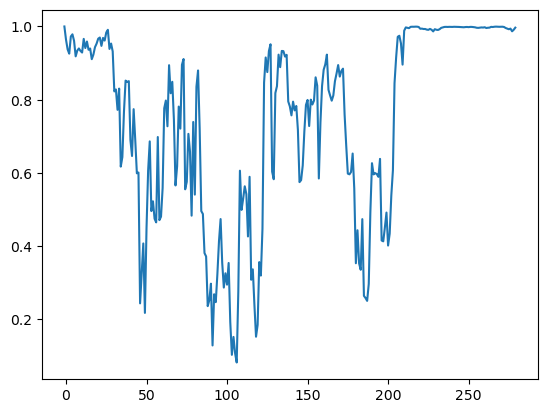

Min prediction for seq version (i=107): MVDLIVKTVKGLERVAAARIKEALGNEVLVKARPLGFLGIVTVEGVRDKEEAKRIVESKVPEVERALVILGECKADLNEIAEVAKRLIRDRLSEAETFAVRTVRRGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXITLPTDYAAVAIIMAIVTVLEGRDFFDKY
Patched subseq: SHTFTSIDVNVRVGATVKEVTGADVNLSEPDKTIQVEIIGDKAYISLIEGTLELKKVRPGKPKIAPFLRRITVVQVPYLGDREASYKMGVRIGRGLQTFEIGGLYIAPFEPVPVEELEAFLQGVIEGRESRYRIQRRAYAREPFKVPIYLYDLYQYVRNKGSKEVIIATSTSGDPVWEALSKLEKALKGADKISILVGSRKGLPRGVFRFSDAVIDVAPS
==== Sequence patch results: ====
MEVLPGAKVVPRPQGFKGLVAVYSDNPRRDAEEIKAKVLEAEHVIPADAVVEARLGKIVEAARSVVQGRIGRDETFAVRTVRRGRHDYTSIDVNVKVGAAVKEATGAGVNLDYPDKIVCVEIIGDTAIISVLPGSEEYKKMRPGKKPILKYLHRIALVQMPYLGPLDAAYNMGVRVGREAQNFEVKELVIAPIGLTPADQLQKFIEGVYQGIESRYAVQKKIYARPVKRVPVYVEDLYQLVRDRFDEPIIIFEPEGEPVIKMAREIFEVFEGGHGRINILVGSREGTPVGLYRFARMVLDIAPEVTISTDLAAASAITALITVLEGERP


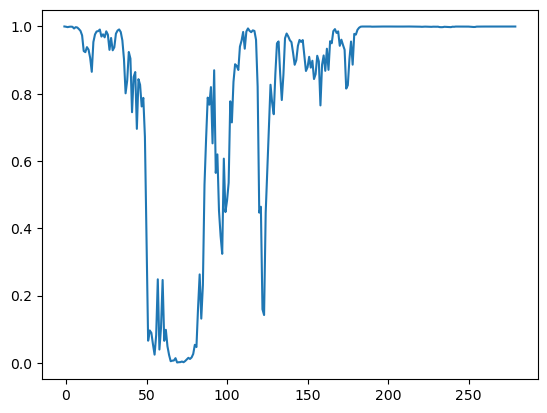

Min prediction for seq version (i=70): MEVLPGAKVVPRPQGFKGLVAVYSDNPRRDAEEIKAKVLEAEHVIPADAVVEARLGKIVEAARSVVQGRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGLYRFARMVLDIAPEVTISTDLAAASAITALITVLEGERP
Patched subseq: IGRDETFAVRTVRRGRHDYTSIDVNVKVGAAVKEATGAGVNLDYPDKIVCVEIIGDTAIISVLPGSEEYKKMRPGKKPILKYLHRIALVQMPYLGPLDAAYNMGVRVGREAQNFEVKELVIAPIGLTPADQLQKFIEGVYQGIESRYAVQKKIYARPVKRVPVYVEDLYQLVRDRFDEPIIIFEPEGEPVIKMAREIFEVFEGGHGRINILVGSREGTPV
==== Sequence patch results: ====
MGLVLEILVKTPLGLEEVCASRIAELDPGAEVVVRPGGYVGLVGVVRCSDPDSLYQRILSEVLESESAYRVVASAKAASLEDIAEAAVRAARGRLDSGKSFAVRTVRRGRHSFTSLDVNVAVGAAIQREYSSLVDLDHPDMVVRVEIIDDAAYLSVYEGGREWVKMGPGKREAWGFFSKISVVQMPYIGPPKSCREMGARIGRAVQAFEVGEVVVAPAEPVEARSLAEFILGILEGQESRLEVQSRAYARRPRRVEVLVQDLYQLVRARRGEPIIVFEPEGVELSRASERLSELYRSARRVNFLFGAREGIPKGVYRVADLVVDLAPAMTLPTELAAPTALLAVYTALRVAGGGGVDEV


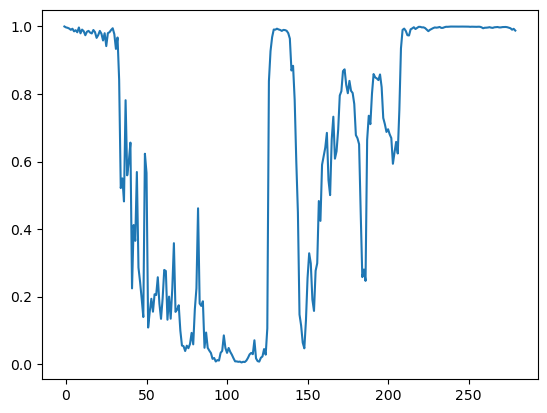

Min prediction for seq version (i=110): MGLVLEILVKTPLGLEEVCASRIAELDPGAEVVVRPGGYVGLVGVVRCSDPDSLYQRILSEVLESESAYRVVASAKAASLEDIAEAAVRAARGRLDSGKSFAVRTVRRGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXTLPTELAAPTALLAVYTALRVAGGGGVDEV
Patched subseq: RHSFTSLDVNVAVGAAIQREYSSLVDLDHPDMVVRVEIIDDAAYLSVYEGGREWVKMGPGKREAWGFFSKISVVQMPYIGPPKSCREMGARIGRAVQAFEVGEVVVAPAEPVEARSLAEFILGILEGQESRLEVQSRAYARRPRRVEVLVQDLYQLVRARRGEPIIVFEPEGVELSRASERLSELYRSARRVNFLFGAREGIPKGVYRVADLVVDLAPAM
==== Sequence patch results: ====
MGGVETERYGALDLIVKTPLGLERIAASRIEELGVECHVHPKPHGFLGLVIVSGVPEDRKWELAERIKNEVPEVERVLVSEESVKADLDAIVESAVRVSSRFLDKDTSFAVRTVRRGKHPYTSIDVNCRVGSAIVEALESPVDLESPDKIVWIEIVGESAAVGVIDGKDVWRKMGPEKVDLRRFFSKVSVVQTPYFGPKNAIKTVSSRVGRAVQMFEVGEFVIATVGAVDAKQLELFIQGVLEGIESRYSVQKRIYAYKPRRVKVLVQDLYQLVRDRRGEPKVVFEPEGEPFPKAAGKLADILTSSEARVNLLFGSREGIPKGVFRFAD

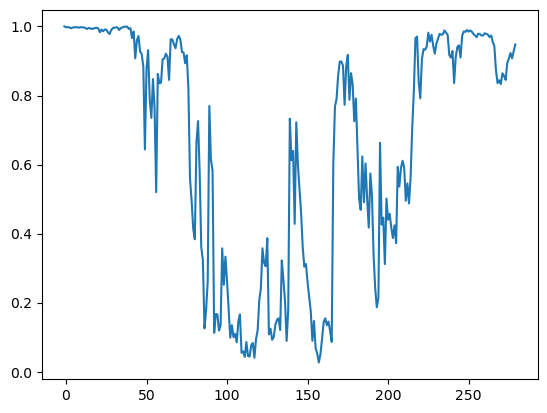

Min prediction for seq version (i=158): MGGVETERYGALDLIVKTPLGLERIAASRIEELGVECHVHPKPHGFLGLVIVSGVPEDRKWELAERIKNEVPEVERVLVSEESVKADLDAIVESAVRVSSRFLDKDTSFAVRTVRRGKHPYTSIDVNCRVGSAIVEALESPVDLESPDKIVWIEIVGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: ESAAVGVIDGKDVWRKMGPEKVDLRRFFSKVSVVQTPYFGPKNAIKTVSSRVGRAVQMFEVGEFVIATVGAVDAKQLELFIQGVLEGIESRYSVQKRIYAYKPRRVKVLVQDLYQLVRDRRGEPKVVFEPEGEPFPKAAGKLADILTSSEARVNLLFGSREGIPKGVFRFADLIVDLCPGITLSTEYAASSALIGLAFAVEEKATHT
==== Sequence patch results: ====
MGATGFTPTSTGQTASFSQQSQGQFKSPHAIRGCVVVELKPCLVVTTHLGLERVAASRIKEEFGVEAEPMPGGFQGLIIVYCQGFDVDLLTKELSSRVVEAERVLPIYRAVKADLEEICEAVRSLAPQVLGESESFAVRTERRGHHSFTSIDVNVKAGACVQSVRGNPVDLENPDKIFWVEVLGDTAYVSVTPGSVVFRKSYDRKPNVLVHLRKIVIGQVPYLADAEASYKVGVRIGRAVQSFEVKELVITPYTPVDARPLAGFIRGVLEGIDSRYSIQTRSYSRKVHRVPVNLFDLYQLVRDYRERNIPIIATSTKGRYVGEV

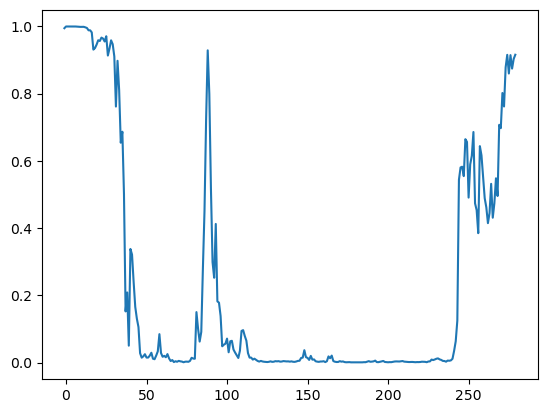

Min prediction for seq version (i=184): MGATGFTPTSTGQTASFSQQSQGQFKSPHAIRGCVVVELKPCLVVTTHLGLERVAASRIKEEFGVEAEPMPGGFQGLIIVYCQGFDVDLLTKELSSRVVEAERVLPIYRAVKADLEEICEAVRSLAPQVLGESESFAVRTERRGHHSFTSIDVNVKAGACVQSVRGNPVDLENPDKIFWVEVLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: GDTAYVSVTPGSVVFRKSYDRKPNVLVHLRKIVIGQVPYLADAEASYKVGVRIGRAVQSFEVKELVITPYTPVDARPLAGFIRGVLEGIDSRYSIQTRSYSRKVHRVPVNLFDLYQLVRDYRERNIPIIATSTKGRYVGEVKRDVRRIFENSDKVLVLIGSREGLPTGVLRFSDLVIDVLPGVTLATDVAAPSILTAIAGVLAEESND
==== Sequence patch results: ====
MRLLVTTRTGNEYLAARILEDRFHAIEDTDARPTGLKGLVILEAREGIEADEVGEVSEVEKVIEIDRELEDPQVREIAKAAGEVAAELPDGTRFAVRCTRRGSHDFTSQDVERLAGAAVLDRDEEHEVDLDDPDHVLRVEIINDWTGIGLVAGEDIHKKYVGKPDARRLTKKTTIVQRMYESQHPRGTNRIGAALGRSAQAFEVDRLVVGMAEPAEADDLDRFVDALQEGIGSRHEVQKKAYEQQRDRVPVEVADLHQMARRAKGSGALVVATDPRGETVADVRDELGTDLREADEI

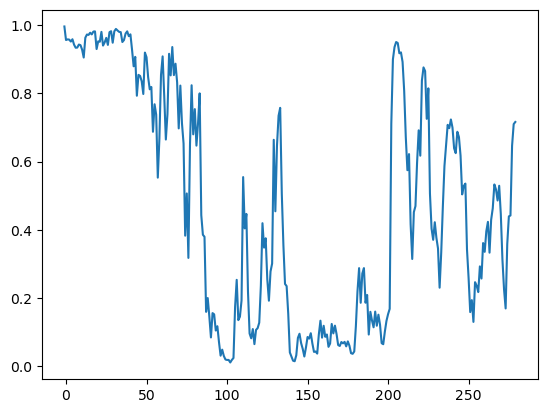

Min prediction for seq version (i=103): MRLLVTTRTGNEYLAARILEDRFHAIEDTDARPTGLKGLVILEAREGIEADEVGEVSEVEKVIEIDRELEDPQVREIAKAAGEVAAELPDGTRFAVRCTRRGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPSITYGTDQAIAASLVALLTAWKPPEG
Patched subseq: SHDFTSQDVERLAGAAVLDRDEEHEVDLDDPDHVLRVEIINDWTGIGLVAGEDIHKKYVGKPDARRLTKKTTIVQRMYESQHPRGTNRIGAALGRSAQAFEVDRLVVGMAEPAEADDLDRFVDALQEGIGSRHEVQKKAYEQQRDRVPVEVADLHQMARRAKGSGALVVATDPRGETVADVRDELGTDLREADEIYVFNGSNEALPTGMFSHADHVLDLA
==== Sequence patch results: ====
MELILKTPIGLEKIAADRLIEMDREISLSVKPHGLEGLIVVERCSDKQALVNYILKNVPEVESLVNVEVETEANLKSIVDAARKVSRGKISEKESFAVRTVRRGRHDFKSIDVNVAAGAAVQEETGAYVNLDHPDKIVQIEIIHDRAGISVTNGFRWKKMSPDKKPALNFFNKISIVQMPYLGSLEGAKEVGARIGRAVQAYEVRELVIAPNKPVDAYELNKFIDGVIEGIESRFRIQCKSYDRKVEKVRVSVQDLYQLVRDRSGEPMIVFEPEGIQLIEAATKLRKIFEEADRVNYLFGSREGIPKGVYRVASMVIDLAPGITLPTELAAPTALASTY

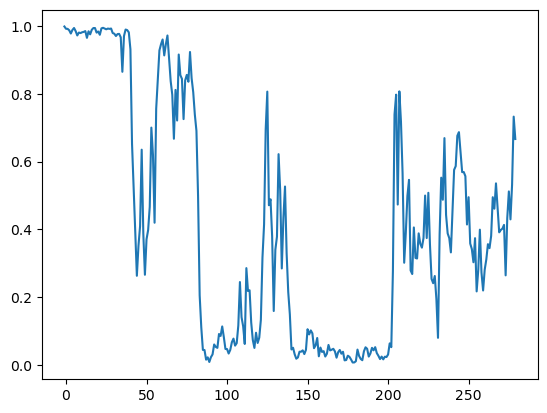

Min prediction for seq version (i=179): MELILKTPIGLEKIAADRLIEMDREISLSVKPHGLEGLIVVERCSDKQALVNYILKNVPEVESLVNVEVETEANLKSIVDAARKVSRGKISEKESFAVRTVRRGRHDFKSIDVNVAAGAAVQEETGAYVNLDHPDKIVQIEIIHDRAGISVTNGFRWKKMSPDKKPALNFFNKISIVQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: MPYLGSLEGAKEVGARIGRAVQAYEVRELVIAPNKPVDAYELNKFIDGVIEGIESRFRIQCKSYDRKVEKVRVSVQDLYQLVRDRSGEPMIVFEPEGIQLIEAATKLRKIFEEADRVNYLFGSREGIPKGVYRVASMVIDLAPGITLPTELAAPTALASTYTVISMIEQNIEDN
==== Sequence patch results: ====
MAAQWQYLATAPRDKAHIVASRLRECFPQAQLVPEPSGYWGLVWLGSDRELPTATMRAIPELEQAIAIEAEVAPPDCAAIAATCARAAERLPEGATFAVRATRRGQHAFTSRDVKIAAGAAVLDASRTLSVDLSAPDFVIRVELVGDWAGIGLLEGSCVRPKKRGKADSRQLTQKLTLVQLAYESEDLRGTRRMGESLGRSVQAFELAQLIVVVDSPVSARSLRTLLDGIEEGRESRFSLQKRTYGHRVRQVPLVVYELYQLLRDAAEAPTLTVATDPRGQTLPAVAQELAGELESAPAVYALNGSNEGIPPGCFELADYTLDLAPQMTYGTDQAI

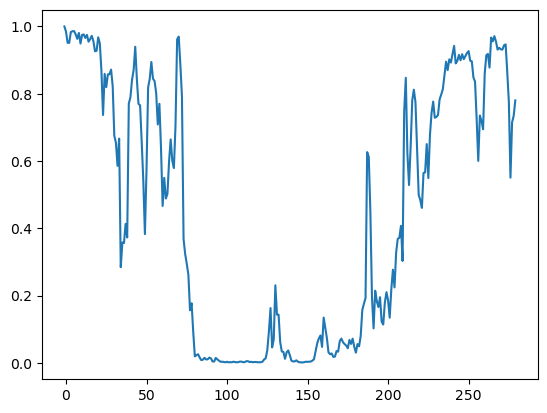

Min prediction for seq version (i=148): MAAQWQYLATAPRDKAHIVASRLRECFPQAQLVPEPSGYWGLVWLGSDRELPTATMRAIPELEQAIAIEAEVAPPDCAAIAATCARAAERLPEGATFAVRATRRGQHAFTSRDVKIAAGAAVLDASRTLSVDLSAPDFVIRVELVGDXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: WAGIGLLEGSCVRPKKRGKADSRQLTQKLTLVQLAYESEDLRGTRRMGESLGRSVQAFELAQLIVVVDSPVSARSLRTLLDGIEEGRESRFSLQKRTYGHRVRQVPLVVYELYQLLRDAAEAPTLTVATDPRGQTLPAVAQELAGELESAPAVYALNGSNEGIPPGCFELADYTLDLAPQMTYGTDQAIAATTIALLDVWHGHPARASRS
==== Sequence patch results: ====
MKFIIKTQRGMESVAANYIREALPDASVWASPMGYSGLVIVETTDENAGEKVLEIPEVERIIPVIVEVPAELEKIVESAERLAPLIGEEETFAVKTKRRGKHGFTSMDVNRELGARIRELTGADVNLSWPDKVVQVEIIGDKAYISVLPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIRGIKVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRSKRLLIITDPKGPTLAEVKEHIARDMFYAKEIVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPA

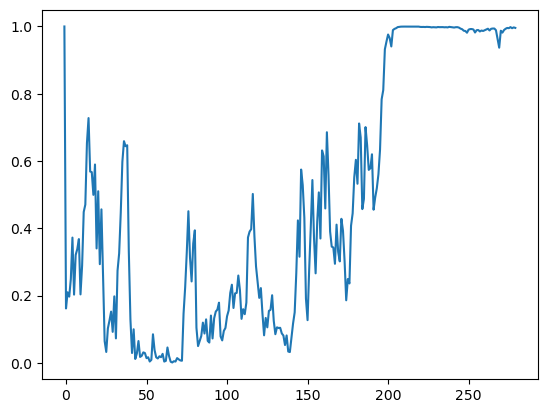

Min prediction for seq version (i=67): MKFIIKTQRGMESVAANYIREALPDASVWASPMGYSGLVIVETTDENAGEKVLEIPEVERIIPVIVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXMFYAKEIVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARRREEKA
Patched subseq: EVPAELEKIVESAERLAPLIGEEETFAVKTKRRGKHGFTSMDVNRELGARIRELTGADVNLSWPDKVVQVEIIGDKAYISVLPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIRGIKVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRSKRLLIITDPKGPTLAEVKEHIARD
==== Sequence patch results: ====
MGSRKFLVKTQRGMEGVAANYIRESLSDAEVLASPFGYYGLVIVESGDEDAEKKILDIPEVERVLPVLAEVPADLEAIVTTAEKIAPLIGEDETFAVKTKRRGKHGFSSLDVNRALGARIQELTNADVNLSWPDKVVQVEIIGDKAYISVIPGEEFRKFTPDKVDARKLFHRLTIVQMPYWGDYKACRTFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVRVGQESRYRIQKDAYPWKVEKVPVSVWDLYQVIRDKRRGKRLLIITDPKGPTLAQVKEELARDMYKAKEVVVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVS

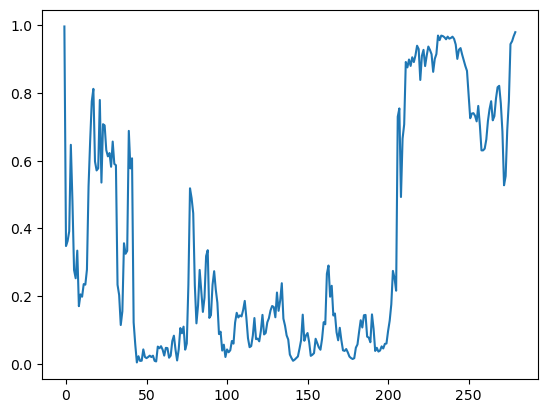

Min prediction for seq version (i=45): MGSRKFLVKTQRGMEGVAANYIRESLSDAEVLASPFGYYGLVIVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGKRLLIITDPKGPTLAQVKEELARDMYKAKEVVVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLKNKD
Patched subseq: ESGDEDAEKKILDIPEVERVLPVLAEVPADLEAIVTTAEKIAPLIGEDETFAVKTKRRGKHGFSSLDVNRALGARIQELTNADVNLSWPDKVVQVEIIGDKAYISVIPGEEFRKFTPDKVDARKLFHRLTIVQMPYWGDYKACRTFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVRVGQESRYRIQKDAYPWKVEKVPVSVWDLYQVIRDKRR
==== Sequence patch results: ====
MGKKFIVKTQRGMESVAANYIKEALSNAEVWTSPMGYSGLVLVESEDETALEKIQEIPEVERVIPVLAEVPAVLDEIVKTAELVAPMIGENETFAVKTKRRGKHDFSSIDVNRALGARIQELTKADVNLSWPDKVVQVEIIGDRAYVSVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYRACRSFGEKIGRAAQAFEVRELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQMEAYPWKVEKVPISVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVGKKLARDMHYAKEVVIFIGSREGIPRGLFRFADYVVDLAPYLTFATEHGIPAALVSL

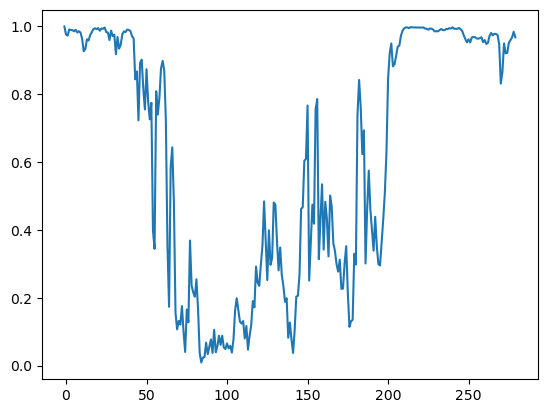

Min prediction for seq version (i=85): MGKKFIVKTQRGMESVAANYIKEALSNAEVWTSPMGYSGLVLVESEDETALEKIQEIPEVERVIPVLAEVPAVLDEIVKTAELVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXIPRGLFRFADYVVDLAPYLTFATEHGIPAALVSLWEVYEEFLREGEEDSE
Patched subseq: APMIGENETFAVKTKRRGKHDFSSIDVNRALGARIQELTKADVNLSWPDKVVQVEIIGDRAYVSVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYRACRSFGEKIGRAAQAFEVRELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQMEAYPWKVEKVPISVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVGKKLARDMHYAKEVVIFIGSREG
==== Sequence patch results: ====
MKFIVKTQRGMESVAANYIREALPDAEVWASPMGYYGLVIVETEDENAGKEILEIPEVERVIPVLVEVPAELERIVETAERIAPLIGENETFAVKTKRRGKHDFSSLDVNRNLGAKIQELTNADVNLSWPDKVVQVEIIGDRAYVSVVPGEEFRKFTPDKIDARKLFHKLTIVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIRGVKVGQESRYQIQREAYPWKVEKVPVSVWDLYQVIRDKRRGKRLLIITDPKGPTLAEVKDKLARDMFYAKEVVVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPGALVS

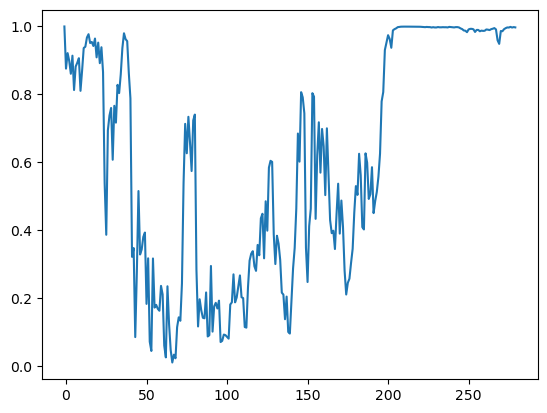

Min prediction for seq version (i=67): MKFIVKTQRGMESVAANYIREALPDAEVWASPMGYYGLVIVETEDENAGKEILEIPEVERVIPVLVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXMFYAKEVVVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPGALVSLWEVYEEYLREREKQTEEESGQ
Patched subseq: EVPAELERIVETAERIAPLIGENETFAVKTKRRGKHDFSSLDVNRNLGAKIQELTNADVNLSWPDKVVQVEIIGDRAYVSVVPGEEFRKFTPDKIDARKLFHKLTIVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIRGVKVGQESRYQIQREAYPWKVEKVPVSVWDLYQVIRDKRRGKRLLIITDPKGPTLAEVKDKLARD
==== Sequence patch results: ====
MEFIIKTQKGLEGTAASYIQEKLKNANTWITPEGYSGLIILKTSDKKATEKLQTIPEIERTIPVNYKTKSKIEKILEKAEKIAEHIKEGETFAVKTKRRGKHKFTSPQVNKKLGEKILKLTNATVDLNFPEKIIQVEIIGENTYISIKKGEKWKKYTPEKENARNLFHKTTIIQMPYWGKPQIVRKFGEKIGRAAQAYEIKELIIAPKEKMDAQQLAEFIQGIKKGQKSRYMIQKEAYPWPTKKVPISLWDLYQAIRDKKRKNRTIIITDPKGKTINTIKENLKKDLRKSKEIIILIGSREGIPRGLFKFADYIIDLTPYITFATEHAIPAT

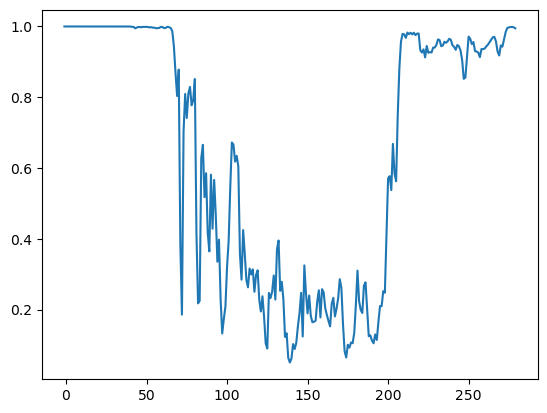

Min prediction for seq version (i=140): MEFIIKTQKGLEGTAASYIQEKLKNANTWITPEGYSGLIILKTSDKKATEKLQTIPEIERTIPVNYKTKSKIEKILEKAEKIAEHIKEGETFAVKTKRRGKHKFTSPQVNKKLGEKILKLTNATVDLNFPEKIIQVEIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: GENTYISIKKGEKWKKYTPEKENARNLFHKTTIIQMPYWGKPQIVRKFGEKIGRAAQAYEIKELIIAPKEKMDAQQLAEFIQGIKKGQKSRYMIQKEAYPWPTKKVPISLWDLYQAIRDKKRKNRTIIITDPKGKTINTIKENLKKDLRKSKEIIILIGSREGIPRGLFKFADYIIDLTPYITFATEHAIPATLTTLYQIYTKKIGYYSRQ
==== Sequence patch results: ====
MQEPVRVDIIVTCKLGFERVVASLIKELCPECRAVPSPMGYMGLVLVKAHTQNIEVLANNIREKVPEAEKVFKVDAECNARLQELGECVKPLASGISSDESFAVRTVRRGKHDYTSLDVNAYIGSVIKEATGARVDLENPDKVVLIQILQDKAYVSIVPGSEFYRKMAPTKFPMYKLYRRMVVAHEPYLGPPDASYVMGTRIGREIQCFEVGKLVVAPVGAVEAEALQRFLRGVIDGQKSRLGIQKKSYGREVHRTEILVQDMYQFVRSWHGKPLIIFEPEGEPVSRVGGELADFIIEKVFREKKELGVMVGAREGIPSGLFRYADFVLDVAPGVVIS

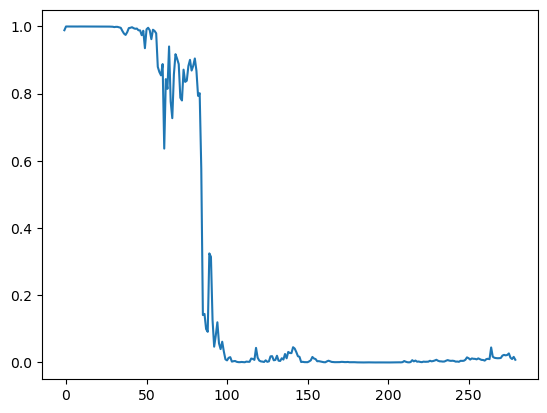

Min prediction for seq version (i=201): MQEPVRVDIIVTCKLGFERVVASLIKELCPECRAVPSPMGYMGLVLVKAHTQNIEVLANNIREKVPEAEKVFKVDAECNARLQELGECVKPLASGISSDESFAVRTVRRGKHDYTSLDVNAYIGSVIKEATGARVDLENPDKVVLIQILQDKAYVSIVPGSEFYRKMAPTKFPMYKLYRRMVVAHEPYLGPPDASYVMGTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: RIGREIQCFEVGKLVVAPVGAVEAEALQRFLRGVIDGQKSRLGIQKKSYGREVHRTEILVQDMYQFVRSWHGKPLIIFEPEGEPVSRVGGELADFIIEKVFREKKELGVMVGAREGIPSGLFRYADFVLDVAPGVVISTDLALTSGLIAIGTAVHDKLLGLDLSDGVEKLAE
==== Sequence patch results: ====
MIVKTPLGLERIVASRIEELGVRCRVTAKPGGYPGIVAVDSVLDEEKVELAERIKREIPEAERVLVSQEVVEAEEDEIVEAALRISRRSLNRDTSFAVRTVRRGSHRYRSVDINHRVGAAVVREVDAPVDLEYPDKILWVEIIDDLAALGVLDGREVWRKRSPEKRDVRRFFSRASVVQMPYLGPRDAARSMGSRIGRAVQMFEVGELVIAVAGAVDARQLGWFIQGVLEGVESRFRVQQRTYAHKPRRVEVRVQDLYQLVRDRRGEPKVVFEPEGEAFPSVAGRLADLFLSGEERINLFFGSREGIPKGIFRLAD

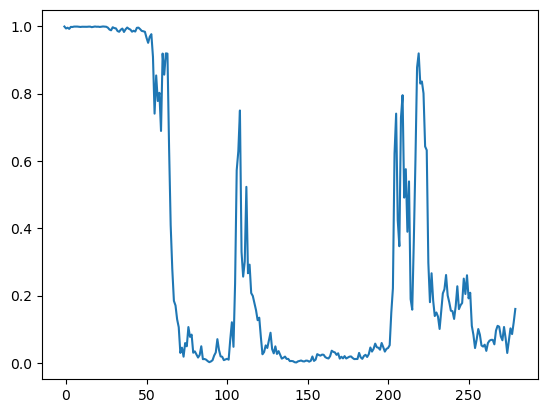

Min prediction for seq version (i=144): MIVKTPLGLERIVASRIEELGVRCRVTAKPGGYPGIVAVDSVLDEEKVELAERIKREIPEAERVLVSQEVVEAEEDEIVEAALRISRRSLNRDTSFAVRTVRRGSHRYRSVDINHRVGAAVVREVDAPVDLEYPDKILWVEIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: DDLAALGVLDGREVWRKRSPEKRDVRRFFSRASVVQMPYLGPRDAARSMGSRIGRAVQMFEVGELVIAVAGAVDARQLGWFIQGVLEGVESRFRVQQRTYAHKPRRVEVRVQDLYQLVRDRRGEPKVVFEPEGEAFPSVAGRLADLFLSGEERINLFFGSREGIPKGIFRLADLIIDLCPGITLSTEYAASSALIGIAFALEEKIKDQE
==== Sequence patch results: ====
MEEPKTNRRIDVIVKTLIGLERIVASRIEEIGIDCRVDPKPFGHPGVVTIELASEERKHELAERIREELPEAERVLVAERCVKADLGAIAEAAVEVSNKFLNEDTSFAVKTVRRGIHSFTSIDVNCRVGSAIVEAYGAPVNLEYPDVILWIEIFNNIAALVIMKGKNVWRKAKPGKYEVREFFSKVAVVQMPYFGPKDSVKAMSSRIGRAVQMFEVSELVIATTGSSDARQLEWFIHGVFEGIESRYRIQKRAYAHKPHRVRVMVQDIYQLVRDRRNEPKIVFEPEGDAFPKVAGDIAKLFLSDARRINMFFGSREGIPKGIFRFADFIVDLCPGV

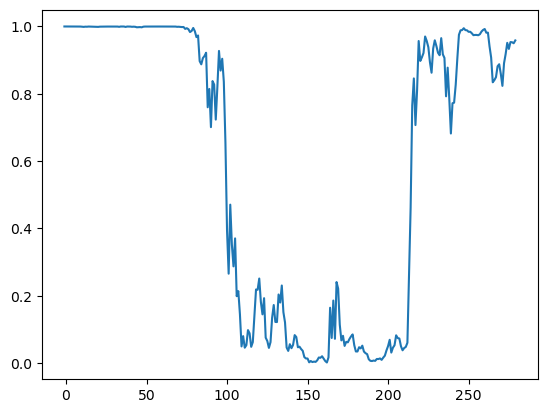

Min prediction for seq version (i=163): MEEPKTNRRIDVIVKTLIGLERIVASRIEEIGIDCRVDPKPFGHPGVVTIELASEERKHELAERIREELPEAERVLVAERCVKADLGAIAEAAVEVSNKFLNEDTSFAVKTVRRGIHSFTSIDVNCRVGSAIVEAYGAPVNLEYPDVILWIEIFNNIAALVIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: MKGKNVWRKAKPGKYEVREFFSKVAVVQMPYFGPKDSVKAMSSRIGRAVQMFEVSELVIATTGSSDARQLEWFIHGVFEGIESRYRIQKRAYAHKPHRVRVMVQDIYQLVRDRRNEPKIVFEPEGDAFPKVAGDIAKLFLSDARRINMFFGSREGIPKGIFRFADFIVDLCPGVTLSTEYAASSALIGLAFALEDHLARSIKGPKAYVPD
==== Sequence patch results: ====
MNKASNQRIDLIIKTPIGLENVAASRIEELGFKGDVNPKPSGYPGIVIVTLQDENEKLQIAERIEREIPEAERVLASRISTEASMKSIVKAAVKVASEILDPEVTFAVRTVRRGHHPYRSVDVNCKVGSAILERIDASVNLDRPEKIVWIEIVDDKAAVGILDGAEVWKKMKPGKQEVRTFFSKASVIQMPYLGDAKSAKSMGSRIGRAVQMFEVGELVIGTTGACDARQLGWFMNGIFEGIDSRYRIQRRTYAHRPRRVEVLVQDLYQLIRDRRSEPKIIFEPEGEKFSKIANEIADLFLKKSGRINLLFGSREG

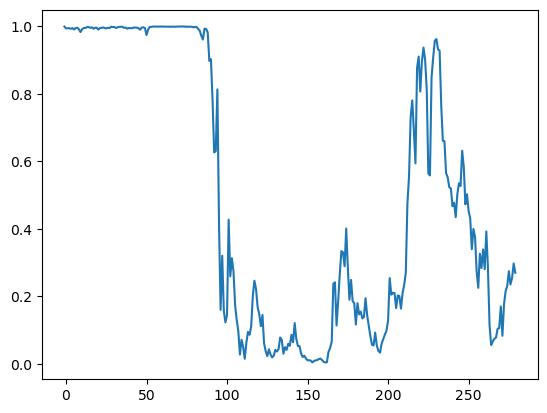

Min prediction for seq version (i=162): MNKASNQRIDLIIKTPIGLENVAASRIEELGFKGDVNPKPSGYPGIVIVTLQDENEKLQIAERIEREIPEAERVLASRISTEASMKSIVKAAVKVASEILDPEVTFAVRTVRRGHHPYRSVDVNCKVGSAILERIDASVNLDRPEKIVWIEIVDDKAAVGIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: LDGAEVWKKMKPGKQEVRTFFSKASVIQMPYLGDAKSAKSMGSRIGRAVQMFEVGELVIGTTGACDARQLGWFMNGIFEGIDSRYRIQRRTYAHRPRRVEVLVQDLYQLIRDRRSEPKIIFEPEGEKFSKIANEIADLFLKKSGRINLLFGSREGIPKGLFRFADFIVDLCPGITLSTEYAASSALIGISFALQNVMENP
==== Sequence patch results: ====
MVRPDIIVKTLLGMERVTASRIEELGFNVNVEPKPKGFPGLVTLEVKRKSDGPKLAEAIKQEIPEAERVLLSEEVVNADMDEIVEAAVKVSTRHLSPDITFAVRTVRRGTHQYKSIDVNYKAGSAIIEATGASVNLDYPDKIIWVEIIGEVAAIGIADKAEIWRKMKPGKVEVRNFFRKVSVVQIPYLGPRGSIRPMGSRIGRAVQMFEVGEYVVAVVGSVKGWMLNLFLEGLLEGVESRYNIQRRTYAHRPHRVEVVVQDLYQLVRERKDEPKIVFEPEGEPFPEVAERLAEMTASNDVARVNMLFGSREGVPKGVFRFVDMVIDL

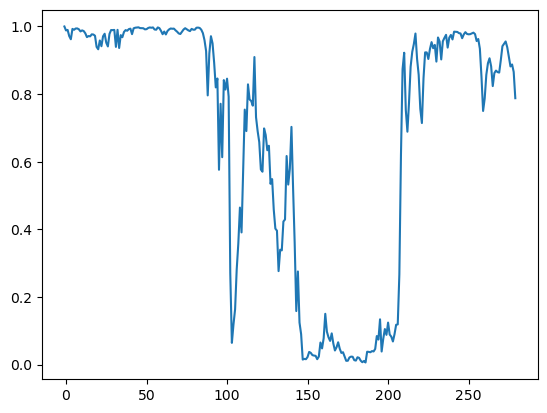

Min prediction for seq version (i=187): MVRPDIIVKTLLGMERVTASRIEELGFNVNVEPKPKGFPGLVTLEVKRKSDGPKLAEAIKQEIPEAERVLLSEEVVNADMDEIVEAAVKVSTRHLSPDITFAVRTVRRGTHQYKSIDVNYKAGSAIIEATGASVNLDYPDKIIWVEIIGEVAAIGIADKAEIWRKMKPGKVEVRNFFRKVSVVQIPXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Patched subseq: YLGPRGSIRPMGSRIGRAVQMFEVGEYVVAVVGSVKGWMLNLFLEGLLEGVESRYNIQRRTYAHRPHRVEVVVQDLYQLVRERKDEPKIVFEPEGEPFPEVAERLAEMTASNDVARVNMLFGSREGVPKGVFRFVDMVIDLCPGVTLSTEYAASSALIGLAYALEEHLKKANV


In [12]:
PATCH_SIZE = 220

all_scores = []
for i in range(1, 50):
    seq = data[i][0]
    
    # skip sequences that are too long
    if len(seq) > SEQ_DIM:
        continue

    seq_scores = visualize_one_seq_results(seq)
    all_scores.append(seq_scores)

In [14]:
# import pickle

# BACKUP_FILE = '/home/jovyan/data/computed_scores_backup.pkl'

# with open(BACKUP_FILE, 'wb') as file:
#     pickle.dump(all_scores, file)

In [22]:
# with open(BACKUP_FILE, 'rb') as file:
#     all_scores_backup = pickle.load(file)
#     print(len(all_scores_backup))

13
